# Imports + Basic Setup

In [1]:
# Imports & basic setup
import joblib
import os
import tempfile
import time
import warnings
import pickle
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Flatten
import tensorflow as tf
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression


In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [3]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU detected for TensorFlow.")

        # Test if XGBoost supports GPU
        try:
            _ = XGBRegressor(tree_method='gpu_hist')
            XGBOOST_TREE_METHOD = 'gpu_hist'
            print("XGBoost GPU mode enabled.")
        except:
            XGBOOST_TREE_METHOD = 'auto'
            print("XGBoost GPU not supported → using CPU mode.")

    except Exception as e:
        print("TensorFlow GPU init failed:", e)
        XGBOOST_TREE_METHOD = 'auto'
else:
    print("No GPU detected → CPU only.")
    XGBOOST_TREE_METHOD = 'auto'


No GPU detected → CPU only.


In [4]:
df=pd.read_csv('merged_energy_weather_data.csv')

In [5]:
def load_and_split_data(filepath):

    # Load data
    df = pd.read_csv(filepath)
    df['datetime'] = pd.to_datetime(df['datetime'], utc=True).dt.tz_convert("Europe/London")
    df = df.sort_values('datetime').reset_index(drop=True)

    # Create time features
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['minute'] = df['datetime'].dt.minute
    df['year'] = df['datetime'].dt.year
    df['weekday'] = df['datetime'].dt.weekday
    df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

    # Define features and target
    target = 'ENGLAND_WALES_DEMAND'

    time_features = ['hour', 'day', 'month', 'year', 'is_weekend', 'weekday']
    weather_features = ['temperature_2m', 'relativehumidity_2m', 'pressure_msl',
                        'wind_speed_10m', 'wind_direction_10m', 'precipitation']
    grid_features = [
        'EMBEDDED_WIND_GENERATION', 'EMBEDDED_WIND_CAPACITY',
        'EMBEDDED_SOLAR_GENERATION', 'EMBEDDED_SOLAR_CAPACITY',
        'NON_BM_STOR', 'PUMP_STORAGE_PUMPING', 'SCOTTISH_TRANSFER',
        'IFA_FLOW', 'IFA2_FLOW', 'BRITNED_FLOW', 'MOYLE_FLOW',
        'EAST_WEST_FLOW', 'NEMO_FLOW', 'NSL_FLOW', 'ELECLINK_FLOW',
        'VIKING_FLOW', 'GREENLINK_FLOW'
    ]

    feature_cols = weather_features + time_features + grid_features

    # Drop NaN
    model_df = df.dropna(subset=feature_cols + [target]).copy()

    # Temporal split: 2023-2024 = train, 2025 = test
    train_df = model_df[model_df.year.isin([2023, 2024])].sort_values("datetime").reset_index(drop=True)
    test_df = model_df[model_df.year == 2025].sort_values("datetime").reset_index(drop=True)

    print(f"✓ Data loaded: Train={len(train_df)}, Test={len(test_df)}")
    print(f"✓ Features: {len(feature_cols)}, Target: {target}")

    return train_df, test_df, feature_cols, target,model_df


# EDA

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Correlation + multicollinearity check (corr matrix, high-corr pairs, VIF)


# Select numeric predictors (exclude target)
target_col = 'ENGLAND_WALES_DEMAND'
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_cols:
    numeric_cols.remove(target_col)

# Drop constant columns and rows with NaNs for the VIF calculation
X_corr = df[numeric_cols].copy()
# Remove cols with zero variance
zero_var = X_corr.columns[X_corr.nunique(dropna=True) <= 1].tolist()
if zero_var:
    print("Dropping zero-variance columns for analysis:", zero_var)
    X_corr = X_corr.drop(columns=zero_var)

# Correlation matrix (absolute)
corr = X_corr.corr().abs()

# Show highly correlated pairs (threshold = 0.8)
threshold = 0.8
high_corr_pairs = []
cols = corr.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        if corr.iloc[i, j] > threshold:
            high_corr_pairs.append((cols[i], cols[j], corr.iloc[i, j]))

print(f"\nFound {len(high_corr_pairs)} highly correlated pairs (|r| > {threshold}):")
for a, b, r in sorted(high_corr_pairs, key=lambda x: -x[2]):
    print(f"  {a} <--> {b} : r = {r:.3f}")

# Heatmap (masked triangle to improve readability)
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmin=0, vmax=1, linewidths=.5)
plt.title('Absolute Correlation Matrix (predictors)')
plt.show()

# Variance Inflation Factor (VIF)
X_vif = X_corr.dropna()  # VIF requires no NaNs
if X_vif.shape[0] == 0 or X_vif.shape[1] == 0:
    print("Not enough data to compute VIF (no rows or no columns after dropna).")
else:
    # Add small jitter if any perfectly collinear columns cause issues
    X_vif_values = X_vif.values.astype(float)
    vif_data = []
    for i, col in enumerate(X_vif.columns):
        try:
            vif = variance_inflation_factor(X_vif_values, i)
        except Exception as e:
            vif = np.nan
            print(f"VIF error for {col}: {e}")
        vif_data.append((col, vif))
    vif_df = pd.DataFrame(vif_data, columns=['feature', 'VIF']).sort_values('VIF', ascending=False)
    display(vif_df.head(40))

    # Flag high VIF features
    high_vif = vif_df[vif_df['VIF'] > 10]
    moderate_vif = vif_df[(vif_df['VIF'] > 5) & (vif_df['VIF'] <= 10)]
    print(f"\nFeatures with VIF > 10: {len(high_vif)}")
    if not high_vif.empty:
        print(high_vif.to_string(index=False))
    print(f"\nFeatures with 5 < VIF <= 10: {len(moderate_vif)}")
    if not moderate_vif.empty:
        print(moderate_vif.to_string(index=False))

    # Simple recommendation printout
    if len(high_corr_pairs) == 0 and high_vif.empty:
        print("\nNo strong multicollinearity detected (corr pairs <= 0.8 and VIF <= 10).")
    else:
        print("\nMulticollinearity detected. Consider:")
        print("- Removing or combining highly correlated features (shown above).")
        print("- Applying dimensionality reduction (PCA) or regularization (Ridge).")

In [ ]:
# 1. check missing values

In [ ]:
df.isnull().sum()

In [ ]:
# 2. check duplicates

In [ ]:
df.duplicated().sum()

In [ ]:
# Select only rows with duplicated datetime
duplicate_rows = df[df['datetime'].duplicated(keep=False)]

#Duplicate SETTLEMENT_DATE and datetime
duplicate_rows[['SETTLEMENT_DATE', 'datetime']]

In [ ]:
# 3. check for impossible values eg negative energy demand or solar/wind generation
#negative value for demand
demand_cols=["ND","TSD","ENGLAND_WALES_DEMAND","EMBEDDED_WIND_GENERATION","EMBEDDED_WIND_CAPACITY","EMBEDDED_SOLAR_GENERATION","EMBEDDED_SOLAR_CAPACITY"]

neg_demand=df[(df[demand_cols]<0).any(axis=1)]
print(f"Negative:          {len(neg_demand)} rows")

In [ ]:
#wind generation > capacity
exceed_wind=df[df["EMBEDDED_WIND_GENERATION"] > df["EMBEDDED_WIND_CAPACITY"]]

#solar generation> capacity
exceed_solar = df[df["EMBEDDED_SOLAR_GENERATION"] > df["EMBEDDED_SOLAR_CAPACITY"]]

print(f"Exceed Wind:          {len(exceed_wind)} rows")

print(f"Exceed Solar:          {len(exceed_solar)} rows")

In [ ]:
# Temperature spikes
temp_spikes = df[(df['temperature_2m'] < -30) | (df['temperature_2m'] > 50)]

# Wind spikes
wind_speed_spikes = df[(df['wind_speed_10m'] < 0) | (df['wind_speed_10m'] > 60)]

#Huminity
humidity_invalid = df[(df['relativehumidity_2m'] < 0) | (df['relativehumidity_2m'] > 100)]

# pressure
pressure_invalid = df[(df['pressure_msl'] < 800) | (df['pressure_msl'] > 1100)]

# wind direction
wind_direction_invalid = df[(df['wind_direction_10m'] < 0) | (df['wind_direction_10m'] > 360)]

# precipitation
precipitation_negative = df[df['precipitation'] < 0]

print(f"Temperature unrealistic:          {len(temp_spikes)} rows")
print(f"Wind speed unrealistic:           {len(wind_speed_spikes)} rows")
print(f"Humidity invalid:                 {len(humidity_invalid)} rows")
print(f"Pressure invalid:                 {len(pressure_invalid)} rows")
print(f"Wind direction invalid:           {len(wind_direction_invalid)} rows")
print(f"Negative precipitation:           {len(precipitation_negative)} rows")

In [ ]:
#mismatch date and time
df['SETTLEMENT_DATE'] = (
    pd.to_datetime(df['SETTLEMENT_DATE'], utc=True)
      .dt.tz_convert("Europe/London")
)

settlement_dates = df['SETTLEMENT_DATE'].dt.date
datetime_dates   = df['datetime'].dt.date

mismatch = df[settlement_dates != datetime_dates]

print(mismatch[['SETTLEMENT_DATE', 'datetime']])

In [ ]:
# 4. plot full time series
# line chart of demand over full time period
# ENGLAND_WALES_DEMAND vs datetime
# to identify overall trends(is demand rising/falling), seasonal patterns(daily/weekly/annual cycles), anomalies(spikes/drops)

In [ ]:
import matplotlib.pyplot as plt

df_2023=df[df['datetime'].dt.year==2023]
df_2024=df[df['datetime'].dt.year==2024]
df_2025=df[df['datetime'].dt.year==2025]

fig,axes=plt.subplots(3,1,figsize=(16,12))

#2023
axes[0].plot(df_2023['datetime'],df_2023['ENGLAND_WALES_DEMAND'],color='lightblue', linewidth=0.8)
axes[0].set_title('England & Wales Demand 2023')
axes[0].set_xlabel('')
axes[0].set_ylabel('MW')
axes[0].grid(True)

#2024
axes[1].plot(df_2024['datetime'],df_2024['ENGLAND_WALES_DEMAND'],color='purple', linewidth=0.8)
axes[1].set_title('England & Wales Demand 2024')
axes[1].set_xlabel('')
axes[1].set_ylabel('MW')
axes[1].grid(True)

#2025
axes[2].plot(df_2025['datetime'],df_2025['ENGLAND_WALES_DEMAND'],color='pink', linewidth=0.8)
axes[2].set_title('England & Wales Demand 2025')
axes[2].set_xlabel('')
axes[2].set_ylabel('MW')
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import MSTL


df['datetime'] = pd.to_datetime(df['datetime'], utc=True, errors='coerce')
df['datetime'] = df['datetime'].dt.tz_localize(None)
df = df.set_index('datetime')



ts = df['ENGLAND_WALES_DEMAND']

mstl = MSTL(
    ts,
    periods=[48, 336],
    stl_kwargs={
        "seasonal_deg": 1,
        "trend_deg": 1,
        "trend_jump": 5
    }
)

res = mstl.fit()


trend = res.trend
seasonal_daily = res.seasonal['seasonal_48']
seasonal_weekly = res.seasonal['seasonal_336']
residual = res.resid


fig, axes = plt.subplots(4, 1, figsize=(15, 14), sharex=True)

axes[0].plot(trend, linewidth=0.9)
axes[0].set_title('Trend')

axes[1].plot(seasonal_daily, linewidth=0.9)
axes[1].set_title('Daily Seasonality (48)')

axes[2].plot(seasonal_weekly, linewidth=0.9)
axes[2].set_title('Weekly Seasonality (336)')

axes[3].plot(residual, linewidth=0.7)
axes[3].set_title('Residual')

plt.tight_layout()
plt.show()

In [ ]:
# 5. plot seasonal patterns
# demand by time of day
# demand by day of week
# demand by month of year
# to identify regular fluctuations in demand associated with daily routines, weekly work patterns, seasonal changes

In [ ]:
fig,axes=plt.subplots(1,3,figsize=(18,5))
sns.lineplot(data=df,x='hour',y='ENGLAND_WALES_DEMAND',ax=axes[0])
axes[0].set_title('Demand by Hour of Day')
sns.lineplot(data=df,x='weekday',y='ENGLAND_WALES_DEMAND',ax=axes[1])
axes[1].set_title('Demand by Day of Week')
sns.lineplot(data=df,x='month',y='ENGLAND_WALES_DEMAND',ax=axes[2])
axes[2].set_title('Demand by Month of Year')
plt.tight_layout
plt.show()

In [ ]:
# 6. plot weather vs demand
# scatter plots of temperature, wind speed, solar radiation vs ENGLAND_WALES_DEMAND
# to identify relationships between weather conditions and energy demand patterns

In [ ]:
weather_vars= ['temperature_2m','relativehumidity_2m','wind_speed_10m', 'EMBEDDED_SOLAR_GENERATION']
fig,axes=plt.subplots(2,2,figsize=(15,10))
axes=axes.flatten()
for i,col in enumerate(weather_vars):
    sns.scatterplot(data=df.iloc[::10],x=col,y='ENGLAND_WALES_DEMAND',alpha=0.1,ax=axes[i])
    axes[i].set_title(f'{col} vs ENGLAND_WALES_DEMAND')
plt.tight_layout()
plt.show()


In [ ]:
# 7. summary statistics
# mean, median, stddev, min, max of key variables
# to understand central tendencies and variability in energy demand and weather conditions

In [ ]:
# Select key variables
key_vars = [
    "ENGLAND_WALES_DEMAND",
    "EMBEDDED_WIND_GENERATION",
    "EMBEDDED_SOLAR_GENERATION",
    "NON_BM_STOR",
    "temperature_2m",
    "relativehumidity_2m",
    "pressure_msl",
    "wind_speed_10m",
    "wind_direction_10m",
    "precipitation"
]

# Filter only variables that actually exist in the dataframe
key_vars = [v for v in key_vars if v in df.columns]

# Compute summary statistics
summary = df[key_vars].agg(["mean", "median", "std", "min", "max"]).T   # .T --> transpose

# Print Summary
print("\nSummary Statistics (Mean, Median, Standard Deviation, Min, Max):\n")
print(summary.round(2))

In [ ]:
# 8.distribution plots
# histograms/kde plots of ENGLAND_WALES_DEMAND, temperature, wind speed, solar radiation
# to visualize data distributions and identify skewness, kurtosis, outliers

In [ ]:
# Select variables for distribution plots
dist_vars = [
    "ENGLAND_WALES_DEMAND",
    "temperature_2m",
    "wind_speed_10m",
    "EMBEDDED_SOLAR_GENERATION"   # using solar generation as solar radiation proxy
]

# Plot settings
plt.style.use("seaborn-v0_8")
plt.figure(figsize=(14, 10))

for i, var in enumerate(dist_vars, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[var].dropna(), kde=True, bins=40)
    var_name = var.replace("_", " ").lower()
    plt.title(f"Distribution of {var_name}")
    plt.xlabel(var)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [ ]:
# 9. box plots
# box plots of ENGLAND_WALES_DEMAND by month
# to identify monthly variations and outliers in demand patterns

# wq:nid 1 or 3 box plot? cuz around 3 years

In [ ]:
# Ensure your datetime column is in datetime format
# df['datetime'] = pd.to_datetime(df['datetime'])

# Extract month from datetime
# df['month'] = df.index.month


# Set plot style
# plt.style.use("seaborn-v0_8")
plt.figure(figsize=(12, 6))

# Create box plot
sns.boxplot(x='month', y='ENGLAND_WALES_DEMAND', data=df)
plt.title('ENGLAND WALES DEMAND by Month')
plt.xlabel('Month')
plt.ylabel('Electricity Demand (MW)')
plt.xticks(ticks=range(12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.show()

In [ ]:
# 10. correlation
# check pearson correlation between Demand and weather variables

In [ ]:
corr_cols=['ENGLAND_WALES_DEMAND','temperature_2m','relativehumidity_2m','wind_speed_10m','precipitation','pressure_msl','EMBEDDED_WIND_GENERATION','EMBEDDED_SOLAR_GENERATION']
plt.figure(figsize=(10,8))
sns.heatmap(df[corr_cols].corr(),annot=True,cmap='coolwarm',fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# 11. stationarity check
# to determine if the time series data (e.g., ENGLAND_WALES_DEMAND) is stationary, which is important for time series modeling
# using ADF test or KPSS test
# rolling mean and stddev plots

In [ ]:
from statsmodels.tsa.stattools import adfuller
series=df['ENGLAND_WALES_DEMAND'].dropna()
result=adfuller(series.iloc[:10000],autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is non-stationary.")

In [ ]:
target_col='ENGLAND_WALES_DEMAND'
window_size=48*7  # one week of half-hourly data

if 'datetime' not in df.columns:
    df = df.reset_index()

rolling_mean=df[target_col].rolling(window=window_size).mean()
rolling_std=df[target_col].rolling(window=window_size).std()


plt.figure(figsize=(15,8))
plt.plot(df['datetime'],df[target_col], label='Original Demand', alpha=0.3,color='gray')
plt.plot(df['datetime'],rolling_mean, label=f'Rolling Mean ({window_size} periods)', color='blue',linewidth=2)
plt.plot(df['datetime'],rolling_std, label=f'Rolling Std Dev ({window_size} periods)', color='red',linewidth=2)
plt.title(f'Stationarity check: rolling mean and stddev of {target_col} (window=7 days)',fontsize=14)
plt.xlabel('Date')
plt.ylabel('Demand(MW)')
plt.legend(loc='best')
plt.grid(True,which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
print("#remark")
print("1.trend:if the blue line(rolling mean) shows a consistent upward or downward slope over time, it indicates a trend in the data.")
print("2.variance:if red line(rolling std) increases or decreases over time, series has changing variance(heteroscedasticity/non stationary)")
print("3.seasonality:repeating waves in rolling mean indicate seasonality")

# Part A

## Preprocessing function

In [6]:
from sklearn.model_selection import TimeSeriesSplit


def iqr_clip_df(df_in, cols):
    """Clip outliers using IQR method"""
    df = df_in.copy()
    clip_info = {}
    for c in cols:
        q1 = df[c].quantile(0.25)
        q3 = df[c].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df[c] = df[c].clip(lower, upper)
        clip_info[c] = (lower, upper)
    return df, clip_info


def create_lag_features(df, target_col, lag_list):
    """Create lagged features for target variable"""
    df_out = df.copy()
    for lag in lag_list:
        df_out[f'{target_col}_lag_{lag}'] = df_out[target_col].shift(lag)
    return df_out

def create_cyclical_encoding(df, cyclical_cols_info):
    """Create sin/cos encoding for cyclical features"""
    df_out = df.copy()
    for col, max_val in cyclical_cols_info.items():
        if col in df_out.columns:
            df_out[f'{col}_sin'] = np.sin(2 * np.pi * df_out[col] / max_val)
            df_out[f'{col}_cos'] = np.cos(2 * np.pi * df_out[col] / max_val)
    return df_out

def combined_ranking_feature_selection(df, target_col, K=15, mi_random_state=42):
    """
    Selects top K features based on a combined rank score from Pearson,
    Spearman, and Mutual Information (MI) correlation metrics.


    Args:
        df_in (pd.DataFrame): The input DataFrame containing features and target.
        target_col (str): The name of the target column.
        K (int): The number of top features to select.
        mi_random_state (int): Random state for reproducibility of MI calculation.


    Returns:
        list: A list of the top K selected feature names.
    """
    df = df.copy()
    df = df.select_dtypes(include=[np.number])

    features = [col for col in df.columns if col != target_col]
    X = df[features]
    y = df[target_col]
    n_features = len(features)

    # 1. Initialize Rank DataFrame
    rank_df = pd.DataFrame(index=features)

    # --- A. Pearson Rank (Linear) ---
    pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
    rank_df['Pearson_Score'] = pearson_scores
    # Rank: Lower rank is better (i.e., higher score)
    rank_df['Pearson_Rank'] = pearson_scores.rank(ascending=False, method='min')


    # --- B. Spearman Rank (Monotonic Nonlinear) ---
    spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()
    rank_df['Spearman_Score'] = spearman_scores
    rank_df['Spearman_Rank'] = spearman_scores.rank(ascending=False, method='min')


    # --- C. Mutual Information (General Nonlinear) ---
    # MI requires the input features X to be a numpy array, and the target y must be 1D.
    # We must treat features as continuous for mi_regression.
    try:
        # MI is sensitive to scaling, but mi_regression handles it somewhat.
        # It's good practice to ensure non-negative inputs if possible, but not strictly required.
        mi_scores = mutual_info_regression(
            X,
            y,
            random_state=mi_random_state,
            n_neighbors=5 # default setting
        )
        mi_scores = pd.Series(mi_scores, index=features)
    except ValueError as e:
        print(f"Error during Mutual Information calculation: {e}. Are there non-numeric/NaN values?")
        return []


    rank_df['MI_Score'] = mi_scores
    rank_df['MI_Rank'] = mi_scores.rank(ascending=False, method='min')


    # --- 2. Combine Ranks (Median Rank) ---
    rank_df['Combined_Rank'] = rank_df[['Pearson_Rank','Spearman_Rank','MI_Rank']].median(axis=1)


    # Sort by the combined rank (lowest rank/score is best)
    rank_df = rank_df.sort_values('Combined_Rank', ascending=True)


    # --- 3. Keep top K ---
    selected_features = rank_df.head(K).index.tolist()

    print("\n--- Feature Ranking Summary (Top K) ---")
    print(rank_df[['Pearson_Rank', 'Spearman_Rank', 'MI_Rank', 'Combined_Rank']].head(K))


    return selected_features


def feature_selection(df, target_col, K=40):

    # Get the list of top K selected features
    selected_cols = combined_ranking_feature_selection(
        df=df,
        target_col=target_col,
        K=K
    )

    # Ensure the target column is included in the final output
    if target_col not in selected_cols:
        selected_cols.append(target_col)

    return df[selected_cols]

In [7]:
def preprocess_data(train_df, test_df, feature_cols, target,
                   apply_iqr=True, apply_lags=True, apply_cyclical=True):

    train_processed = train_df.copy()
    test_processed = test_df.copy()
    current_feature_cols = feature_cols.copy()

    # Step 1: IQR Clipping
    if apply_iqr:
        print("\nStep 1: IQR Clipping...")
        train_processed[current_feature_cols], clip_info = iqr_clip_df(
            train_processed[current_feature_cols],
            current_feature_cols
        )
        # Apply same clipping bounds to test (using train bounds - NO LEAKAGE)
        for col, (lower, upper) in clip_info.items():
            test_processed[col] = test_processed[col].clip(lower, upper)
        print(f"✓ Applied IQR clipping to {len(current_feature_cols)} features")

    # Step 2: Lag Features
    if apply_lags:
        LAG_HOURS = [1, 2, 3, 6, 12, 24]
        print(f"\nStep 2: Adding lag features {LAG_HOURS}...")
        train_processed = create_lag_features(train_processed, target, LAG_HOURS)
        test_processed = create_lag_features(test_processed, target, LAG_HOURS)

        lag_cols = [col for col in train_processed.columns if col.startswith(f'{target}_lag_')]
        current_feature_cols.extend(lag_cols)
        print(f"Added {len(lag_cols)} lag features")

    # Step 3: Cyclical Encoding
    if apply_cyclical:
        cyclical_info = {'hour': 24, 'day': 31, 'month': 12}
        print(f"\nStep 3: Cyclical encoding for {list(cyclical_info.keys())}...")
        train_processed = create_cyclical_encoding(train_processed, cyclical_info)
        test_processed = create_cyclical_encoding(test_processed, cyclical_info)

        cyclical_cols = [col for col in train_processed.columns
                        if '_sin' in col or '_cos' in col]
        current_feature_cols.extend(cyclical_cols)
        print(f"Added {len(cyclical_cols)} cyclical features")

    # Step 4: Drop NaN rows from lagging
    print(f"\nStep 4: Handling NaN from lag features...")
    train_processed = train_processed.dropna(subset=current_feature_cols + [target])
    test_processed = test_processed.dropna(subset=current_feature_cols + [target])
    print(f"Train: {len(train_df)} → {len(train_processed)} samples")
    print(f"Test: {len(test_df)} → {len(test_processed)} samples")


    # Extract final X and y
    X_train = train_processed[current_feature_cols]
    y_train = train_processed[target]
    X_test = test_processed[current_feature_cols]
    y_test = test_processed[target]

    print(f"\nFinal shapes: X_train={X_train.shape}, X_test={X_test.shape}")
    print(f"Total features: {len(current_feature_cols)}")

    return X_train, X_test, y_train, y_test, current_feature_cols

In [8]:
train_df, test_df, feature_cols, target,model_df = load_and_split_data('merged_energy_weather_data.csv')

✓ Data loaded: Train=35088, Test=14545
✓ Features: 29, Target: ENGLAND_WALES_DEMAND


In [9]:

selected_cols=feature_selection(model_df,'ENGLAND_WALES_DEMAND')


--- Feature Ranking Summary (Top K) ---
                           Pearson_Rank  Spearman_Rank  MI_Rank  Combined_Rank
ND                                  1.0            1.0      1.0            1.0
TSD                                 2.0            2.0      2.0            2.0
hour                                3.0            3.0      4.0            3.0
SETTLEMENT_PERIOD                   4.0            4.0      3.0            4.0
temperature_2m                      5.0            5.0      8.0            5.0
PUMP_STORAGE_PUMPING                6.0            6.0      7.0            6.0
is_weekend                          7.0            7.0     23.0            7.0
BRITNED_FLOW                        8.0            8.0     14.0            8.0
EMBEDDED_SOLAR_GENERATION           9.0           27.0      9.0            9.0
weekday                            10.0            9.0     21.0           10.0
NEMO_FLOW                          11.0           10.0     22.0           11.0
month      

## Scaling with post-scaling clip

In [10]:
from sklearn.discriminant_analysis import StandardScaler


def scale_data(X_train, X_test, y_train, y_test, clip_value=5.0):

    # Initialize scalers
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # Fit on training data only
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

    print(f" Features scaled (mean={scaler_X.mean_[:3].round(2)}, std={scaler_X.scale_[:3].round(2)})")
    print(f" Target scaled (mean={scaler_y.mean_[0]:.2f}, std={scaler_y.scale_[0]:.2f})")

    # Post-scaling clip for extreme outliers
    print(f"\nPost-scaling clipping (±{clip_value} std)...")

    X_train_scaled_clipped = np.clip(X_train_scaled, -clip_value, clip_value)
    X_test_scaled_clipped = np.clip(X_test_scaled, -clip_value, clip_value)

    n_clipped_train = np.sum(np.abs(X_train_scaled) > clip_value)
    n_clipped_test = np.sum(np.abs(X_test_scaled) > clip_value)

    if n_clipped_train > 0:
        pct = 100 * n_clipped_train / X_train_scaled.size
        print(f"  Train: Clipped {n_clipped_train} values ({pct:.3f}%)")
    else:
        print(f"  Train: No values exceeded ±{clip_value}")

    if n_clipped_test > 0:
        pct = 100 * n_clipped_test / X_test_scaled.size
        print(f"  Test: Clipped {n_clipped_test} values ({pct:.3f}%)")
    else:
        print(f"  Test: No values exceeded ±{clip_value}")

    print(f" Final ranges: Train=[{X_train_scaled_clipped.min():.2f}, {X_train_scaled_clipped.max():.2f}], "
          f"Test=[{X_test_scaled_clipped.min():.2f}, {X_test_scaled_clipped.max():.2f}]")

    return (X_train_scaled_clipped, X_test_scaled_clipped,
            y_train_scaled, y_test_scaled,
            scaler_X, scaler_y)

## Neural Network Classes

In [11]:
class MLP:
    def __init__(self, input_dim, hidden_units=32, epochs=50, batch_size=32):
        self.input_dim = input_dim
        self.hidden_units = hidden_units
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            Dense(self.hidden_units, activation='relu', input_dim=self.input_dim),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def fit(self, X, y, verbose=0):
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=verbose)

    def predict(self, X):
        return self.model.predict(X, verbose=0).flatten()

    def get_size_mb(self):
        with tempfile.NamedTemporaryFile(suffix='.keras', delete=False) as tmp:
            tmp_name = tmp.name
        # File is now closed
        self.model.save(tmp_name)
        size = os.path.getsize(tmp_name) / (1024 * 1024)
        try:
            os.remove(tmp_name)
        except PermissionError:
            import time
            time.sleep(0.1)
            try:
                os.remove(tmp_name)
            except:
                pass
        return size


class LSTM_Model:
    def __init__(self, input_shape, units=50, epochs=50, batch_size=32):
        self.input_shape = input_shape  # (timesteps, features)
        self.units = units
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            LSTM(self.units, activation='tanh', input_shape=self.input_shape),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def fit(self, X, y, verbose=0):
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=verbose)

    def predict(self, X):
        return self.model.predict(X, verbose=0).flatten()

    def get_size_mb(self):
        with tempfile.NamedTemporaryFile(suffix='.keras', delete=False) as tmp:
            tmp_name = tmp.name
        # File is now closed
        self.model.save(tmp_name)
        size = os.path.getsize(tmp_name) / (1024 * 1024)
        try:
            os.remove(tmp_name)
        except PermissionError:
            import time
            time.sleep(0.1)
            try:
                os.remove(tmp_name)
            except:
                pass
        return size


class TemporalCNN:
    def __init__(self, input_shape, filters=32, epochs=50, batch_size=32):
        self.input_shape = input_shape  # (timesteps, features)
        self.filters = filters
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            Conv1D(self.filters, kernel_size=1, activation='relu', input_shape=self.input_shape),
            Conv1D(max(1, self.filters // 2), kernel_size=1, activation='relu'),
            Flatten(),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def fit(self, X, y, verbose=0):
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=verbose)

    def predict(self, X):
        return self.model.predict(X, verbose=0).flatten()

    def get_size_mb(self):
        with tempfile.NamedTemporaryFile(suffix='.keras', delete=False) as tmp:
            tmp_name = tmp.name
        # File is now closed
        self.model.save(tmp_name)
        size = os.path.getsize(tmp_name) / (1024 * 1024)
        try:
            os.remove(tmp_name)
        except PermissionError:
            import time
            time.sleep(0.1)
            try:
                os.remove(tmp_name)
            except:
                pass
        return size

## Utility functions

In [12]:
def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i+timesteps])
        y_seq.append(y[i+timesteps])
    return np.array(X_seq), np.array(y_seq)


def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mse,
        "RMSE": np.sqrt(mse),
        "R2": r2_score(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred),
    }


def get_model_size_mb(model):
    try:
        with tempfile.NamedTemporaryFile(delete=False, suffix='.pkl') as tmp:
            tmp_name = tmp.name
        # File is now closed
        joblib.dump(model, tmp_name)
        size = os.path.getsize(tmp_name) / (1024 * 1024)
        try:
            os.remove(tmp_name)
        except PermissionError:
            import time
            time.sleep(0.1)
            try:
                os.remove(tmp_name)
            except:
                pass
        return size
    except Exception as e:
        print(f"[Size Error] {e}")
        return np.nan

def preprocess_fold(X_fold_train, X_fold_val, y_fold_train, y_fold_val,
                   apply_iqr=True, clip_value=5.0):
    """
    Apply preprocessing independently per fold to avoid leakage

    Args:
        X_fold_train, X_fold_val: Feature data for this fold
        y_fold_train, y_fold_val: Target data for this fold
        apply_iqr: Whether to apply IQR clipping
        clip_value: Post-scaling clip threshold

    Returns:
        X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled, scalers
    """

    # Step 1: IQR Clipping - using ONLY fold training data
    if apply_iqr:
        Q1 = X_fold_train.quantile(0.25)
        Q3 = X_fold_train.quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Clip both train and val using TRAINING thresholds
        X_fold_train = X_fold_train.clip(lower=lower_bound, upper=upper_bound, axis=1)
        X_fold_val = X_fold_val.clip(lower=lower_bound, upper=upper_bound, axis=1)

    # Step 2: Scaling - fit ONLY on fold training data
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(X_fold_train)
    y_train_scaled = scaler_y.fit_transform(y_fold_train.values.reshape(-1, 1)).flatten()

    # Transform validation using training statistics
    X_val_scaled = scaler_X.transform(X_fold_val)
    y_val_scaled = scaler_y.transform(y_fold_val.values.reshape(-1, 1)).flatten()

    # Step 3: Post-scaling clip
    if clip_value is not None:
        X_train_scaled = np.clip(X_train_scaled, -clip_value, clip_value)
        X_val_scaled = np.clip(X_val_scaled, -clip_value, clip_value)
        y_train_scaled = np.clip(y_train_scaled, -clip_value, clip_value)
        y_val_scaled = np.clip(y_val_scaled, -clip_value, clip_value)

    scalers = {'scaler_X': scaler_X, 'scaler_y': scaler_y}

    return X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled, scalers

## Feature Importance Graph

In [13]:
def analyze_feature_importance(models_dict, feature_cols, top_n=15):
    """
    Analyze and visualize feature importance from tree-based models.

    Args:
        models_dict: Dictionary of trained models
        feature_cols: List of feature names
        top_n: Number of top features to display

    Returns:
        importance_df: DataFrame with feature importance scores
    """

    print("\n" + "="*80)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*80)

    importance_results = {}

    # Extract from tree-based models
    for model_name in ['XGBoost', 'Random Forest', 'Decision Tree']:
        if model_name in models_dict:
            model = models_dict[model_name]

            if hasattr(model, 'feature_importances_'):
                importance = model.feature_importances_
                importance_results[model_name] = importance

                print(f"\nTop {top_n} features for {model_name}:")
                feature_importance = pd.DataFrame({
                    'Feature': feature_cols,
                    'Importance': importance
                }).sort_values('Importance', ascending=False)

                print(feature_importance.head(top_n).to_string(index=False))

    # Visualize
    if len(importance_results) > 0:
        fig, axes = plt.subplots(1, len(importance_results), figsize=(6*len(importance_results), 6))
        if len(importance_results) == 1:
            axes = [axes]

        for idx, (model_name, importance) in enumerate(importance_results.items()):
            feature_importance = pd.DataFrame({
                'Feature': feature_cols,
                'Importance': importance
            }).sort_values('Importance', ascending=False).head(top_n)

            axes[idx].barh(range(len(feature_importance)), feature_importance['Importance'])
            axes[idx].set_yticks(range(len(feature_importance)))
            axes[idx].set_yticklabels(feature_importance['Feature'])
            axes[idx].invert_yaxis()
            axes[idx].set_xlabel('Importance Score')
            axes[idx].set_title(f'{model_name} - Top {top_n} Features')
            axes[idx].grid(axis='x', alpha=0.3)

        plt.tight_layout()
        plt.savefig('feature_importance_analysis.png', dpi=300, bbox_inches='tight')
        print(f"\n✓ Saved: feature_importance_analysis.png")
        plt.close()

    # Create importance DataFrame
    if len(importance_results) > 0:
        importance_df = pd.DataFrame(importance_results, index=feature_cols)
        importance_df['Mean_Importance'] = importance_df.mean(axis=1)
        importance_df = importance_df.sort_values('Mean_Importance', ascending=False)

        return importance_df

    return None

## Correlaration analysis

In [14]:
def analyze_feature_correlations(X_train, y_train, top_n=20):
    """
    Analyze and visualize feature correlations with target.

    Args:
        X_train: Training features (DataFrame)
        y_train: Training target (Series)
        top_n: Number of top features to show

    Returns:
        correlation_df: DataFrame with correlation statistics
    """

    print("\n" + "="*80)
    print("FEATURE CORRELATION ANALYSIS")
    print("="*80)

    # Compute correlations
    df = X_train.copy()
    df['target'] = y_train

    correlations = df.corr()['target'].drop('target').abs().sort_values(ascending=False)

    print(f"\nTop {top_n} features by absolute correlation with target:")
    print(correlations.head(top_n).to_string())

    # Visualize correlation heatmap (top features)
    top_features = correlations.head(top_n).index.tolist()
    top_features_with_target = top_features + ['target']

    corr_matrix = df[top_features_with_target].corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=0.5)
    plt.title(f'Correlation Heatmap - Top {top_n} Features')
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: correlation_heatmap.png")
    plt.close()

    # Create correlation DataFrame
    correlation_df = pd.DataFrame({
        'Feature': correlations.index,
        'Abs_Correlation': correlations.values
    })

    return correlation_df

## Error analysis

In [15]:
def analyze_prediction_errors(y_true, predictions_dict, model_names=None):
    """
    Analyze prediction errors across models.

    Args:
        y_true: True target values
        predictions_dict: Dictionary of {model_name: predictions}
        model_names: List of models to analyze (None = all)

    Returns:
        error_stats_df: DataFrame with error statistics
    """

    print("\n" + "="*80)
    print("PREDICTION ERROR ANALYSIS")
    print("="*80)

    if model_names is None:
        model_names = list(predictions_dict.keys())

    # Create subplots
    n_models = len(model_names)
    fig, axes = plt.subplots(2, n_models, figsize=(5*n_models, 10))
    if n_models == 1:
        axes = axes.reshape(2, 1)

    error_stats = []

    for idx, model_name in enumerate(model_names):
        if model_name not in predictions_dict:
            continue

        y_pred = predictions_dict[model_name]
        errors = y_true - y_pred

        # Statistics
        error_stats.append({
            'Model': model_name,
            'Mean_Error': errors.mean(),
            'Std_Error': errors.std(),
            'Min_Error': errors.min(),
            'Max_Error': errors.max(),
            'Q25_Error': np.percentile(errors, 25),
            'Q75_Error': np.percentile(errors, 75)
        })

        # Plot 1: Actual vs Predicted
        axes[0, idx].scatter(y_true, y_pred, alpha=0.3, s=10)
        axes[0, idx].plot([y_true.min(), y_true.max()],
                         [y_true.min(), y_true.max()],
                         'r--', lw=2, label='Perfect Prediction')
        axes[0, idx].set_xlabel('Actual Demand (MW)')
        axes[0, idx].set_ylabel('Predicted Demand (MW)')
        axes[0, idx].set_title(f'{model_name}\nActual vs Predicted')
        axes[0, idx].legend()
        axes[0, idx].grid(alpha=0.3)

        # Plot 2: Residual distribution
        axes[1, idx].hist(errors, bins=50, edgecolor='black', alpha=0.7)
        axes[1, idx].axvline(0, color='r', linestyle='--', lw=2, label='Zero Error')
        axes[1, idx].set_xlabel('Prediction Error (MW)')
        axes[1, idx].set_ylabel('Frequency')
        axes[1, idx].set_title(f'{model_name}\nError Distribution')
        axes[1, idx].legend()
        axes[1, idx].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('error_analysis.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: error_analysis.png")
    plt.close()

    # Print statistics
    error_stats_df = pd.DataFrame(error_stats)
    print("\nError Statistics:")
    print(error_stats_df.to_string(index=False))

    return error_stats_df

## Temporal error analysis

In [16]:
def analyze_temporal_errors(y_true, predictions_dict, timestamps, model_names=None):
    """
    Analyze how errors vary over time.

    Args:
        y_true: True values
        predictions_dict: Dictionary of predictions
        timestamps: DatetimeIndex or array of timestamps
        model_names: Models to analyze

    Returns:
        temporal_stats_df: DataFrame with temporal error patterns
    """

    print("\n" + "="*80)
    print("TEMPORAL ERROR PATTERN ANALYSIS")
    print("="*80)

    if model_names is None:
        model_names = list(predictions_dict.keys())[:3]  # Top 3 models

    fig, axes = plt.subplots(len(model_names), 1, figsize=(15, 4*len(model_names)))
    if len(model_names) == 1:
        axes = [axes]

    temporal_stats = []

    for idx, model_name in enumerate(model_names):
        if model_name not in predictions_dict:
            continue

        y_pred = predictions_dict[model_name]
        errors = y_true - y_pred

        # Plot errors over time
        axes[idx].plot(timestamps, errors, alpha=0.5, linewidth=0.5, label='Errors')
        axes[idx].axhline(0, color='r', linestyle='--', lw=2, label='Zero Error')
        axes[idx].fill_between(timestamps, errors, 0, alpha=0.2)
        axes[idx].set_xlabel('Time')
        axes[idx].set_ylabel('Prediction Error (MW)')
        axes[idx].set_title(f'{model_name} - Temporal Error Pattern')
        axes[idx].legend()
        axes[idx].grid(alpha=0.3)

        # Compute statistics by month
        if hasattr(timestamps, 'month'):
            df_temp = pd.DataFrame({
                'error': errors,
                'month': timestamps.month
            })
            monthly_stats = df_temp.groupby('month')['error'].agg(['mean', 'std', 'min', 'max'])

            temporal_stats.append({
                'Model': model_name,
                'Best_Month': monthly_stats['mean'].abs().idxmin(),
                'Worst_Month': monthly_stats['mean'].abs().idxmax(),
                'Max_Std_Month': monthly_stats['std'].idxmax()
            })

    plt.tight_layout()
    plt.savefig('temporal_error_patterns.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: temporal_error_patterns.png")
    plt.close()

    if len(temporal_stats) > 0:
        temporal_stats_df = pd.DataFrame(temporal_stats)
        print("\nTemporal Error Patterns:")
        print(temporal_stats_df.to_string(index=False))
        return temporal_stats_df

    return None

## Statistical significance testing

In [17]:
def test_model_differences(results_df, baseline_model='XGBoost', alpha=0.05):
    """
    Test statistical significance of model performance differences.

    Args:
        results_df: DataFrame with CV results per fold
        baseline_model: Model to compare against
        alpha: Significance level

    Returns:
        significance_df: DataFrame with p-values and conclusions
    """

    print("\n" + "="*80)
    print("STATISTICAL SIGNIFICANCE TESTING")
    print("="*80)
    print(f"Baseline Model: {baseline_model}")
    print(f"Significance Level: α={alpha}")

    # Get baseline CV scores
    baseline_scores = results_df[results_df['model'] == baseline_model]['r2'].values

    significance_results = []

    for model_name in results_df['model'].unique():
        if model_name == baseline_model:
            continue

        model_scores = results_df[results_df['model'] == model_name]['r2'].values

        # Paired t-test
        t_stat, p_value = stats.ttest_rel(model_scores, baseline_scores)

        # Conclusion
        if p_value < alpha:
            if model_scores.mean() > baseline_scores.mean():
                conclusion = f"Significantly BETTER (p={p_value:.4f})"
            else:
                conclusion = f"Significantly WORSE (p={p_value:.4f})"
        else:
            conclusion = f"No significant difference (p={p_value:.4f})"

        significance_results.append({
            'Model': model_name,
            'Mean_R2': model_scores.mean(),
            'Baseline_Mean_R2': baseline_scores.mean(),
            'Difference': model_scores.mean() - baseline_scores.mean(),
            'T_Statistic': t_stat,
            'P_Value': p_value,
            'Significant': 'Yes' if p_value < alpha else 'No',
            'Conclusion': conclusion
        })

    significance_df = pd.DataFrame(significance_results)
    significance_df = significance_df.sort_values('Mean_R2', ascending=False)

    print("\nStatistical Comparison Results:")
    print(significance_df[['Model', 'Mean_R2', 'Difference', 'P_Value', 'Significant']].to_string(index=False))

    return significance_df

## Find Optimal K value for feature selection per model

In [18]:
def find_optimal_K_with_neural_networks(X_train, y_train,
                                        feature_selection_func,
                                        target_col,
                                        classical_models_dict,
                                        include_nn=True,
                                        K_ranges=None,
                                        n_cv_splits=3,
                                        verbose=True):
    """
    Find optimal K for ALL models including neural networks.
    """

    print("\n" + "="*80)
    print("FEATURE SELECTION OPTIMIZATION (ALL MODELS)")
    print("="*80)
    print(f"Classical ML models: {len(classical_models_dict)}")
    print(f"Neural Networks: {'Yes' if include_nn else 'No'}")
    print(f"Total features available: {X_train.shape[1]}")
    print("="*80)

    # Imports
    from sklearn.model_selection import TimeSeriesSplit
    from sklearn.metrics import r2_score, mean_squared_error
    from sklearn.preprocessing import StandardScaler
    import time
    import numpy as np
    import pandas as pd

    # Default K ranges (reduced for speed)
    if K_ranges is None:
        n_features = X_train.shape[1]
        K_ranges = {
            'Linear Regression': [8, 12, 15],
            'Ridge Regression': [10, 15, 20],
            'SVR': [8, 12],
            'Decision Tree': [20, 30, n_features],
            'XGBoost': [25, 35, n_features],
            'Random Forest': [30, n_features],
            'MLP': [15, 20, 25],
            'LSTM': [15, 25],
            'Temporal CNN': [15, 20, 25],
        }

    # Prepare data
    train_df = X_train.copy()
    train_df[target_col] = y_train

    # Storage
    results = []
    optimal_K_dict = {}
    feature_importance_dict = {}

    tscv = TimeSeriesSplit(n_splits=n_cv_splits)

    # ========================================================================
    # PART 1: CLASSICAL ML MODELS
    # ========================================================================

    for model_name, model in classical_models_dict.items():
        if model_name not in K_ranges:
            print(f"\nSkipping {model_name} (no K range defined)")
            continue

        print(f"\n{'='*60}")
        print(f"Optimizing K for: {model_name}")
        print(f"{'='*60}")
        print(f"Testing K values: {K_ranges[model_name]}")

        feature_importance_dict[model_name] = {}
        model_results = []

        for K in K_ranges[model_name]:
            if verbose:
                print(f"\n  Testing K={K}...")

            start_time = time.time()

            try:
                selected_df = feature_selection_func(df=train_df, target_col=target_col, K=K)
                selected_features = [col for col in selected_df.columns if col != target_col]
                feature_importance_dict[model_name][K] = selected_features

                if verbose:
                    print(f"    Selected {len(selected_features)} features")
            except Exception as e:
                print(f"    ERROR during feature selection: {e}")
                continue

            cv_scores = []

            for fold_num, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
                X_fold_train = X_train.iloc[train_idx][selected_features]
                y_fold_train = y_train.iloc[train_idx]
                X_fold_val = X_train.iloc[val_idx][selected_features]
                y_fold_val = y_train.iloc[val_idx]

                try:
                    model.fit(X_fold_train, y_fold_train)
                    y_pred = model.predict(X_fold_val)

                    r2 = r2_score(y_fold_val, y_pred)
                    rmse = np.sqrt(mean_squared_error(y_fold_val, y_pred))

                    cv_scores.append({'r2': r2, 'rmse': rmse})
                except Exception as e:
                    print(f"    ERROR in fold {fold_num}: {e}")
                    continue

            if len(cv_scores) > 0:
                mean_r2 = np.mean([s['r2'] for s in cv_scores])
                std_r2 = np.std([s['r2'] for s in cv_scores])
                mean_rmse = np.mean([s['rmse'] for s in cv_scores])
                std_rmse = np.std([s['rmse'] for s in cv_scores])

                elapsed_time = time.time() - start_time

                model_results.append({
                    'Model': model_name,
                    'K': K,
                    'N_Features': len(selected_features),
                    'CV_R2_Mean': mean_r2,
                    'CV_R2_Std': std_r2,
                    'CV_RMSE_Mean': mean_rmse,
                    'CV_RMSE_Std': std_rmse,
                    'Time_Seconds': elapsed_time
                })

                if verbose:
                    print(f"    CV R²: {mean_r2:.6f} ± {std_r2:.6f}")
                    print(f"    CV RMSE: {mean_rmse:.2f} ± {std_rmse:.2f}")

        if len(model_results) > 0:
            model_results_df = pd.DataFrame(model_results)
            optimal_idx = model_results_df['CV_R2_Mean'].idxmax()
            optimal_K = model_results_df.loc[optimal_idx, 'K']
            optimal_r2 = model_results_df.loc[optimal_idx, 'CV_R2_Mean']

            optimal_K_dict[model_name] = optimal_K
            results.extend(model_results)

            print(f"\n  ✓ Optimal K: {optimal_K} (CV R²: {optimal_r2:.6f})")

    # ========================================================================
    # PART 2: NEURAL NETWORKS
    # ========================================================================


    if include_nn:
        # ==================================================================
        # MLP
        # ==================================================================
        if 'MLP' in K_ranges:
            model_name = 'MLP'
            print(f"\n{'='*60}")
            print(f"Optimizing K for: {model_name}")
            print(f"{'='*60}")
            print(f"Testing K values: {K_ranges[model_name]}")

            feature_importance_dict[model_name] = {}
            model_results = []

            for K in K_ranges[model_name]:
                if verbose:
                    print(f"\n  Testing K={K}...")

                start_time = time.time()

                try:
                    selected_df = feature_selection_func(df=train_df, target_col=target_col, K=K)
                    selected_features = [col for col in selected_df.columns if col != target_col]
                    feature_importance_dict[model_name][K] = selected_features

                    if verbose:
                        print(f"    Selected {len(selected_features)} features")
                except Exception as e:
                    print(f"    ERROR during feature selection: {e}")
                    continue

                cv_scores = []

                for fold_num, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
                    X_fold_train = X_train.iloc[train_idx][selected_features]
                    y_fold_train = y_train.iloc[train_idx]
                    X_fold_val = X_train.iloc[val_idx][selected_features]
                    y_fold_val = y_train.iloc[val_idx]

                    scaler_X = StandardScaler()
                    scaler_y = StandardScaler()

                    X_fold_train_scaled = scaler_X.fit_transform(X_fold_train)
                    y_fold_train_scaled = scaler_y.fit_transform(y_fold_train.values.reshape(-1, 1)).flatten()
                    X_fold_val_scaled = scaler_X.transform(X_fold_val)

                    try:
                        model = MLP(input_dim=len(selected_features), hidden_units=32, epochs=30, batch_size=32)
                        model.fit(X_fold_train_scaled, y_fold_train_scaled, verbose=0)

                        y_pred_scaled = model.predict(X_fold_val_scaled)
                        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

                        r2 = r2_score(y_fold_val, y_pred)
                        rmse = np.sqrt(mean_squared_error(y_fold_val, y_pred))

                        cv_scores.append({'r2': r2, 'rmse': rmse})
                    except Exception as e:
                        print(f"    ERROR in fold {fold_num}: {e}")
                        continue

                if len(cv_scores) > 0:
                    mean_r2 = np.mean([s['r2'] for s in cv_scores])
                    std_r2 = np.std([s['r2'] for s in cv_scores])
                    mean_rmse = np.mean([s['rmse'] for s in cv_scores])
                    std_rmse = np.std([s['rmse'] for s in cv_scores])

                    elapsed_time = time.time() - start_time

                    model_results.append({
                        'Model': model_name,
                        'K': K,
                        'N_Features': len(selected_features),
                        'CV_R2_Mean': mean_r2,
                        'CV_R2_Std': std_r2,
                        'CV_RMSE_Mean': mean_rmse,
                        'CV_RMSE_Std': std_rmse,
                        'Time_Seconds': elapsed_time
                    })

                    if verbose:
                        print(f"    CV R²: {mean_r2:.6f} ± {std_r2:.6f}")
                        print(f"    CV RMSE: {mean_rmse:.2f} ± {std_rmse:.2f}")

            if len(model_results) > 0:
                model_results_df = pd.DataFrame(model_results)
                optimal_idx = model_results_df['CV_R2_Mean'].idxmax()
                optimal_K = model_results_df.loc[optimal_idx, 'K']
                optimal_r2 = model_results_df.loc[optimal_idx, 'CV_R2_Mean']

                optimal_K_dict[model_name] = optimal_K
                results.extend(model_results)

                print(f"\n  ✓ Optimal K: {optimal_K} (CV R²: {optimal_r2:.6f})")

        # ==================================================================
        # TEMPORAL CNN
        # ==================================================================
        if 'Temporal CNN' in K_ranges:
            model_name = 'Temporal CNN'
            print(f"\n{'='*60}")
            print(f"Optimizing K for: {model_name}")
            print(f"{'='*60}")
            print(f"Testing K values: {K_ranges[model_name]}")

            feature_importance_dict[model_name] = {}
            model_results = []

            for K in K_ranges[model_name]:
                if verbose:
                    print(f"\n  Testing K={K}...")

                start_time = time.time()

                try:
                    selected_df = feature_selection_func(df=train_df, target_col=target_col, K=K)
                    selected_features = [col for col in selected_df.columns if col != target_col]
                    feature_importance_dict[model_name][K] = selected_features

                    if verbose:
                        print(f"    Selected {len(selected_features)} features")
                except Exception as e:
                    print(f"    ERROR during feature selection: {e}")
                    continue

                cv_scores = []

                for fold_num, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
                    X_fold_train = X_train.iloc[train_idx][selected_features]
                    y_fold_train = y_train.iloc[train_idx]
                    X_fold_val = X_train.iloc[val_idx][selected_features]
                    y_fold_val = y_train.iloc[val_idx]

                    scaler_X = StandardScaler()
                    scaler_y = StandardScaler()

                    X_fold_train_scaled = scaler_X.fit_transform(X_fold_train)
                    y_fold_train_scaled = scaler_y.fit_transform(y_fold_train.values.reshape(-1, 1)).flatten()
                    X_fold_val_scaled = scaler_X.transform(X_fold_val)

                    # Reshape for CNN
                    X_fold_train_cnn = X_fold_train_scaled.reshape(len(X_fold_train_scaled), 1, -1)
                    X_fold_val_cnn = X_fold_val_scaled.reshape(len(X_fold_val_scaled), 1, -1)

                    try:
                        model = TemporalCNN(input_shape=(1, len(selected_features)), filters=32, epochs=30, batch_size=32)
                        model.fit(X_fold_train_cnn, y_fold_train_scaled, verbose=0)

                        y_pred_scaled = model.predict(X_fold_val_cnn)
                        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

                        r2 = r2_score(y_fold_val, y_pred)
                        rmse = np.sqrt(mean_squared_error(y_fold_val, y_pred))

                        cv_scores.append({'r2': r2, 'rmse': rmse})
                    except Exception as e:
                        print(f"    ERROR in fold {fold_num}: {e}")
                        continue

                if len(cv_scores) > 0:
                    mean_r2 = np.mean([s['r2'] for s in cv_scores])
                    std_r2 = np.std([s['r2'] for s in cv_scores])
                    mean_rmse = np.mean([s['rmse'] for s in cv_scores])
                    std_rmse = np.std([s['rmse'] for s in cv_scores])

                    elapsed_time = time.time() - start_time

                    model_results.append({
                        'Model': model_name,
                        'K': K,
                        'N_Features': len(selected_features),
                        'CV_R2_Mean': mean_r2,
                        'CV_R2_Std': std_r2,
                        'CV_RMSE_Mean': mean_rmse,
                        'CV_RMSE_Std': std_rmse,
                        'Time_Seconds': elapsed_time
                    })

                    if verbose:
                        print(f"    CV R²: {mean_r2:.6f} ± {std_r2:.6f}")
                        print(f"    CV RMSE: {mean_rmse:.2f} ± {std_rmse:.2f}")

            if len(model_results) > 0:
                model_results_df = pd.DataFrame(model_results)
                optimal_idx = model_results_df['CV_R2_Mean'].idxmax()
                optimal_K = model_results_df.loc[optimal_idx, 'K']
                optimal_r2 = model_results_df.loc[optimal_idx, 'CV_R2_Mean']

                optimal_K_dict[model_name] = optimal_K
                results.extend(model_results)

                print(f"\n  ✓ Optimal K: {optimal_K} (CV R²: {optimal_r2:.6f})")

        # ==================================================================
        # LSTM
        # ==================================================================
        if 'LSTM' in K_ranges:
            model_name = 'LSTM'
            print(f"\n{'='*60}")
            print(f"Optimizing K for: {model_name}")
            print(f"{'='*60}")
            print(f"Testing K values: {K_ranges[model_name]}")
            print("Note: LSTM requires sequences, may skip some K values if insufficient data")

            feature_importance_dict[model_name] = {}
            model_results = []
            lstm_timesteps = 24

            for K in K_ranges[model_name]:
                if verbose:
                    print(f"\n  Testing K={K}...")

                start_time = time.time()

                try:
                    selected_df = feature_selection_func(df=train_df, target_col=target_col, K=K)
                    selected_features = [col for col in selected_df.columns if col != target_col]
                    feature_importance_dict[model_name][K] = selected_features

                    if verbose:
                        print(f"    Selected {len(selected_features)} features")
                except Exception as e:
                    print(f"    ERROR during feature selection: {e}")
                    continue

                cv_scores = []

                for fold_num, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
                    X_fold_train = X_train.iloc[train_idx][selected_features]
                    y_fold_train = y_train.iloc[train_idx]
                    X_fold_val = X_train.iloc[val_idx][selected_features]
                    y_fold_val = y_train.iloc[val_idx]

                    scaler_X = StandardScaler()
                    scaler_y = StandardScaler()

                    X_fold_train_scaled = scaler_X.fit_transform(X_fold_train)
                    y_fold_train_scaled = scaler_y.fit_transform(y_fold_train.values.reshape(-1, 1)).flatten()
                    X_fold_val_scaled = scaler_X.transform(X_fold_val)

                    try:
                        X_train_seq, y_train_seq = create_sequences(X_fold_train_scaled, y_fold_train_scaled, lstm_timesteps)
                        X_val_seq, y_val_seq = create_sequences(X_fold_val_scaled, y_fold_val.values, lstm_timesteps)

                        if len(X_train_seq) < 10 or len(X_val_seq) < 5:
                            continue

                        model = LSTM_Model(input_shape=(lstm_timesteps, len(selected_features)), units=50, epochs=30, batch_size=32)
                        model.fit(X_train_seq, y_train_seq, verbose=0)

                        y_pred_scaled = model.predict(X_val_seq)
                        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

                        y_val_seq_values = y_fold_val.iloc[lstm_timesteps:].values if hasattr(y_fold_val, 'iloc') else y_fold_val[lstm_timesteps:]

                        r2 = r2_score(y_val_seq_values, y_pred)
                        rmse = np.sqrt(mean_squared_error(y_val_seq_values, y_pred))

                        cv_scores.append({'r2': r2, 'rmse': rmse})
                    except Exception as e:
                        continue

                if len(cv_scores) > 0:
                    mean_r2 = np.mean([s['r2'] for s in cv_scores])
                    std_r2 = np.std([s['r2'] for s in cv_scores])
                    mean_rmse = np.mean([s['rmse'] for s in cv_scores])
                    std_rmse = np.std([s['rmse'] for s in cv_scores])

                    elapsed_time = time.time() - start_time

                    model_results.append({
                        'Model': model_name,
                        'K': K,
                        'N_Features': len(selected_features),
                        'CV_R2_Mean': mean_r2,
                        'CV_R2_Std': std_r2,
                        'CV_RMSE_Mean': mean_rmse,
                        'CV_RMSE_Std': std_rmse,
                        'Time_Seconds': elapsed_time
                    })

                    if verbose:
                        print(f"    CV R²: {mean_r2:.6f} ± {std_r2:.6f}")
                        print(f"    CV RMSE: {mean_rmse:.2f} ± {std_rmse:.2f}")
                else:
                    if verbose:
                        print(f"    Skipped (insufficient sequences)")

            if len(model_results) > 0:
                model_results_df = pd.DataFrame(model_results)
                optimal_idx = model_results_df['CV_R2_Mean'].idxmax()
                optimal_K = model_results_df.loc[optimal_idx, 'K']
                optimal_r2 = model_results_df.loc[optimal_idx, 'CV_R2_Mean']

                optimal_K_dict[model_name] = optimal_K
                results.extend(model_results)

                print(f"\n  ✓ Optimal K: {optimal_K} (CV R²: {optimal_r2:.6f})")

    # ========================================================================
    # SUMMARY
    # ========================================================================

    results_df = pd.DataFrame(results)

    print("\n" + "="*80)
    print("OPTIMIZATION SUMMARY")
    print("="*80)

    if len(optimal_K_dict) > 0:
        print(f"\n{'Model':<20} {'Optimal K':<12} {'Best CV R²':<15}")
        print("-" * 50)

        for model_name, K in optimal_K_dict.items():
            model_data = results_df[(results_df['Model'] == model_name) & (results_df['K'] == K)]
            if len(model_data) > 0:
                r2 = model_data.iloc[0]['CV_R2_Mean']
                print(f"{model_name:<20} {K:<12} {r2:<15.6f}")

        print("\n" + "="*80)
        print(f"✓ Optimized {len(optimal_K_dict)} models")
        print(f"✓ Total runtime: Check 'Time_Seconds' in results_df")
        print("="*80)

    return results_df, optimal_K_dict, feature_importance_dict

In [29]:
# Step 1: Load and split
train_df, test_df, feature_cols, target,model_df = load_and_split_data(filepath='merged_energy_weather_data.csv')

# Step 2: Preprocess
X_train, X_test, y_train, y_test, feature_cols_final = preprocess_data(
    train_df, test_df, feature_cols, target,
    apply_iqr=True,
    apply_lags=True,
    apply_cyclical=True
)
classical_models_dict  = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'SVR': LinearSVR(max_iter=5000),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
}


# Step 3: Find optimal K per model
results_df, optimal_K_dict, feature_importance_dict = find_optimal_K_with_neural_networks(
    X_train=X_train,
    y_train=y_train,
    feature_selection_func=feature_selection,
    target_col='ENGLAND_WALES_DEMAND',
    classical_models_dict=classical_models_dict,
    include_nn=True,  # All 3 neural networks included
    K_ranges=None,  # Uses reduced defaults for speed
    n_cv_splits=3,
    verbose=True
)

✓ Data loaded: Train=35088, Test=14545
✓ Features: 29, Target: ENGLAND_WALES_DEMAND

Step 1: IQR Clipping...
✓ Applied IQR clipping to 29 features

Step 2: Adding lag features [1, 2, 3, 6, 12, 24]...
Added 6 lag features

Step 3: Cyclical encoding for ['hour', 'day', 'month']...
Added 6 cyclical features

Step 4: Handling NaN from lag features...
Train: 35088 → 35064 samples
Test: 14545 → 14521 samples

Final shapes: X_train=(35064, 41), X_test=(14521, 41)
Total features: 41

FEATURE SELECTION OPTIMIZATION (ALL MODELS)
Classical ML models: 6
Neural Networks: Yes
Total features available: 41

Optimizing K for: Linear Regression
Testing K values: [8, 12, 15]

  Testing K=8...


/tmp/ipython-input-623182465.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
/tmp/ipython-input-623182465.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                            Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1           1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2           2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3           3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6           4.0            4.0      4.0   
month_cos                            5.0            5.0     10.0   
hour                                 7.0            6.0      5.0   
PUMP_STORAGE_PUMPING                 6.0            8.0      9.0   
hour_sin                             8.0            7.0     12.0   

                            Combined_Rank  
ENGLAND_WALES_DEMAND_lag_1            1.0  
ENGLAND_WALES_DEMAND_lag_2            2.0  
ENGLAND_WALES_DEMAND_lag_3            3.0  
ENGLAND_WALES_DEMAND_lag_6            4.0  
month_cos                             5.0  
hour                                  6.0  
PUMP_STORAGE_PUMPING                  

/tmp/ipython-input-623182465.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
/tmp/ipython-input-623182465.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  7.0            6.0      5.0   
PUMP_STORAGE_PUMPING                  6.0            8.0      9.0   
hour_sin                              8.0            7.0     12.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   

                             Combined_Rank  
ENGLAND_WALES_DE

/tmp/ipython-input-623182465.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
/tmp/ipython-input-623182465.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  7.0            6.0      5.0   
PUMP_STORAGE_PUMPING                  6.0            8.0      9.0   
hour_sin                              8.0            7.0     12.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

/tmp/ipython-input-623182465.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
/tmp/ipython-input-623182465.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  7.0            6.0      5.0   
PUMP_STORAGE_PUMPING                  6.0            8.0      9.0   
hour_sin                              8.0            7.0     12.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   

                             Combined_Rank  
ENGLAND_WALES_DEMAND_lag_1             1.0  
ENGLAND_WALES_DEMAND_lag_2             2.0  
ENGLAND_WALES_DEMAND_lag_3             3.0  
ENGLAND_WALES_DEMAN

/tmp/ipython-input-623182465.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
/tmp/ipython-input-623182465.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  7.0            6.0      5.0   
PUMP_STORAGE_PUMPING                  6.0            8.0      9.0   
hour_sin                              8.0            7.0     12.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

/tmp/ipython-input-623182465.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
/tmp/ipython-input-623182465.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  7.0            6.0      5.0   
PUMP_STORAGE_PUMPING                  6.0            8.0      9.0   
hour_sin                              8.0            7.0     12.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

/tmp/ipython-input-623182465.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
/tmp/ipython-input-623182465.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                            Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1           1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2           2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3           3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6           4.0            4.0      4.0   
month_cos                            5.0            5.0     10.0   
hour                                 7.0            6.0      5.0   
PUMP_STORAGE_PUMPING                 6.0            8.0      9.0   
hour_sin                             8.0            7.0     12.0   

                            Combined_Rank  
ENGLAND_WALES_DEMAND_lag_1            1.0  
ENGLAND_WALES_DEMAND_lag_2            2.0  
ENGLAND_WALES_DEMAND_lag_3            3.0  
ENGLAND_WALES_DEMAND_lag_6            4.0  
month_cos                             5.0  
hour                                  6.0  
PUMP_STORAGE_PUMPING                  

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/tmp/ipython-input-623182465.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
/tmp/ipython-input-623182465.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()


    CV R²: 0.992335 ± 0.001568
    CV RMSE: 473.16 ± 51.43

  Testing K=12...

--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  7.0            6.0      5.0   
PUMP_STORAGE_PUMPING                  6.0            8.0      9.0   
hour_sin                              8.0            7.0     12.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           1

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/tmp/ipython-input-623182465.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
/tmp/ipython-input-623182465.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()


    CV R²: 0.991745 ± 0.001735
    CV RMSE: 489.68 ± 50.19

  ✓ Optimal K: 8 (CV R²: 0.992335)

Optimizing K for: Decision Tree
Testing K values: [20, 30, 41]

  Testing K=20...

--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  7.0            6.0      5.0   
PUMP_STORAGE_PUMPING                  6.0            8.0      9.0   
hour_sin                              8.0            7.0     12.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos              

/tmp/ipython-input-623182465.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
/tmp/ipython-input-623182465.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  7.0            6.0      5.0   
PUMP_STORAGE_PUMPING                  6.0            8.0      9.0   
hour_sin                              8.0            7.0     12.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

/tmp/ipython-input-623182465.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
/tmp/ipython-input-623182465.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  7.0            6.0      5.0   
PUMP_STORAGE_PUMPING                  6.0            8.0      9.0   
hour_sin                              8.0            7.0     12.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

/tmp/ipython-input-623182465.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
/tmp/ipython-input-623182465.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  7.0            6.0      5.0   
PUMP_STORAGE_PUMPING                  6.0            8.0      9.0   
hour_sin                              8.0            7.0     12.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

/tmp/ipython-input-623182465.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
/tmp/ipython-input-623182465.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  7.0            6.0      5.0   
PUMP_STORAGE_PUMPING                  6.0            8.0      9.0   
hour_sin                              8.0            7.0     12.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

/tmp/ipython-input-623182465.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
/tmp/ipython-input-623182465.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  7.0            6.0      5.0   
PUMP_STORAGE_PUMPING                  6.0            8.0      9.0   
hour_sin                              8.0            7.0     12.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

/tmp/ipython-input-623182465.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
/tmp/ipython-input-623182465.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  7.0            6.0      5.0   
PUMP_STORAGE_PUMPING                  6.0            8.0      9.0   
hour_sin                              8.0            7.0     12.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

/tmp/ipython-input-623182465.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
/tmp/ipython-input-623182465.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  7.0            6.0      5.0   
PUMP_STORAGE_PUMPING                  6.0            8.0      9.0   
hour_sin                              8.0            7.0     12.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

/tmp/ipython-input-623182465.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
/tmp/ipython-input-623182465.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  7.0            6.0      5.0   
PUMP_STORAGE_PUMPING                  6.0            8.0      9.0   
hour_sin                              8.0            7.0     12.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    CV R²: 0.995579 ± 0.001630
    CV RMSE: 354.95 ± 62.24

  Testing K=20...


/tmp/ipython-input-623182465.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
/tmp/ipython-input-623182465.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  7.0            6.0      5.0   
PUMP_STORAGE_PUMPING                  6.0            8.0      9.0   
hour_sin                              8.0            7.0     12.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    CV R²: -103.948819 ± 148.365608
    CV RMSE: 32544.81 ± 44758.42

  Testing K=25...


/tmp/ipython-input-623182465.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
/tmp/ipython-input-623182465.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  7.0            6.0      5.0   
PUMP_STORAGE_PUMPING                  6.0            8.0      9.0   
hour_sin                              8.0            7.0     12.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    CV R²: -84.817985 ± 121.337916
    CV RMSE: 29342.39 ± 40536.96

  ✓ Optimal K: 15 (CV R²: 0.995579)

Optimizing K for: Temporal CNN
Testing K values: [15, 20, 25]

  Testing K=15...


/tmp/ipython-input-623182465.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
/tmp/ipython-input-623182465.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  7.0            6.0      5.0   
PUMP_STORAGE_PUMPING                  6.0            8.0      9.0   
hour_sin                              8.0            7.0     12.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regulariz

    CV R²: 0.991995 ± 0.006883
    CV RMSE: 442.89 ± 195.56

  Testing K=20...


/tmp/ipython-input-623182465.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
/tmp/ipython-input-623182465.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  7.0            6.0      5.0   
PUMP_STORAGE_PUMPING                  6.0            8.0      9.0   
hour_sin                              8.0            7.0     12.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regulariz

    CV R²: -8.398640 ± 13.274675
    CV RMSE: 9922.69 ± 13259.10

  Testing K=25...


/tmp/ipython-input-623182465.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
/tmp/ipython-input-623182465.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  7.0            6.0      5.0   
PUMP_STORAGE_PUMPING                  6.0            8.0      9.0   
hour_sin                              8.0            7.0     12.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regulariz

    CV R²: -76.092271 ± 109.001293
    CV RMSE: 27809.12 ± 38422.02

  ✓ Optimal K: 15 (CV R²: 0.991995)

Optimizing K for: LSTM
Testing K values: [15, 25]
Note: LSTM requires sequences, may skip some K values if insufficient data

  Testing K=15...


/tmp/ipython-input-623182465.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
/tmp/ipython-input-623182465.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  7.0            6.0      5.0   
PUMP_STORAGE_PUMPING                  6.0            8.0      9.0   
hour_sin                              8.0            7.0     12.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    CV R²: 0.985377 ± 0.012321
    CV RMSE: 601.47 ± 258.87

  Testing K=25...


/tmp/ipython-input-623182465.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
/tmp/ipython-input-623182465.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  7.0            6.0      5.0   
PUMP_STORAGE_PUMPING                  6.0            8.0      9.0   
hour_sin                              8.0            7.0     12.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    CV R²: 0.853581 ± 0.163953
    CV RMSE: 1727.32 ± 1143.04

  ✓ Optimal K: 15 (CV R²: 0.985377)

OPTIMIZATION SUMMARY

Model                Optimal K    Best CV R²     
--------------------------------------------------
Linear Regression    15           0.995214       
Ridge Regression     20           0.995692       
SVR                  8            0.992335       
Decision Tree        20           0.992623       
XGBoost              25           0.996138       
Random Forest        30           0.996513       
MLP                  15           0.995579       
Temporal CNN         15           0.991995       
LSTM                 15           0.985377       

✓ Optimized 9 models
✓ Total runtime: Check 'Time_Seconds' in results_df


## Training function for ML

In [19]:
def train_all_models(X_train_scaled, X_test_scaled,
                    y_train_scaled, y_test_scaled,
                    y_test_original, scaler_y,
                    xgboost_tree_method='hist'):
    """
    Train all models with proper scaling and inverse transforms.

    ALL MODELS receive scaled data.
    ALL PREDICTIONS are inverse-transformed back to original scale.
    ALL METRICS are computed on original scale.

    Args:
        X_train_scaled, X_test_scaled: Scaled features (numpy arrays)
        y_train_scaled, y_test_scaled: Scaled targets (1D numpy arrays)
        y_test_original: Original scale target for metric computation (pandas Series or array)
        scaler_y: Fitted StandardScaler for target
        xgboost_tree_method: XGBoost tree method

    Returns:
        results_df: DataFrame with all model results
        predictions_dict: Dictionary of predictions (original scale)
        models_dict: Dictionary of trained models
    """
    print("\n" + "="*80)
    print("TRAINING ALL MODELS")
    print("="*80)

    results_list = []
    predictions_dict = {}
    models_dict = {}

    # ========================================================================
    # CLASSICAL ML MODELS (Linear Regression, Ridge, SVR, Tree-based)
    # ========================================================================

    classical_models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(alpha=1.0),
        "SVR": LinearSVR(max_iter=5000),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "XGBoost": XGBRegressor(
            n_estimators=100,
            random_state=42,
            n_jobs=-1,
            tree_method=xgboost_tree_method
        ),
        "Random Forest": RandomForestRegressor(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        ),
    }

    for name, model in classical_models.items():
        print(f"\n{'='*60}")
        print(f"Training: {name}")
        print(f"{'='*60}")

        # Train on SCALED data
        start_time = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        train_time = time.time() - start_time

        # Predict on SCALED data
        start_pred = time.time()
        y_pred_scaled = model.predict(X_test_scaled)
        inference_time = (time.time() - start_pred) / len(X_test_scaled)

        # INVERSE TRANSFORM to original scale
        y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

        # Compute metrics on ORIGINAL scale
        metrics = compute_metrics(y_test_original, y_pred_original)
        model_size = get_model_size_mb(model)

        # Store results
        results_list.append({
            "Model": name,
            **metrics,
            "Training Time (s)": train_time,
            "Inference Time per Sample (s)": inference_time,
            "Model Size (MB)": model_size
        })

        predictions_dict[name] = y_pred_original
        models_dict[name] = model

        print(f"✓ {name} - R²: {metrics['R2']:.6f}, RMSE: {metrics['RMSE']:.2f}")

    # ========================================================================
    # MLP NEURAL NETWORK
    # ========================================================================

    print(f"\n{'='*60}")
    print(f"Training: MLP")
    print(f"{'='*60}")

    mlp = MLP(input_dim=X_train_scaled.shape[1], hidden_units=32, epochs=50, batch_size=32)

    start_time = time.time()
    mlp.fit(X_train_scaled, y_train_scaled, verbose=0)
    train_time = time.time() - start_time

    start_pred = time.time()
    y_pred_scaled = mlp.predict(X_test_scaled)
    inference_time = (time.time() - start_pred) / len(X_test_scaled)

    # INVERSE TRANSFORM
    y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    metrics = compute_metrics(y_test_original, y_pred_original)
    model_size = mlp.get_size_mb()

    results_list.append({
        "Model": "MLP",
        **metrics,
        "Training Time (s)": train_time,
        "Inference Time per Sample (s)": inference_time,
        "Model Size (MB)": model_size
    })

    predictions_dict["MLP"] = y_pred_original
    models_dict["MLP"] = mlp

    print(f"✓ MLP - R²: {metrics['R2']:.6f}, RMSE: {metrics['RMSE']:.2f}")

    # ========================================================================
    # TEMPORAL CNN
    # ========================================================================

    print(f"\n{'='*60}")
    print(f"Training: Temporal CNN")
    print(f"{'='*60}")

    # Reshape for CNN: (samples, timesteps=1, features)
    X_train_cnn = X_train_scaled.reshape(len(X_train_scaled), 1, -1)
    X_test_cnn = X_test_scaled.reshape(len(X_test_scaled), 1, -1)

    cnn = TemporalCNN(input_shape=(1, X_train_scaled.shape[1]), filters=32, epochs=50, batch_size=32)

    start_time = time.time()
    cnn.fit(X_train_cnn, y_train_scaled, verbose=0)
    train_time = time.time() - start_time

    start_pred = time.time()
    y_pred_scaled = cnn.predict(X_test_cnn)
    inference_time = (time.time() - start_pred) / len(X_test_cnn)

    # INVERSE TRANSFORM
    y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    metrics = compute_metrics(y_test_original, y_pred_original)
    model_size = cnn.get_size_mb()

    results_list.append({
        "Model": "Temporal CNN",
        **metrics,
        "Training Time (s)": train_time,
        "Inference Time per Sample (s)": inference_time,
        "Model Size (MB)": model_size
    })

    predictions_dict["Temporal CNN"] = y_pred_original
    models_dict["Temporal CNN"] = cnn

    print(f"✓ Temporal CNN - R²: {metrics['R2']:.6f}, RMSE: {metrics['RMSE']:.2f}")

    # ========================================================================
    # LSTM (REQUIRES SEQUENCES)
    # ========================================================================

    print(f"\n{'='*60}")
    print(f"Training: LSTM")
    print(f"{'='*60}")

    timesteps = 24
    print(f"Creating sequences with timesteps={timesteps}...")

    # Create sequences from SCALED data
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, timesteps)

    print(f"✓ Train sequences: {X_train_seq.shape}, Test sequences: {X_test_seq.shape}")

    lstm = LSTM_Model(input_shape=(timesteps, X_train_scaled.shape[1]), units=50, epochs=50, batch_size=32)

    start_time = time.time()
    lstm.fit(X_train_seq, y_train_seq, verbose=0)
    train_time = time.time() - start_time

    start_pred = time.time()
    y_pred_scaled = lstm.predict(X_test_seq)
    inference_time = (time.time() - start_pred) / len(X_test_seq)

    # INVERSE TRANSFORM
    y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # For metrics, use the corresponding y_test_original values (skipping first 'timesteps' samples)
    y_test_original_seq = y_test_original.iloc[timesteps:].values if hasattr(y_test_original, 'iloc') else y_test_original[timesteps:]

    metrics = compute_metrics(y_test_original_seq, y_pred_original)
    model_size = lstm.get_size_mb()

    results_list.append({
        "Model": "LSTM",
        **metrics,
        "Training Time (s)": train_time,
        "Inference Time per Sample (s)": inference_time,
        "Model Size (MB)": model_size
    })

    predictions_dict["LSTM"] = y_pred_original
    models_dict["LSTM"] = lstm

    print(f"✓ LSTM - R²: {metrics['R2']:.6f}, RMSE: {metrics['RMSE']:.2f}")

    # ========================================================================
    # SUMMARY
    # ========================================================================

    results_df = pd.DataFrame(results_list)

    print("\n" + "="*80)
    print("TRAINING COMPLETE")
    print("="*80)
    print(f"✓ Trained {len(results_df)} models")
    print(f"✓ All predictions in original scale")
    print(f"✓ All metrics computed on original scale")

    return results_df, predictions_dict, models_dict


## CV Train Model Function

In [20]:
"""
COMPLETE LEAK-FREE CV PIPELINE
================================
This is the complete, production-ready version that matches train_all_models structure.
"""

from sklearn.model_selection import TimeSeriesSplit
import time
import numpy as np
import pandas as pd

def cv_pipeline_corrected(filepath,
                         n_splits=5,
                         apply_iqr=True,
                         apply_lags=True,
                         apply_cyclical=True,
                         clip_value=5.0,
                         models_to_evaluate=None,
                         save_predictions=True):
    """
    Leak-free time series cross-validation pipeline with structure matching train_all_models.

    Key Features:
    - Scaling happens PER FOLD (not globally)
    - IQR clipping happens PER FOLD (not globally)
    - Each fold is completely independent
    - Returns same structure as train_all_models for easy comparison

    Args:
        filepath: Path to CSV data
        n_splits: Number of CV folds (default: 5)
        apply_iqr: Whether to apply per-fold IQR clipping
        apply_lags: Whether to add lag features
        apply_cyclical: Whether to add cyclical encoding
        clip_value: Post-scaling clip threshold
        models_to_evaluate: List of model names (None = all)
        save_predictions: Whether to save detailed predictions per fold

    Returns (same as train_all_models):
        results_df: DataFrame with model performance metrics
        predictions_dict: Dictionary of predictions on test set (original scale)
        models_dict: Dictionary of trained models on full dataset
        scalers_dict: Dictionary with {'scaler_X', 'scaler_y'}
        data_dict: Dictionary with all data + CV results
    """


    print(f"Configuration:")
    print(f"  Folds: {n_splits}")
    print(f"  Per-Fold IQR: {apply_iqr}")
    print(f"  Per-Fold Scaling: True (always)")
    print(f"  Lag Features: {apply_lags}")
    print(f"  Cyclical Encoding: {apply_cyclical}")
    print("="*80)

    # ========================================================================
    # STEP 1: LOAD DATA
    # ========================================================================

    print("\nStep 1: Loading data...")
    train_df, test_df, feature_cols, target,model_df = load_and_split_data(filepath)
    print(f"✓ Loaded: {len(train_df)} train, {len(test_df)} test samples")

    # ========================================================================
    # STEP 2: TEMPORAL PREPROCESSING (NO IQR/SCALING)
    # ========================================================================

    print("\nStep 2: Applying temporal preprocessing (lags, cyclical)...")
    X_train_prep, X_test_prep, y_train, y_test, feature_cols_final = preprocess_data(
        train_df, test_df, feature_cols, target,
        apply_iqr=False,  # ← Do NOT apply globally!
        apply_lags=apply_lags,
        apply_cyclical=apply_cyclical
    )

    print(f"✓ Preprocessed: {X_train_prep.shape[1]} features")

    # ========================================================================
    # STEP 3: TIME SERIES CROSS-VALIDATION (PER-FOLD SCALING)
    # ========================================================================

    print(f"\nStep 3: {n_splits}-Fold Time Series Cross-Validation...")
    print("-" * 80)

    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Model factory function
    def get_fresh_models():
        models = {
            'Linear Regression': LinearRegression(),
            'Ridge Regression': Ridge(alpha=1.0),
            'SVR': LinearSVR(max_iter=5000),
            'Decision Tree': DecisionTreeRegressor(random_state=42),
            'XGBoost': XGBRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1),
            'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
        }

        if models_to_evaluate:
            models = {k: v for k, v in models.items() if k in models_to_evaluate}

        return models

    # Neural network factory
    def get_fresh_nn_models(input_dim):
        nn_models = {}

        if models_to_evaluate is None or 'MLP' in models_to_evaluate:
            nn_models['MLP'] = MLP(input_dim=input_dim, hidden_units=32, epochs=50, batch_size=32)

        if models_to_evaluate is None or 'Temporal CNN' in models_to_evaluate:
            nn_models['Temporal CNN'] = TemporalCNN(input_shape=(1, input_dim), filters=32, epochs=50, batch_size=32)

        return nn_models

    # Storage
    cv_results = []
    cv_predictions = {} if save_predictions else None
    timing_data = {}
    model_sizes = {}
    lstm_timesteps = 24

    # Run CV folds
    for fold_num, (train_idx, val_idx) in enumerate(tscv.split(X_train_prep), 1):
        print(f"\n{'='*60}")
        print(f"Fold {fold_num}/{n_splits}")
        print(f"{'='*60}")

        # Split data for this fold
        X_fold_train = X_train_prep.iloc[train_idx].copy()
        X_fold_val = X_train_prep.iloc[val_idx].copy()
        y_fold_train = y_train.iloc[train_idx].copy()
        y_fold_val = y_train.iloc[val_idx].copy()

        val_timestamps = train_df.index[val_idx] if hasattr(train_df, 'index') else val_idx

        print(f"  Train: {len(train_idx)} samples")
        print(f"  Val: {len(val_idx)} samples")

        # Per-fold preprocessing (IQR + Scaling)
        print(f"  Preprocessing fold {fold_num} independently...")
        (X_train_scaled, X_val_scaled,
         y_train_scaled, y_val_scaled,
         fold_scalers) = preprocess_fold(
            X_fold_train, X_fold_val, y_fold_train, y_fold_val,
            apply_iqr=apply_iqr,
            clip_value=clip_value
        )

        # Train classical ML models
        print(f"\n  Training classical ML models...")
        models = get_fresh_models()

        for model_name, model in models.items():
            start_time = time.time()
            model.fit(X_train_scaled, y_train_scaled)
            train_time = time.time() - start_time

            if model_name not in timing_data:
                timing_data[model_name] = []
            timing_data[model_name].append(train_time)

            if model_name not in model_sizes:
                model_sizes[model_name] = get_model_size_mb(model)

            start_pred = time.time()
            y_pred_scaled = model.predict(X_val_scaled)
            inference_time = (time.time() - start_pred) / len(X_val_scaled)

            y_pred_original = fold_scalers['scaler_y'].inverse_transform(
                y_pred_scaled.reshape(-1, 1)
            ).flatten()

            metrics = compute_metrics(y_fold_val, y_pred_original)

            cv_results.append({
                'fold': fold_num,
                'model': model_name,
                'r2': metrics['R2'],
                'rmse': metrics['RMSE'],
                'mae': metrics['MAE'],
                'mape': metrics['MAPE'],
                'mse': metrics['MSE'],
                'train_time': train_time,
                'inference_time': inference_time
            })

            if save_predictions:
                if model_name not in cv_predictions:
                    cv_predictions[model_name] = {}
                cv_predictions[model_name][fold_num] = {
                    'predictions': y_pred_original,
                    'actual': y_fold_val.values,
                    'timestamps': val_timestamps,
                    'fold_indices': val_idx
                }

            print(f"    {model_name}: R²={metrics['R2']:.4f}, RMSE={metrics['RMSE']:.2f}")

        # Train neural networks
        print(f"\n  Training neural network models...")
        nn_models = get_fresh_nn_models(X_train_scaled.shape[1])

        # MLP
        if 'MLP' in nn_models:
            model_name = 'MLP'
            model = nn_models[model_name]

            start_time = time.time()
            model.fit(X_train_scaled, y_train_scaled, verbose=0)
            train_time = time.time() - start_time

            if model_name not in timing_data:
                timing_data[model_name] = []
            timing_data[model_name].append(train_time)

            if model_name not in model_sizes:
                model_sizes[model_name] = model.get_size_mb()

            start_pred = time.time()
            y_pred_scaled = model.predict(X_val_scaled)
            inference_time = (time.time() - start_pred) / len(X_val_scaled)

            y_pred_original = fold_scalers['scaler_y'].inverse_transform(
                y_pred_scaled.reshape(-1, 1)
            ).flatten()

            metrics = compute_metrics(y_fold_val, y_pred_original)

            cv_results.append({
                'fold': fold_num,
                'model': model_name,
                'r2': metrics['R2'],
                'rmse': metrics['RMSE'],
                'mae': metrics['MAE'],
                'mape': metrics['MAPE'],
                'mse': metrics['MSE'],
                'train_time': train_time,
                'inference_time': inference_time
            })

            if save_predictions:
                if model_name not in cv_predictions:
                    cv_predictions[model_name] = {}
                cv_predictions[model_name][fold_num] = {
                    'predictions': y_pred_original,
                    'actual': y_fold_val.values,
                    'timestamps': val_timestamps,
                    'fold_indices': val_idx
                }

            print(f"    {model_name}: R²={metrics['R2']:.4f}, RMSE={metrics['RMSE']:.2f}")

        # Temporal CNN
        if 'Temporal CNN' in nn_models:
            model_name = 'Temporal CNN'
            model = nn_models[model_name]

            X_train_cnn = X_train_scaled.reshape(len(X_train_scaled), 1, -1)
            X_val_cnn = X_val_scaled.reshape(len(X_val_scaled), 1, -1)

            start_time = time.time()
            model.fit(X_train_cnn, y_train_scaled, verbose=0)
            train_time = time.time() - start_time

            if model_name not in timing_data:
                timing_data[model_name] = []
            timing_data[model_name].append(train_time)

            if model_name not in model_sizes:
                model_sizes[model_name] = model.get_size_mb()

            start_pred = time.time()
            y_pred_scaled = model.predict(X_val_cnn)
            inference_time = (time.time() - start_pred) / len(X_val_cnn)

            y_pred_original = fold_scalers['scaler_y'].inverse_transform(
                y_pred_scaled.reshape(-1, 1)
            ).flatten()

            metrics = compute_metrics(y_fold_val, y_pred_original)

            cv_results.append({
                'fold': fold_num,
                'model': model_name,
                'r2': metrics['R2'],
                'rmse': metrics['RMSE'],
                'mae': metrics['MAE'],
                'mape': metrics['MAPE'],
                'mse': metrics['MSE'],
                'train_time': train_time,
                'inference_time': inference_time
            })

            if save_predictions:
                if model_name not in cv_predictions:
                    cv_predictions[model_name] = {}
                cv_predictions[model_name][fold_num] = {
                    'predictions': y_pred_original,
                    'actual': y_fold_val.values,
                    'timestamps': val_timestamps,
                    'fold_indices': val_idx
                }

            print(f"    {model_name}: R²={metrics['R2']:.4f}, RMSE={metrics['RMSE']:.2f}")

        # LSTM (sequences)
        if models_to_evaluate is None or 'LSTM' in models_to_evaluate:
            model_name = 'LSTM'

            X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, lstm_timesteps)
            X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, lstm_timesteps)

            if len(X_train_seq) > 0 and len(X_val_seq) > 0:
                model = LSTM_Model(input_shape=(lstm_timesteps, X_train_scaled.shape[1]),
                                   units=50, epochs=50, batch_size=32)

                start_time = time.time()
                model.fit(X_train_seq, y_train_seq, verbose=0)
                train_time = time.time() - start_time

                if model_name not in timing_data:
                    timing_data[model_name] = []
                timing_data[model_name].append(train_time)

                if model_name not in model_sizes:
                    model_sizes[model_name] = model.get_size_mb()

                start_pred = time.time()
                y_pred_scaled = model.predict(X_val_seq)
                inference_time = (time.time() - start_pred) / len(X_val_seq)

                y_pred_original = fold_scalers['scaler_y'].inverse_transform(
                    y_pred_scaled.reshape(-1, 1)
                ).flatten()

                y_val_seq_original = y_fold_val.iloc[lstm_timesteps:].values if hasattr(y_fold_val, 'iloc') else y_fold_val[lstm_timesteps:]

                metrics = compute_metrics(y_val_seq_original, y_pred_original)

                cv_results.append({
                    'fold': fold_num,
                    'model': model_name,
                    'r2': metrics['R2'],
                    'rmse': metrics['RMSE'],
                    'mae': metrics['MAE'],
                    'mape': metrics['MAPE'],
                    'mse': metrics['MSE'],
                    'train_time': train_time,
                    'inference_time': inference_time
                })

                if save_predictions:
                    if model_name not in cv_predictions:
                        cv_predictions[model_name] = {}
                    cv_predictions[model_name][fold_num] = {
                        'predictions': y_pred_original,
                        'actual': y_val_seq_original,
                        'timestamps': val_timestamps[lstm_timesteps:] if hasattr(val_timestamps, '__getitem__') else None,
                        'fold_indices': val_idx[lstm_timesteps:]
                    }

                print(f"    {model_name}: R²={metrics['R2']:.4f}, RMSE={metrics['RMSE']:.2f}")

    # ========================================================================
    # STEP 4: AGGREGATE CV RESULTS
    # ========================================================================

    print("\n" + "="*80)
    print("CROSS-VALIDATION SUMMARY")
    print("="*80)

    cv_df = pd.DataFrame(cv_results)

    cv_summary = cv_df.groupby('model').agg({
        'r2': ['mean', 'std', 'min', 'max'],
        'rmse': ['mean', 'std', 'min', 'max'],
        'mae': ['mean', 'std'],
        'mape': ['mean', 'std'],
        'mse': ['mean', 'std'],
        'train_time': 'mean',
        'inference_time': 'mean'
    }).round(6)

    cv_summary.columns = ['_'.join(col).strip() for col in cv_summary.columns.values]
    cv_summary = cv_summary.reset_index()
    cv_summary['model_size_mb'] = cv_summary['model'].map(model_sizes)

    print(f"\n{'Model':<20} {'CV R²':<18} {'CV RMSE (MW)':<18}")
    print("-" * 60)
    for _, row in cv_summary.iterrows():
        print(f"{row['model']:<20} "
              f"{row['r2_mean']:.4f} ± {row['r2_std']:.4f}  "
              f"{row['rmse_mean']:.1f} ± {row['rmse_std']:.1f}")

    # ========================================================================
    # STEP 5: TRAIN FINAL MODELS ON FULL DATASET
    # ========================================================================

    print("\n" + "="*80)
    print("TRAINING FINAL MODELS ON FULL DATASET")
    print("="*80)

    # Use GLOBAL preprocessing for final models (standard practice)
    (X_train_scaled_full, X_test_scaled_full,
     y_train_scaled_full, y_test_scaled_full,
     scaler_X_full, scaler_y_full) = scale_data(
        X_train_prep, X_test_prep, y_train, y_test,
        clip_value=clip_value
    )

    models_dict = {}
    predictions_dict = {}
    test_results_list = []

    print(f"\n{'Model':<20} {'R²':<10} {'RMSE':<10} {'MAE':<10} {'MAPE (%)':<10}")
    print("-" * 65)

    # Classical ML models
    models_final = get_fresh_models()

    for model_name, model in models_final.items():
        start_time = time.time()
        model.fit(X_train_scaled_full, y_train_scaled_full)
        train_time = time.time() - start_time

        start_pred = time.time()
        y_test_pred_scaled = model.predict(X_test_scaled_full)
        inference_time = (time.time() - start_pred) / len(X_test_scaled_full)

        y_test_pred_original = scaler_y_full.inverse_transform(
            y_test_pred_scaled.reshape(-1, 1)
        ).flatten()

        metrics = compute_metrics(y_test, y_test_pred_original)
        model_size = get_model_size_mb(model)

        models_dict[model_name] = model
        predictions_dict[model_name] = y_test_pred_original

        test_results_list.append({
            'Model': model_name,
            'R2': metrics['R2'],
            'RMSE': metrics['RMSE'],
            'MAE': metrics['MAE'],
            'MAPE': metrics['MAPE'],
            'MSE': metrics['MSE'],
            'Training Time (s)': train_time,
            'Inference Time per Sample (s)': inference_time,
            'Model Size (MB)': model_size
        })

        print(f"{model_name:<20} "
              f"{metrics['R2']:>8.6f}  "
              f"{metrics['RMSE']:>8.2f}  "
              f"{metrics['MAE']:>8.2f}  "
              f"{metrics['MAPE']:>8.2f}")

    # Neural networks
    nn_models_final = get_fresh_nn_models(X_train_scaled_full.shape[1])

    # MLP
    if 'MLP' in nn_models_final:
        model_name = 'MLP'
        model = nn_models_final[model_name]

        start_time = time.time()
        model.fit(X_train_scaled_full, y_train_scaled_full, verbose=0)
        train_time = time.time() - start_time

        start_pred = time.time()
        y_test_pred_scaled = model.predict(X_test_scaled_full)
        inference_time = (time.time() - start_pred) / len(X_test_scaled_full)

        y_test_pred_original = scaler_y_full.inverse_transform(
            y_test_pred_scaled.reshape(-1, 1)
        ).flatten()

        metrics = compute_metrics(y_test, y_test_pred_original)
        model_size = model.get_size_mb()

        models_dict[model_name] = model
        predictions_dict[model_name] = y_test_pred_original

        test_results_list.append({
            'Model': model_name,
            'R2': metrics['R2'],
            'RMSE': metrics['RMSE'],
            'MAE': metrics['MAE'],
            'MAPE': metrics['MAPE'],
            'MSE': metrics['MSE'],
            'Training Time (s)': train_time,
            'Inference Time per Sample (s)': inference_time,
            'Model Size (MB)': model_size
        })

        print(f"{model_name:<20} "
              f"{metrics['R2']:>8.6f}  "
              f"{metrics['RMSE']:>8.2f}  "
              f"{metrics['MAE']:>8.2f}  "
              f"{metrics['MAPE']:>8.2f}")

    # Temporal CNN
    if 'Temporal CNN' in nn_models_final:
        model_name = 'Temporal CNN'
        model = nn_models_final[model_name]

        X_train_cnn = X_train_scaled_full.reshape(len(X_train_scaled_full), 1, -1)
        X_test_cnn = X_test_scaled_full.reshape(len(X_test_scaled_full), 1, -1)

        start_time = time.time()
        model.fit(X_train_cnn, y_train_scaled_full, verbose=0)
        train_time = time.time() - start_time

        start_pred = time.time()
        y_test_pred_scaled = model.predict(X_test_cnn)
        inference_time = (time.time() - start_pred) / len(X_test_cnn)

        y_test_pred_original = scaler_y_full.inverse_transform(
            y_test_pred_scaled.reshape(-1, 1)
        ).flatten()

        metrics = compute_metrics(y_test, y_test_pred_original)
        model_size = model.get_size_mb()

        models_dict[model_name] = model
        predictions_dict[model_name] = y_test_pred_original

        test_results_list.append({
            'Model': model_name,
            'R2': metrics['R2'],
            'RMSE': metrics['RMSE'],
            'MAE': metrics['MAE'],
            'MAPE': metrics['MAPE'],
            'MSE': metrics['MSE'],
            'Training Time (s)': train_time,
            'Inference Time per Sample (s)': inference_time,
            'Model Size (MB)': model_size
        })

        print(f"{model_name:<20} "
              f"{metrics['R2']:>8.6f}  "
              f"{metrics['RMSE']:>8.2f}  "
              f"{metrics['MAE']:>8.2f}  "
              f"{metrics['MAPE']:>8.2f}")

    # LSTM
    if models_to_evaluate is None or 'LSTM' in models_to_evaluate:
        model_name = 'LSTM'

        X_train_seq, y_train_seq = create_sequences(X_train_scaled_full, y_train_scaled_full, lstm_timesteps)
        X_test_seq, y_test_seq = create_sequences(X_test_scaled_full, y_test_scaled_full, lstm_timesteps)

        if len(X_train_seq) > 0 and len(X_test_seq) > 0:
            model = LSTM_Model(input_shape=(lstm_timesteps, X_train_scaled_full.shape[1]),
                               units=50, epochs=50, batch_size=32)

            start_time = time.time()
            model.fit(X_train_seq, y_train_seq, verbose=0)
            train_time = time.time() - start_time

            start_pred = time.time()
            y_test_pred_scaled = model.predict(X_test_seq)
            inference_time = (time.time() - start_pred) / len(X_test_seq)

            y_test_pred_original = scaler_y_full.inverse_transform(
                y_test_pred_scaled.reshape(-1, 1)
            ).flatten()

            y_test_seq_original = y_test.iloc[lstm_timesteps:].values if hasattr(y_test, 'iloc') else y_test[lstm_timesteps:]

            metrics = compute_metrics(y_test_seq_original, y_test_pred_original)
            model_size = model.get_size_mb()

            models_dict[model_name] = model
            predictions_dict[model_name] = y_test_pred_original

            test_results_list.append({
                'Model': model_name,
                'R2': metrics['R2'],
                'RMSE': metrics['RMSE'],
                'MAE': metrics['MAE'],
                'MAPE': metrics['MAPE'],
                'MSE': metrics['MSE'],
                'Training Time (s)': train_time,
                'Inference Time per Sample (s)': inference_time,
                'Model Size (MB)': model_size
            })

            print(f"{model_name:<20} "
                  f"{metrics['R2']:>8.6f}  "
                  f"{metrics['RMSE']:>8.2f}  "
                  f"{metrics['MAE']:>8.2f}  "
                  f"{metrics['MAPE']:>8.2f}")

    # ========================================================================
    # STEP 6: MERGE CV AND TEST RESULTS
    # ========================================================================

    test_results_df = pd.DataFrame(test_results_list)

    # Merge with CV summary
    cv_for_merge = cv_summary[['model', 'r2_mean', 'r2_std', 'rmse_mean', 'rmse_std',
                                'mae_mean', 'mae_std', 'mape_mean', 'mape_std']].copy()
    cv_for_merge.columns = ['Model', 'CV_R2_Mean', 'CV_R2_Std', 'CV_RMSE_Mean', 'CV_RMSE_Std',
                            'CV_MAE_Mean', 'CV_MAE_Std', 'CV_MAPE_Mean', 'CV_MAPE_Std']

    results_df = test_results_df.merge(cv_for_merge, on='Model', how='left')

    # Calculate consistency
    results_df['R2_Difference'] = abs(results_df['R2'] - results_df['CV_R2_Mean'])
    results_df['Consistency'] = results_df['R2_Difference'].apply(
        lambda x: 'Excellent' if x < 0.001 else 'Good' if x < 0.005 else 'Fair'
    )

    # Sort by test R²
    results_df = results_df.sort_values('R2', ascending=False).reset_index(drop=True)

    print("\n" + "="*80)
    print("CV vs TEST COMPARISON")
    print("="*80)
    print(f"\n{'Model':<20} {'Test R²':<10} {'CV R²':<18} {'Consistency':<12}")
    print("-" * 65)

    for _, row in results_df.iterrows():
        cv_r2_str = f"{row['CV_R2_Mean']:.4f}±{row['CV_R2_Std']:.4f}"
        print(f"{row['Model']:<20} "
              f"{row['R2']:>8.6f}  "
              f"{cv_r2_str:<18} "
              f"{row['Consistency']:<12}")

    # ========================================================================
    # RETURN: SAME STRUCTURE AS train_all_models
    # ========================================================================

    scalers_dict = {
        'scaler_X': scaler_X_full,
        'scaler_y': scaler_y_full
    }

    data_dict = {
        'X_train': X_train_prep,
        'X_test': X_test_prep,
        'y_train': y_train,
        'y_test': y_test,
        'X_train_scaled': X_train_scaled_full,
        'X_test_scaled': X_test_scaled_full,
        'y_train_scaled': y_train_scaled_full,
        'y_test_scaled': y_test_scaled_full,
        'feature_cols': feature_cols_final,
        'cv_results': cv_df,
        'cv_summary': cv_summary,
        'cv_predictions': cv_predictions
    }

    print("\n" + "="*80)
    print("PIPELINE COMPLETE - RETURNING RESULTS")
    print("="*80)
    print("✓ Cross-validation: Leak-free per-fold scaling")
    print("✓ Final models: Trained on full dataset")
    print("✓ All predictions: Original scale")
    print("✓ All metrics: Original scale")
    print("="*80)

    return results_df, predictions_dict, models_dict, scalers_dict, data_dict


## Main execution pipeline

In [21]:
def main_pipeline(filepath,
                 apply_iqr=True,
                 apply_lags=True,
                 apply_cyclical=True,
                 clip_value=5.0):
    """

    Args:
        filepath: Path to data CSV
        apply_iqr: Whether to apply IQR clipping
        apply_lags: Whether to add lag features
        apply_cyclical: Whether to add cyclical encoding
        clip_value: Post-scaling clip threshold (std devs)

    Returns:
        results_df, predictions_dict, models_dict, scalers, data_dict
    """

    # Step 1: Load and split
    train_df, test_df, feature_cols, target,model_df = load_and_split_data(filepath)

    # Step 2: Preprocess
    X_train, X_test, y_train, y_test, feature_cols_final = preprocess_data(
        train_df, test_df, feature_cols, target,
        apply_iqr=apply_iqr,
        apply_lags=apply_lags,
        apply_cyclical=apply_cyclical
    )

    # Step 3: Scale
    (X_train_scaled, X_test_scaled,
     y_train_scaled, y_test_scaled,
     scaler_X, scaler_y) = scale_data(X_train, X_test, y_train, y_test, clip_value=clip_value)

    # Step 4: Train all models
    results_df, predictions_dict, models_dict = train_all_models(
        X_train_scaled, X_test_scaled,
        y_train_scaled, y_test_scaled,
        y_test,  # Original scale for metrics
        scaler_y
    )

    # Package outputs
    scalers = {'scaler_X': scaler_X, 'scaler_y': scaler_y}
    data_dict = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'y_train_scaled': y_train_scaled,
        'y_test_scaled': y_test_scaled,
        'feature_cols': feature_cols_final
    }

    return results_df, predictions_dict, models_dict, scalers, data_dict


## Feature selection testing

In [22]:
def cv_pipeline_with_feature_selection(filepath,
                                       K=20,  # number of features to select
                                       n_splits=5,
                                       apply_iqr=True,
                                       apply_lags=True,
                                       apply_cyclical=True,
                                       clip_value=5.0,
                                       models_to_evaluate=None,
                                       save_predictions=True):
    """
    NEW PIPELINE: Feature selection + CV
    This does NOT modify your original cv_pipeline_corrected
    """

    print("\n" + "="*80)
    print(f"FEATURE SELECTION PIPELINE (K={K})")
    print("="*80)

    # ========================================================================
    # STEP 1: Load and preprocess FULL dataset first
    # ========================================================================

    print("\nStep 1: Loading and preprocessing full dataset...")
    train_df, test_df, feature_cols, target, model_df = load_and_split_data(filepath)

    X_train_full, X_test_full, y_train, y_test, feature_cols_final = preprocess_data(
        train_df, test_df, feature_cols, target,
        apply_iqr=False,  # Don't apply IQR yet
        apply_lags=apply_lags,
        apply_cyclical=apply_cyclical
    )

    print(f"✓ Full preprocessed features: {len(feature_cols_final)}")

    # ========================================================================
    # STEP 2: Feature Selection on TRAIN set only
    # ========================================================================

    print(f"\nStep 2: Selecting top {K} features from training data...")

    # Combine X_train and y_train for feature selection
    train_df_for_selection = X_train_full.copy()
    train_df_for_selection[target] = y_train.values

    # Apply feature selection (only looks at training data!)
    selected_features = combined_ranking_feature_selection(
        df=train_df_for_selection,
        target_col=target,
        K=K
    )

    print(f"✓ Selected {len(selected_features)} features")
    print(f"Selected features: {selected_features[:10]}..." if len(selected_features) > 10 else selected_features)

    # ========================================================================
    # STEP 3: Filter to selected features only
    # ========================================================================

    X_train_selected = X_train_full[selected_features]
    X_test_selected = X_test_full[selected_features]

    print(f"✓ Filtered: X_train={X_train_selected.shape}, X_test={X_test_selected.shape}")

    # ========================================================================
    # STEP 4: Run CV with selected features (reuse fold logic)
    # ========================================================================

    print(f"\nStep 4: Running {n_splits}-fold CV with {K} selected features...")
    print("-" * 80)

    # Now run the SAME CV logic but on selected features
    tscv = TimeSeriesSplit(n_splits=n_splits)

    def get_fresh_models():
        models = {
            'Linear Regression': LinearRegression(),
            'Ridge Regression': Ridge(alpha=1.0),
            'SVR': LinearSVR(max_iter=5000),
            'Decision Tree': DecisionTreeRegressor(random_state=42),
            'XGBoost': XGBRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1),
            'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
        }
        if models_to_evaluate:
            models = {k: v for k, v in models.items() if k in models_to_evaluate}
        return models

    def get_fresh_nn_models(input_dim):
        nn_models = {}
        if models_to_evaluate is None or 'MLP' in models_to_evaluate:
            nn_models['MLP'] = MLP(input_dim=input_dim, hidden_units=32, epochs=50, batch_size=32)
        if models_to_evaluate is None or 'Temporal CNN' in models_to_evaluate:
            nn_models['Temporal CNN'] = TemporalCNN(input_shape=(1, input_dim), filters=32, epochs=50, batch_size=32)
        return nn_models

    cv_results = []
    cv_predictions = {} if save_predictions else None
    timing_data = {}
    model_sizes = {}
    lstm_timesteps = 24

    # Run CV folds (same logic as original)
    for fold_num, (train_idx, val_idx) in enumerate(tscv.split(X_train_selected), 1):
        print(f"\nFold {fold_num}/{n_splits}")

        X_fold_train = X_train_selected.iloc[train_idx].copy()
        X_fold_val = X_train_selected.iloc[val_idx].copy()
        y_fold_train = y_train.iloc[train_idx].copy()
        y_fold_val = y_train.iloc[val_idx].copy()

        val_timestamps = train_df.index[val_idx] if hasattr(train_df, 'index') else val_idx

        # Per-fold preprocessing
        (X_train_scaled, X_val_scaled,
         y_train_scaled, y_val_scaled,
         fold_scalers) = preprocess_fold(
            X_fold_train, X_fold_val, y_fold_train, y_fold_val,
            apply_iqr=apply_iqr,
            clip_value=clip_value
        )

        # Train classical ML models
        models = get_fresh_models()
        for model_name, model in models.items():
            start_time = time.time()
            model.fit(X_train_scaled, y_train_scaled)
            train_time = time.time() - start_time

            if model_name not in timing_data:
                timing_data[model_name] = []
            timing_data[model_name].append(train_time)

            if model_name not in model_sizes:
                model_sizes[model_name] = get_model_size_mb(model)

            start_pred = time.time()
            y_pred_scaled = model.predict(X_val_scaled)
            inference_time = (time.time() - start_pred) / len(X_val_scaled)

            y_pred_original = fold_scalers['scaler_y'].inverse_transform(
                y_pred_scaled.reshape(-1, 1)
            ).flatten()

            metrics = compute_metrics(y_fold_val, y_pred_original)

            cv_results.append({
                'fold': fold_num,
                'model': model_name,
                'r2': metrics['R2'],
                'rmse': metrics['RMSE'],
                'mae': metrics['MAE'],
                'mape': metrics['MAPE'],
                'mse': metrics['MSE'],
                'train_time': train_time,
                'inference_time': inference_time
            })

            if save_predictions:
                if model_name not in cv_predictions:
                    cv_predictions[model_name] = {}
                cv_predictions[model_name][fold_num] = {
                    'predictions': y_pred_original,
                    'actual': y_fold_val.values,
                    'timestamps': val_timestamps,
                    'fold_indices': val_idx
                }

        # Neural networks (same as original - MLP, Temporal CNN)
        nn_models = get_fresh_nn_models(X_train_scaled.shape[1])

        if 'MLP' in nn_models:
            model_name = 'MLP'
            model = nn_models[model_name]

            start_time = time.time()
            model.fit(X_train_scaled, y_train_scaled, verbose=0)
            train_time = time.time() - start_time

            if model_name not in timing_data:
                timing_data[model_name] = []
            timing_data[model_name].append(train_time)

            if model_name not in model_sizes:
                model_sizes[model_name] = model.get_size_mb()

            y_pred_scaled = model.predict(X_val_scaled)
            y_pred_original = fold_scalers['scaler_y'].inverse_transform(
                y_pred_scaled.reshape(-1, 1)
            ).flatten()

            metrics = compute_metrics(y_fold_val, y_pred_original)

            cv_results.append({
                'fold': fold_num,
                'model': model_name,
                'r2': metrics['R2'],
                'rmse': metrics['RMSE'],
                'mae': metrics['MAE'],
                'mape': metrics['MAPE'],
                'mse': metrics['MSE'],
                'train_time': train_time,
                'inference_time': 0
            })

        if 'Temporal CNN' in nn_models:
            model_name = 'Temporal CNN'
            model = nn_models[model_name]

            X_train_cnn = X_train_scaled.reshape(len(X_train_scaled), 1, -1)
            X_val_cnn = X_val_scaled.reshape(len(X_val_scaled), 1, -1)

            start_time = time.time()
            model.fit(X_train_cnn, y_train_scaled, verbose=0)
            train_time = time.time() - start_time

            if model_name not in timing_data:
                timing_data[model_name] = []
            timing_data[model_name].append(train_time)

            if model_name not in model_sizes:
                model_sizes[model_name] = model.get_size_mb()

            y_pred_scaled = model.predict(X_val_cnn)
            y_pred_original = fold_scalers['scaler_y'].inverse_transform(
                y_pred_scaled.reshape(-1, 1)
            ).flatten()

            metrics = compute_metrics(y_fold_val, y_pred_original)

            cv_results.append({
                'fold': fold_num,
                'model': model_name,
                'r2': metrics['R2'],
                'rmse': metrics['RMSE'],
                'mae': metrics['MAE'],
                'mape': metrics['MAPE'],
                'mse': metrics['MSE'],
                'train_time': train_time,
                'inference_time': 0
            })

    # ========================================================================
    # STEP 5: Aggregate CV results
    # ========================================================================

    cv_df = pd.DataFrame(cv_results)
    cv_summary = cv_df.groupby('model').agg({
        'r2': ['mean', 'std'],
        'rmse': ['mean', 'std'],
        'mae': ['mean', 'std'],
        'mape': ['mean', 'std'],
        'train_time': 'mean',
        'inference_time': 'mean'
    }).round(6)

    cv_summary.columns = ['_'.join(col).strip() for col in cv_summary.columns.values]
    cv_summary = cv_summary.reset_index()
    cv_summary['model_size_mb'] = cv_summary['model'].map(model_sizes)

    print("\n" + "="*80)
    print(f"CV RESULTS WITH K={K} FEATURES")
    print("="*80)
    for _, row in cv_summary.iterrows():
        print(f"{row['model']:<20} R²={row['r2_mean']:.4f}±{row['r2_std']:.4f}  "
              f"RMSE={row['rmse_mean']:.1f}±{row['rmse_std']:.1f}")

    # ========================================================================
    # STEP 6: Train final models on full train set with selected features
    # ========================================================================

    (X_train_scaled_full, X_test_scaled_full,
     y_train_scaled_full, y_test_scaled_full,
     scaler_X_full, scaler_y_full) = scale_data(
        X_train_selected, X_test_selected, y_train, y_test,
        clip_value=clip_value
    )

    models_dict = {}
    predictions_dict = {}
    test_results_list = []

    # Train on full dataset with selected features
    models_final = get_fresh_models()
    for model_name, model in models_final.items():
        model.fit(X_train_scaled_full, y_train_scaled_full)
        y_test_pred_scaled = model.predict(X_test_scaled_full)
        y_test_pred_original = scaler_y_full.inverse_transform(
            y_test_pred_scaled.reshape(-1, 1)
        ).flatten()

        metrics = compute_metrics(y_test, y_test_pred_original)

        models_dict[model_name] = model
        predictions_dict[model_name] = y_test_pred_original

        test_results_list.append({
            'Model': model_name,
            'R2': metrics['R2'],
            'RMSE': metrics['RMSE'],
            'MAE': metrics['MAE'],
            'MAPE': metrics['MAPE'],
            'K': K
        })

    results_df = pd.DataFrame(test_results_list)

    return_dict = {
        'results_df': results_df,
        'cv_summary': cv_summary,
        'selected_features': selected_features,
        'K': K,
        'models_dict': models_dict,
        'predictions_dict': predictions_dict
    }

    return return_dict

In [23]:
def compare_all_features_vs_feature_selection(filepath, K_values=[15, 20, 25, 30]):
    """
    Compare original (all features) vs feature selection with different K values
    """

    print("\n" + "="*80)
    print("BASELINE: ALL FEATURES")
    print("="*80)

    # Run original pipeline (UNCHANGED)
    results_full, preds_full, models_full, scalers_full, data_full = cv_pipeline_corrected(
        filepath=filepath,
        n_splits=5,
        apply_iqr=True,
        apply_lags=True,
        apply_cyclical=True,
        clip_value=5.0
    )

    # Extract baseline performance
    baseline_performance = results_full[['Model', 'R2', 'RMSE', 'CV_R2_Mean', 'CV_RMSE_Mean']].copy()
    baseline_performance.columns = ['Model', 'All_Features_R2', 'All_Features_RMSE',
                                     'All_Features_CV_R2', 'All_Features_CV_RMSE']

    print("\n✓ Baseline completed")

    # ========================================================================
    # Run feature selection experiments
    # ========================================================================

    fs_results_list = []

    for K in K_values:
        print("\n" + "="*80)
        print(f"FEATURE SELECTION: K={K}")
        print("="*80)

        fs_result = cv_pipeline_with_feature_selection(
            filepath=filepath,
            K=K,
            n_splits=5,
            apply_iqr=True,
            apply_lags=True,
            apply_cyclical=True,
            clip_value=5.0
        )

        # Add K column
        fs_result['results_df']['K'] = K
        fs_results_list.append(fs_result['results_df'])

    # ========================================================================
    # Consolidate comparison
    # ========================================================================

    fs_all = pd.concat(fs_results_list, ignore_index=True)

    comparison = baseline_performance.copy()

    for K in K_values:
        fs_k = fs_all[fs_all['K'] == K][['Model', 'R2', 'RMSE']]
        fs_k.columns = ['Model', f'K{K}_R2', f'K{K}_RMSE']
        comparison = comparison.merge(fs_k, on='Model', how='left')

    # Calculate improvements
    for K in K_values:
        comparison[f'K{K}_R2_Improvement'] = comparison[f'K{K}_R2'] - comparison['All_Features_R2']
        comparison[f'K{K}_RMSE_Improvement'] = comparison['All_Features_RMSE'] - comparison[f'K{K}_RMSE']

    print("\n" + "="*80)
    print("FINAL COMPARISON: ALL FEATURES vs FEATURE SELECTION")
    print("="*80)
    print("\nR² Comparison:")
    print(comparison[['Model', 'All_Features_R2'] + [f'K{k}_R2' for k in K_values]])

    print("\nRMSE Comparison:")
    print(comparison[['Model', 'All_Features_RMSE'] + [f'K{k}_RMSE' for k in K_values]])

    print("\nR² Improvement (positive = feature selection better):")
    print(comparison[['Model'] + [f'K{K}_R2_Improvement' for K in K_values]])

    return comparison, baseline_performance, fs_all

In [24]:
# Run comparison
comparison_df, baseline, fs_results = compare_all_features_vs_feature_selection(
    filepath="merged_energy_weather_data.csv",
    K_values=[15, 20, 25, 30]
)


BASELINE: ALL FEATURES
Configuration:
  Folds: 5
  Per-Fold IQR: True
  Per-Fold Scaling: True (always)
  Lag Features: True
  Cyclical Encoding: True

Step 1: Loading data...
✓ Data loaded: Train=35088, Test=14545
✓ Features: 29, Target: ENGLAND_WALES_DEMAND
✓ Loaded: 35088 train, 14545 test samples

Step 2: Applying temporal preprocessing (lags, cyclical)...

Step 2: Adding lag features [1, 2, 3, 6, 12, 24]...
Added 6 lag features

Step 3: Cyclical encoding for ['hour', 'day', 'month']...
Added 6 cyclical features

Step 4: Handling NaN from lag features...
Train: 35088 → 35064 samples
Test: 14545 → 14521 samples

Final shapes: X_train=(35064, 41), X_test=(14521, 41)
Total features: 41
✓ Preprocessed: 41 features

Step 3: 5-Fold Time Series Cross-Validation...
--------------------------------------------------------------------------------

Fold 1/5
  Train: 5844 samples
  Val: 5844 samples
  Preprocessing fold 1 independently...

  Training classical ML models...
    Linear Regressi

C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


    SVR: R²=0.9776, RMSE=489.09
    Decision Tree: R²=0.9502, RMSE=729.48
    XGBoost: R²=0.9521, RMSE=714.99
    Random Forest: R²=0.9625, RMSE=633.12

  Training neural network models...


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    MLP: R²=0.9501, RMSE=729.57
    Temporal CNN: R²=0.9536, RMSE=703.95


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    LSTM: R²=0.5187, RMSE=2267.73

Fold 2/5
  Train: 11688 samples
  Val: 5844 samples
  Preprocessing fold 2 independently...

  Training classical ML models...
    Linear Regression: R²=0.9809, RMSE=777.30
    Ridge Regression: R²=0.9803, RMSE=787.99


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


    SVR: R²=0.9858, RMSE=668.48
    Decision Tree: R²=0.9892, RMSE=582.66
    XGBoost: R²=0.9945, RMSE=416.02
    Random Forest: R²=0.9953, RMSE=386.18

  Training neural network models...


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    MLP: R²=0.9232, RMSE=1556.86
    Temporal CNN: R²=0.8855, RMSE=1900.71


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    LSTM: R²=0.7249, RMSE=2943.24

Fold 3/5
  Train: 17532 samples
  Val: 5844 samples
  Preprocessing fold 3 independently...

  Training classical ML models...
    Linear Regression: R²=0.9850, RMSE=661.85
    Ridge Regression: R²=0.9847, RMSE=667.25


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


    SVR: R²=0.9867, RMSE=623.76
    Decision Tree: R²=0.9900, RMSE=539.26
    XGBoost: R²=0.9945, RMSE=402.14
    Random Forest: R²=0.9956, RMSE=357.76

  Training neural network models...


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    MLP: R²=0.9873, RMSE=609.89
    Temporal CNN: R²=0.9823, RMSE=719.58


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    LSTM: R²=0.9635, RMSE=1031.07

Fold 4/5
  Train: 23376 samples
  Val: 5844 samples
  Preprocessing fold 4 independently...

  Training classical ML models...
    Linear Regression: R²=0.9901, RMSE=314.17
    Ridge Regression: R²=0.9901, RMSE=314.11


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


    SVR: R²=0.9902, RMSE=311.83
    Decision Tree: R²=0.9816, RMSE=428.39
    XGBoost: R²=0.9923, RMSE=276.90
    Random Forest: R²=0.9925, RMSE=273.74

  Training neural network models...


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    MLP: R²=0.9902, RMSE=312.76
    Temporal CNN: R²=0.9904, RMSE=309.66


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    LSTM: R²=0.9732, RMSE=515.72

Fold 5/5
  Train: 29220 samples
  Val: 5844 samples
  Preprocessing fold 5 independently...

  Training classical ML models...
    Linear Regression: R²=0.9950, RMSE=386.06
    Ridge Regression: R²=0.9950, RMSE=386.08


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


    SVR: R²=0.9950, RMSE=386.05
    Decision Tree: R²=0.9919, RMSE=491.08
    XGBoost: R²=0.9961, RMSE=340.21
    Random Forest: R²=0.9963, RMSE=330.04

  Training neural network models...


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    MLP: R²=0.9955, RMSE=367.38
    Temporal CNN: R²=0.9950, RMSE=383.76


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    LSTM: R²=0.9700, RMSE=945.06

CROSS-VALIDATION SUMMARY

Model                CV R²              CV RMSE (MW)      
------------------------------------------------------------
Decision Tree        0.9806 ± 0.0175  554.2 ± 113.5
LSTM                 0.8301 ± 0.2036  1540.6 ± 1019.9
Linear Regression    0.9856 ± 0.0071  526.3 ± 191.8
MLP                  0.9692 ± 0.0314  715.3 ± 500.7
Random Forest        0.9884 ± 0.0146  396.2 ± 138.8
Ridge Regression     0.9859 ± 0.0067  525.5 ± 197.5
SVR                  0.9871 ± 0.0064  495.8 ± 151.8
Temporal CNN         0.9614 ± 0.0454  803.5 ± 640.5
XGBoost              0.9859 ± 0.0189  430.1 ± 168.6

TRAINING FINAL MODELS ON FULL DATASET
 Features scaled (mean=[  11.76   79.63 1014.13], std=[ 5.9  13.79 11.86])
 Target scaled (mean=24013.89, std=5469.64)

Post-scaling clipping (±5.0 std)...
  Train: Clipped 333 values (0.023%)
  Test: Clipped 13185 values (2.215%)
 Final ranges: Train=[-5.00, 5.00], Test=[-5.00, 5.00]

Model                R² 

C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVR                  0.994118    417.42    331.56      0.01
Decision Tree        0.991253    509.02    383.42      0.02
XGBoost              0.995826    351.60    267.35      0.01
Random Forest        0.995670    358.13    271.68      0.01


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MLP                  0.989828    548.90    440.08      0.02
Temporal CNN         0.993050    453.72    357.28      0.02


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM                 0.958940   1102.96    855.03      0.04

CV vs TEST COMPARISON

Model                Test R²    CV R²              Consistency 
-----------------------------------------------------------------
XGBoost              0.995826  0.9859±0.0189      Fair        
Random Forest        0.995670  0.9884±0.0146      Fair        
SVR                  0.994118  0.9871±0.0064      Fair        
Temporal CNN         0.993050  0.9614±0.0454      Fair        
Ridge Regression     0.992440  0.9859±0.0067      Fair        
Linear Regression    0.992366  0.9856±0.0071      Fair        
Decision Tree        0.991253  0.9806±0.0175      Fair        
MLP                  0.989828  0.9692±0.0314      Fair        
LSTM                 0.958940  0.8301±0.2036      Fair        

PIPELINE COMPLETE - RETURNING RESULTS
✓ Cross-validation: Leak-free per-fold scaling
✓ Final models: Trained on full dataset
✓ All predictions: Original scale
✓ All metrics: Original scale

✓ Baseline completed

FEATUR

C:\Users\GF63 Thin\AppData\Local\Temp\ipykernel_14476\1254840687.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
C:\Users\GF63 Thin\AppData\Local\Temp\ipykernel_14476\1254840687.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  6.0            6.0      5.0   
hour_sin                              7.0            7.0     12.0   
PUMP_STORAGE_PUMPING                  8.0            8.0      9.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 2/5


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 3/5


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 4/5


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 5/5


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



CV RESULTS WITH K=15 FEATURES
Decision Tree        R²=0.9815±0.0189  RMSE=526.8±131.2
Linear Regression    R²=0.9918±0.0030  RMSE=393.4±48.0
MLP                  R²=0.9806±0.0318  RMSE=454.2±260.3
Random Forest        R²=0.9888±0.0144  RMSE=388.0±138.6
Ridge Regression     R²=0.9918±0.0031  RMSE=393.9±47.6
SVR                  R²=0.9917±0.0030  RMSE=395.7±50.0
Temporal CNN         R²=0.9888±0.0115  RMSE=408.3±121.7
XGBoost              R²=0.9878±0.0161  RMSE=398.7±149.4
 Features scaled (mean=[24013.98 24014.03 24014.04], std=[5469.6  5469.56 5469.56])
 Target scaled (mean=24013.89, std=5469.64)

Post-scaling clipping (±5.0 std)...
  Train: No values exceeded ±5.0
  Test: No values exceeded ±5.0
 Final ranges: Train=[-2.84, 4.86], Test=[-2.74, 4.48]


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



FEATURE SELECTION: K=20

FEATURE SELECTION PIPELINE (K=20)

Step 1: Loading and preprocessing full dataset...
✓ Data loaded: Train=35088, Test=14545
✓ Features: 29, Target: ENGLAND_WALES_DEMAND

Step 2: Adding lag features [1, 2, 3, 6, 12, 24]...
Added 6 lag features

Step 3: Cyclical encoding for ['hour', 'day', 'month']...
Added 6 cyclical features

Step 4: Handling NaN from lag features...
Train: 35088 → 35064 samples
Test: 14545 → 14521 samples

Final shapes: X_train=(35064, 41), X_test=(14521, 41)
Total features: 41
✓ Full preprocessed features: 41

Step 2: Selecting top 20 features from training data...


C:\Users\GF63 Thin\AppData\Local\Temp\ipykernel_14476\1254840687.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
C:\Users\GF63 Thin\AppData\Local\Temp\ipykernel_14476\1254840687.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  6.0            6.0      5.0   
hour_sin                              7.0            7.0     12.0   
PUMP_STORAGE_PUMPING                  8.0            8.0      9.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 2/5


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 3/5


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 4/5


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 5/5


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



CV RESULTS WITH K=20 FEATURES
Decision Tree        R²=0.9817±0.0186  RMSE=525.3±129.1
Linear Regression    R²=0.9924±0.0031  RMSE=375.1±41.2
MLP                  R²=0.9891±0.0139  RMSE=383.8±141.9
Random Forest        R²=0.9889±0.0146  RMSE=383.4±142.3
Ridge Regression     R²=0.9923±0.0032  RMSE=376.1±40.7
SVR                  R²=0.9922±0.0032  RMSE=379.8±44.6
Temporal CNN         R²=0.9849±0.0216  RMSE=433.1±205.0
XGBoost              R²=0.9875±0.0173  RMSE=395.3±163.0
 Features scaled (mean=[24013.98 24014.03 24014.04], std=[5469.6  5469.56 5469.56])
 Target scaled (mean=24013.89, std=5469.64)

Post-scaling clipping (±5.0 std)...
  Train: No values exceeded ±5.0
  Test: Clipped 8 values (0.003%)
 Final ranges: Train=[-3.39, 4.86], Test=[-3.39, 5.00]


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



FEATURE SELECTION: K=25

FEATURE SELECTION PIPELINE (K=25)

Step 1: Loading and preprocessing full dataset...
✓ Data loaded: Train=35088, Test=14545
✓ Features: 29, Target: ENGLAND_WALES_DEMAND

Step 2: Adding lag features [1, 2, 3, 6, 12, 24]...
Added 6 lag features

Step 3: Cyclical encoding for ['hour', 'day', 'month']...
Added 6 cyclical features

Step 4: Handling NaN from lag features...
Train: 35088 → 35064 samples
Test: 14545 → 14521 samples

Final shapes: X_train=(35064, 41), X_test=(14521, 41)
Total features: 41
✓ Full preprocessed features: 41

Step 2: Selecting top 25 features from training data...


C:\Users\GF63 Thin\AppData\Local\Temp\ipykernel_14476\1254840687.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
C:\Users\GF63 Thin\AppData\Local\Temp\ipykernel_14476\1254840687.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  6.0            6.0      5.0   
hour_sin                              7.0            7.0     12.0   
PUMP_STORAGE_PUMPING                  8.0            8.0      9.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 2/5


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 3/5


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 4/5


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 5/5


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



CV RESULTS WITH K=25 FEATURES
Decision Tree        R²=0.9810±0.0190  RMSE=539.4±128.8
Linear Regression    R²=0.9875±0.0101  RMSE=458.1±133.2
MLP                  R²=0.9789±0.0210  RMSE=610.1±406.3
Random Forest        R²=0.9887±0.0146  RMSE=387.2±141.5
Ridge Regression     R²=0.9876±0.0097  RMSE=457.5±133.6
SVR                  R²=0.9853±0.0162  RMSE=466.8±145.7
Temporal CNN         R²=0.9753±0.0280  RMSE=604.3±323.9
XGBoost              R²=0.9886±0.0147  RMSE=390.6±141.1
 Features scaled (mean=[24013.98 24014.03 24014.04], std=[5469.6  5469.56 5469.56])
 Target scaled (mean=24013.89, std=5469.64)

Post-scaling clipping (±5.0 std)...
  Train: No values exceeded ±5.0
  Test: Clipped 8 values (0.002%)
 Final ranges: Train=[-3.39, 4.86], Test=[-3.39, 5.00]


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



FEATURE SELECTION: K=30

FEATURE SELECTION PIPELINE (K=30)

Step 1: Loading and preprocessing full dataset...
✓ Data loaded: Train=35088, Test=14545
✓ Features: 29, Target: ENGLAND_WALES_DEMAND

Step 2: Adding lag features [1, 2, 3, 6, 12, 24]...
Added 6 lag features

Step 3: Cyclical encoding for ['hour', 'day', 'month']...
Added 6 cyclical features

Step 4: Handling NaN from lag features...
Train: 35088 → 35064 samples
Test: 14545 → 14521 samples

Final shapes: X_train=(35064, 41), X_test=(14521, 41)
Total features: 41
✓ Full preprocessed features: 41

Step 2: Selecting top 30 features from training data...


C:\Users\GF63 Thin\AppData\Local\Temp\ipykernel_14476\1254840687.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
C:\Users\GF63 Thin\AppData\Local\Temp\ipykernel_14476\1254840687.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  6.0            6.0      5.0   
hour_sin                              7.0            7.0     12.0   
PUMP_STORAGE_PUMPING                  8.0            8.0      9.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 2/5


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 3/5


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 4/5


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 5/5


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



CV RESULTS WITH K=30 FEATURES
Decision Tree        R²=0.9817±0.0164  RMSE=537.7±108.3
Linear Regression    R²=0.9861±0.0138  RMSE=465.9±144.0
MLP                  R²=0.9758±0.0299  RMSE=579.8±317.2
Random Forest        R²=0.9887±0.0146  RMSE=390.0±140.9
Ridge Regression     R²=0.9865±0.0127  RMSE=462.9±139.4
SVR                  R²=0.9859±0.0155  RMSE=456.9±138.3
Temporal CNN         R²=0.9795±0.0271  RMSE=529.4±243.3
XGBoost              R²=0.9876±0.0167  RMSE=401.2±157.6
 Features scaled (mean=[24013.98 24014.03 24014.04], std=[5469.6  5469.56 5469.56])
 Target scaled (mean=24013.89, std=5469.64)

Post-scaling clipping (±5.0 std)...
  Train: No values exceeded ±5.0
  Test: Clipped 8 values (0.002%)
 Final ranges: Train=[-4.19, 4.90], Test=[-4.54, 5.00]


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



FINAL COMPARISON: ALL FEATURES vs FEATURE SELECTION

R² Comparison:
               Model  All_Features_R2    K15_R2    K20_R2    K25_R2    K30_R2
0            XGBoost         0.995826  0.995436  0.995928  0.995979  0.995926
1      Random Forest         0.995670  0.995760  0.995870  0.995809  0.995782
2                SVR         0.994118  0.994201  0.994771  0.994902  0.995067
3       Temporal CNN         0.993050       NaN       NaN       NaN       NaN
4   Ridge Regression         0.992440  0.994176  0.994802  0.994941  0.995100
5  Linear Regression         0.992366  0.994174  0.994800  0.994938  0.995095
6      Decision Tree         0.991253  0.992539  0.992343  0.992073  0.991850
7                MLP         0.989828       NaN       NaN       NaN       NaN
8               LSTM         0.958940       NaN       NaN       NaN       NaN

RMSE Comparison:
               Model  All_Features_RMSE    K15_RMSE    K20_RMSE    K25_RMSE  \
0            XGBoost         351.599926  367.683840  3

## A. Raw data training

In [25]:
results_raw, preds_raw, models_raw, scalers_raw, data_raw = main_pipeline(
        filepath="merged_energy_weather_data.csv",
        apply_iqr=False,
        apply_lags=False,
        apply_cyclical=False,
        clip_value=5.0
    )
print("\nPart A Results (Raw Data):")
print(results_raw)

✓ Data loaded: Train=35088, Test=14545
✓ Features: 29, Target: ENGLAND_WALES_DEMAND

Step 4: Handling NaN from lag features...
Train: 35088 → 35088 samples
Test: 14545 → 14545 samples

Final shapes: X_train=(35088, 29), X_test=(14545, 29)
Total features: 29
 Features scaled (mean=[  11.76   79.63 1014.12], std=[ 5.9  13.78 11.85])
 Target scaled (mean=24009.69, std=5470.44)

Post-scaling clipping (±5.0 std)...
  Train: Clipped 333 values (0.033%)
  Test: Clipped 13186 values (3.126%)
 Final ranges: Train=[-5.00, 5.00], Test=[-5.00, 5.00]

TRAINING ALL MODELS

Training: Linear Regression
✓ Linear Regression - R²: -2.495212, RMSE: 10172.54

Training: Ridge Regression
✓ Ridge Regression - R²: -2.394270, RMSE: 10024.57

Training: SVR
✓ SVR - R²: -2.795387, RMSE: 10600.36

Training: Decision Tree
✓ Decision Tree - R²: 0.841464, RMSE: 2166.49

Training: XGBoost
✓ XGBoost - R²: 0.912496, RMSE: 1609.56

Training: Random Forest
✓ Random Forest - R²: 0.911072, RMSE: 1622.60

Training: MLP


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✓ MLP - R²: 0.754387, RMSE: 2696.61

Training: Temporal CNN


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✓ Temporal CNN - R²: 0.692234, RMSE: 3018.58

Training: LSTM
Creating sequences with timesteps=24...
✓ Train sequences: (35064, 24, 29), Test sequences: (14521, 24, 29)


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✓ LSTM - R²: 0.790781, RMSE: 2489.40

TRAINING COMPLETE
✓ Trained 9 models
✓ All predictions in original scale
✓ All metrics computed on original scale

Part A Results (Raw Data):
               Model          MAE           MSE          RMSE        R2  \
0  Linear Regression  9048.840271  1.034805e+08  10172.537403 -2.495212   
1   Ridge Regression  8909.218294  1.004920e+08  10024.568859 -2.394270   
2                SVR  9447.750594  1.123676e+08  10600.358613 -2.795387   
3      Decision Tree  1632.508422  4.693672e+06   2166.488423  0.841464   
4            XGBoost  1266.289429  2.590688e+06   1609.561431  0.912496   
5      Random Forest  1236.326194  2.632821e+06   1622.597088  0.911072   
6                MLP  2113.987549  7.271700e+06   2696.608982  0.754387   
7       Temporal CNN  2469.574463  9.111846e+06   3018.583443  0.692234   
8               LSTM  1978.160034  6.197099e+06   2489.397317  0.790781   

       MAPE  Training Time (s)  Inference Time per Sample (s)  Model 

In [26]:
# Count and list variables (columns) in model_df
num_vars = model_df.shape[1]
print(f"Number of variables (columns) in model_df: {num_vars}\n")
print("Variable names:")
for col in model_df.columns:
    print("-", col)

Number of variables (columns) in model_df: 37

Variable names:
- SETTLEMENT_DATE
- SETTLEMENT_PERIOD
- ND
- TSD
- ENGLAND_WALES_DEMAND
- EMBEDDED_WIND_GENERATION
- EMBEDDED_WIND_CAPACITY
- EMBEDDED_SOLAR_GENERATION
- EMBEDDED_SOLAR_CAPACITY
- NON_BM_STOR
- PUMP_STORAGE_PUMPING
- SCOTTISH_TRANSFER
- IFA_FLOW
- IFA2_FLOW
- BRITNED_FLOW
- MOYLE_FLOW
- EAST_WEST_FLOW
- NEMO_FLOW
- NSL_FLOW
- ELECLINK_FLOW
- VIKING_FLOW
- GREENLINK_FLOW
- datetime
- time
- temperature_2m
- relativehumidity_2m
- pressure_msl
- wind_speed_10m
- wind_direction_10m
- precipitation
- month
- day
- hour
- minute
- year
- weekday
- is_weekend


In [ ]:
selected_cols=feature_selection(model_df,'ENGLAND_WALES_DEMAND')


--- Feature Ranking Summary (Top K) ---
                           Pearson_Rank  Spearman_Rank  MI_Rank  Combined_Rank
ND                                  1.0            1.0      1.0            1.0
TSD                                 2.0            2.0      2.0            2.0
hour                                3.0            3.0      4.0            3.0
SETTLEMENT_PERIOD                   4.0            4.0      3.0            4.0
temperature_2m                      5.0            5.0      8.0            5.0
PUMP_STORAGE_PUMPING                6.0            6.0      7.0            6.0
is_weekend                          7.0            7.0     23.0            7.0
BRITNED_FLOW                        8.0            8.0     14.0            8.0
EMBEDDED_SOLAR_GENERATION           9.0           27.0      9.0            9.0
weekday                            10.0            9.0     21.0           10.0
NEMO_FLOW                          11.0           10.0     22.0           11.0
month      

## B. Post preprocessing training

In [27]:
# results_full, preds_full, models_full, scalers_full, data_full = main_pipeline(
#         filepath="merged_energy_weather_data.csv",
#         apply_iqr=True,
#         apply_lags=True,
#         apply_cyclical=True,
#         clip_value=5.0
#     )
# print("\nPart B Results (Full Preprocessing):")
# print(results_full)

# models_to_evaluate equals None means all models
results_full, preds_full, models_full, scalers_full, data_full = cv_pipeline_corrected(
        filepath="merged_energy_weather_data.csv",
        n_splits=5,
        apply_iqr=True,
        apply_lags=True,
        apply_cyclical=True,
        clip_value=5.0
    )

Configuration:
  Folds: 5
  Per-Fold IQR: True
  Per-Fold Scaling: True (always)
  Lag Features: True
  Cyclical Encoding: True

Step 1: Loading data...
✓ Data loaded: Train=35088, Test=14545
✓ Features: 29, Target: ENGLAND_WALES_DEMAND
✓ Loaded: 35088 train, 14545 test samples

Step 2: Applying temporal preprocessing (lags, cyclical)...

Step 2: Adding lag features [1, 2, 3, 6, 12, 24]...
Added 6 lag features

Step 3: Cyclical encoding for ['hour', 'day', 'month']...
Added 6 cyclical features

Step 4: Handling NaN from lag features...
Train: 35088 → 35064 samples
Test: 14545 → 14521 samples

Final shapes: X_train=(35064, 41), X_test=(14521, 41)
Total features: 41
✓ Preprocessed: 41 features

Step 3: 5-Fold Time Series Cross-Validation...
--------------------------------------------------------------------------------

Fold 1/5
  Train: 5844 samples
  Val: 5844 samples
  Preprocessing fold 1 independently...

  Training classical ML models...
    Linear Regression: R²=0.9773, RMSE=492.

C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


    SVR: R²=0.9794, RMSE=468.74
    Decision Tree: R²=0.9502, RMSE=729.48
    XGBoost: R²=0.9521, RMSE=714.99
    Random Forest: R²=0.9625, RMSE=633.12

  Training neural network models...


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    MLP: R²=0.9501, RMSE=729.56
    Temporal CNN: R²=0.9092, RMSE=984.37


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    LSTM: R²=0.8286, RMSE=1353.15

Fold 2/5
  Train: 11688 samples
  Val: 5844 samples
  Preprocessing fold 2 independently...

  Training classical ML models...
    Linear Regression: R²=0.9809, RMSE=777.30
    Ridge Regression: R²=0.9803, RMSE=787.99


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


    SVR: R²=0.9863, RMSE=656.51
    Decision Tree: R²=0.9892, RMSE=582.66
    XGBoost: R²=0.9945, RMSE=416.02
    Random Forest: R²=0.9953, RMSE=386.18

  Training neural network models...


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    MLP: R²=0.9377, RMSE=1402.07
    Temporal CNN: R²=0.7053, RMSE=3049.50


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    LSTM: R²=0.7849, RMSE=2602.33

Fold 3/5
  Train: 17532 samples
  Val: 5844 samples
  Preprocessing fold 3 independently...

  Training classical ML models...
    Linear Regression: R²=0.9850, RMSE=661.85
    Ridge Regression: R²=0.9847, RMSE=667.25


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


    SVR: R²=0.9877, RMSE=600.20
    Decision Tree: R²=0.9900, RMSE=539.26
    XGBoost: R²=0.9945, RMSE=402.14
    Random Forest: R²=0.9956, RMSE=357.76

  Training neural network models...


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    MLP: R²=0.9916, RMSE=494.84
    Temporal CNN: R²=0.9885, RMSE=579.76


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    LSTM: R²=0.9708, RMSE=922.11

Fold 4/5
  Train: 23376 samples
  Val: 5844 samples
  Preprocessing fold 4 independently...

  Training classical ML models...
    Linear Regression: R²=0.9901, RMSE=314.17
    Ridge Regression: R²=0.9901, RMSE=314.11


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


    SVR: R²=0.9902, RMSE=312.62
    Decision Tree: R²=0.9816, RMSE=428.39
    XGBoost: R²=0.9923, RMSE=276.90
    Random Forest: R²=0.9925, RMSE=273.74

  Training neural network models...


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    MLP: R²=0.9917, RMSE=287.74
    Temporal CNN: R²=0.9927, RMSE=270.08


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    LSTM: R²=0.9674, RMSE=568.54

Fold 5/5
  Train: 29220 samples
  Val: 5844 samples
  Preprocessing fold 5 independently...

  Training classical ML models...
    Linear Regression: R²=0.9950, RMSE=386.06
    Ridge Regression: R²=0.9950, RMSE=386.08


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


    SVR: R²=0.9950, RMSE=385.18
    Decision Tree: R²=0.9919, RMSE=491.08
    XGBoost: R²=0.9961, RMSE=340.21
    Random Forest: R²=0.9963, RMSE=330.04

  Training neural network models...


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    MLP: R²=0.9960, RMSE=345.91
    Temporal CNN: R²=0.9950, RMSE=384.76


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    LSTM: R²=0.9722, RMSE=908.97

CROSS-VALIDATION SUMMARY

Model                CV R²              CV RMSE (MW)      
------------------------------------------------------------
Decision Tree        0.9806 ± 0.0175  554.2 ± 113.5
LSTM                 0.9048 ± 0.0908  1271.0 ± 794.6
Linear Regression    0.9856 ± 0.0071  526.3 ± 191.8
MLP                  0.9734 ± 0.0273  652.0 ± 452.7
Random Forest        0.9884 ± 0.0146  396.2 ± 138.8
Ridge Regression     0.9859 ± 0.0067  525.5 ± 197.5
SVR                  0.9877 ± 0.0057  484.6 ± 143.7
Temporal CNN         0.9181 ± 0.1243  1053.7 ± 1148.3
XGBoost              0.9859 ± 0.0189  430.1 ± 168.6

TRAINING FINAL MODELS ON FULL DATASET
 Features scaled (mean=[  11.76   79.63 1014.13], std=[ 5.9  13.79 11.86])
 Target scaled (mean=24013.89, std=5469.64)

Post-scaling clipping (±5.0 std)...
  Train: Clipped 333 values (0.023%)
  Test: Clipped 13185 values (2.215%)
 Final ranges: Train=[-5.00, 5.00], Test=[-5.00, 5.00]

Model                R²

C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVR                  0.993885    425.60    341.04      0.02
Decision Tree        0.991253    509.02    383.42      0.02
XGBoost              0.995826    351.60    267.35      0.01
Random Forest        0.995670    358.13    271.68      0.01


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MLP                  0.988390    586.43    464.61      0.02
Temporal CNN         0.994187    414.95    320.98      0.01


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM                 0.955241   1151.58    883.34      0.04

CV vs TEST COMPARISON

Model                Test R²    CV R²              Consistency 
-----------------------------------------------------------------
XGBoost              0.995826  0.9859±0.0189      Fair        
Random Forest        0.995670  0.9884±0.0146      Fair        
Temporal CNN         0.994187  0.9181±0.1243      Fair        
SVR                  0.993885  0.9877±0.0057      Fair        
Ridge Regression     0.992440  0.9859±0.0067      Fair        
Linear Regression    0.992366  0.9856±0.0071      Fair        
Decision Tree        0.991253  0.9806±0.0175      Fair        
MLP                  0.988390  0.9734±0.0273      Fair        
LSTM                 0.955241  0.9048±0.0908      Fair        

PIPELINE COMPLETE - RETURNING RESULTS
✓ Cross-validation: Leak-free per-fold scaling
✓ Final models: Trained on full dataset
✓ All predictions: Original scale
✓ All metrics: Original scale


## C. Analysis with feature importance, feature correlations, error statistics

In [28]:
def run_complete_pattern_analysis(X_train, y_train, y_test,
                                  predictions_dict, models_dict,
                                  cv_results_df, test_timestamps,
                                  feature_cols):
    """
    Run all pattern analysis and interpretability analyses for Part A Requirement 3.

    Args:
        X_train: Training features
        y_train: Training target
        y_test: Test target
        predictions_dict: Dictionary of test predictions
        models_dict: Dictionary of trained models
        cv_results_df: CV results with per-fold scores
        test_timestamps: Timestamps for test set
        feature_cols: List of feature names

    Returns:
        analysis_dict: Dictionary containing all analysis results
    """

    print("\n" + "="*80)
    print("COMPREHENSIVE PATTERN ANALYSIS - PART A REQUIREMENT 3")
    print("="*80)

    analysis_dict = {}

    # 1. Feature Importance
    print("\n[1/5] Analyzing feature importance...")
    importance_df = analyze_feature_importance(models_dict, feature_cols, top_n=15)
    analysis_dict['feature_importance'] = importance_df

    # 2. Correlation Analysis
    print("\n[2/5] Analyzing feature correlations...")
    correlation_df = analyze_feature_correlations(X_train, y_train, top_n=20)
    analysis_dict['correlations'] = correlation_df

    # 3. Error Analysis
    print("\n[3/5] Analyzing prediction errors...")
    top_models = ['XGBoost', 'Random Forest', 'Temporal CNN']
    error_stats_df = analyze_prediction_errors(y_test, predictions_dict, model_names=top_models)
    analysis_dict['error_stats'] = error_stats_df

    # 4. Temporal Error Patterns
    print("\n[4/5] Analyzing temporal error patterns...")
    temporal_stats_df = analyze_temporal_errors(y_test, predictions_dict, test_timestamps, model_names=top_models)
    analysis_dict['temporal_patterns'] = temporal_stats_df

    # 5. Statistical Significance
    print("\n[5/5] Testing statistical significance...")
    significance_df = test_model_differences(cv_results_df, baseline_model='XGBoost', alpha=0.05)
    analysis_dict['significance'] = significance_df

    print("\n" + "="*80)
    print("ANALYSIS COMPLETE")
    print("="*80)
    print("\nGenerated Files:")
    print("  1. feature_importance_analysis.png")
    print("  2. correlation_heatmap.png")
    print("  3. error_analysis.png")
    print("  4. temporal_error_patterns.png")
    print("\nAll analysis results stored in analysis_dict")

    return analysis_dict


COMPREHENSIVE PATTERN ANALYSIS - PART A REQUIREMENT 3

[1/5] Analyzing feature importance...

FEATURE IMPORTANCE ANALYSIS

Top 15 features for XGBoost:
                    Feature  Importance
 ENGLAND_WALES_DEMAND_lag_1    0.931241
                   hour_cos    0.019936
                       hour    0.010885
                   hour_sin    0.010255
 ENGLAND_WALES_DEMAND_lag_3    0.009840
                 is_weekend    0.003240
  EMBEDDED_SOLAR_GENERATION    0.002669
ENGLAND_WALES_DEMAND_lag_24    0.001944
                  month_cos    0.001298
ENGLAND_WALES_DEMAND_lag_12    0.000950
                  month_sin    0.000780
                      month    0.000677
                    weekday    0.000565
 ENGLAND_WALES_DEMAND_lag_6    0.000425
                    day_cos    0.000414

Top 15 features for Random Forest:
                    Feature  Importance
 ENGLAND_WALES_DEMAND_lag_1    0.979459
 ENGLAND_WALES_DEMAND_lag_3    0.005636
                   hour_cos    0.003999
           

ValueError: x and y must have same first dimension, but have shapes (14545,) and (14521,)

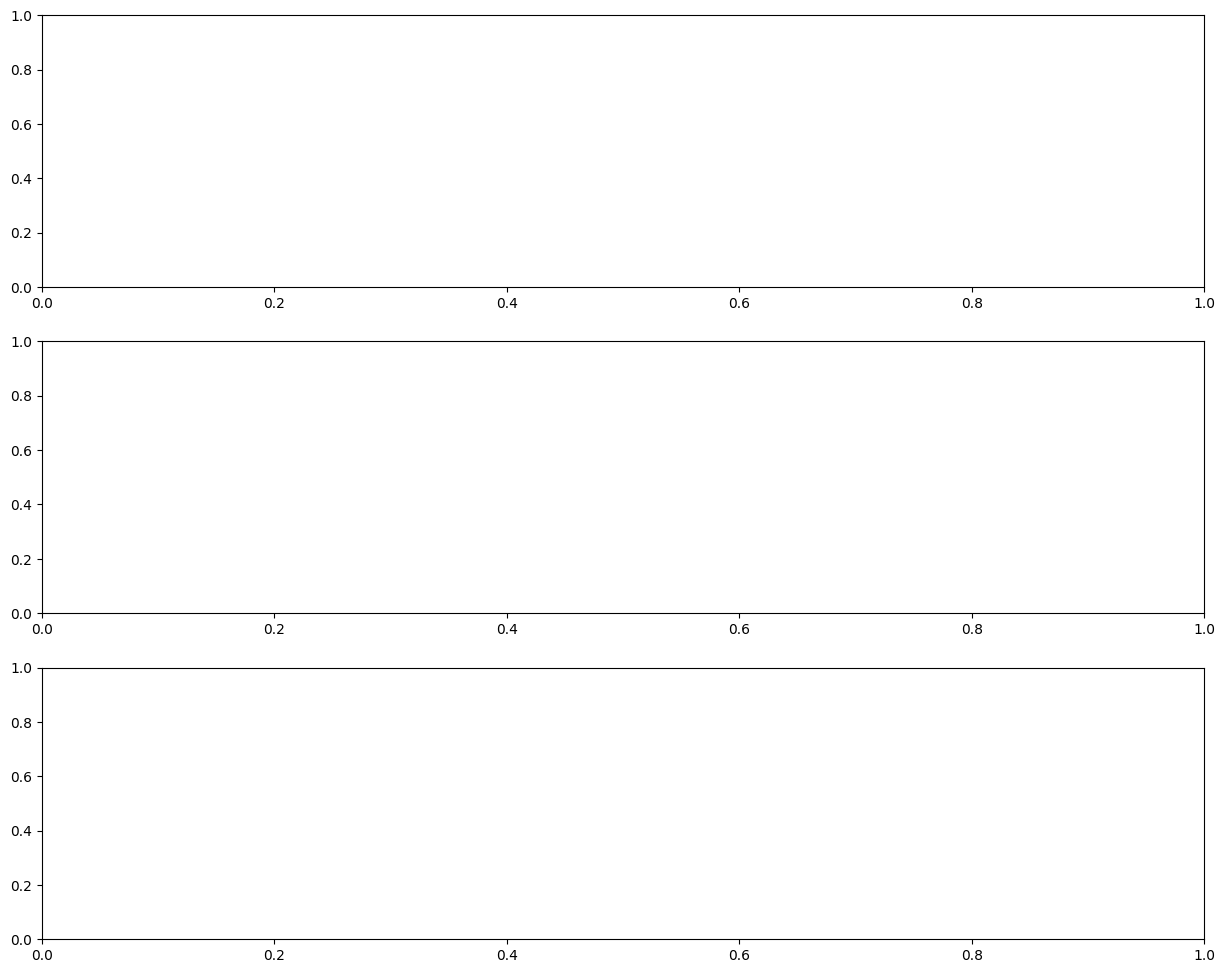

In [29]:
analysis_results = run_complete_pattern_analysis(
        X_train=data_full['X_train'],
        y_train=data_full['y_train'],
        y_test=data_full['y_test'],
        predictions_dict=preds_full,
        models_dict=models_full,
        cv_results_df=data_full['cv_results'],
        test_timestamps=test_df.index,
        feature_cols=data_full['feature_cols']
    )

## D. Evaluation with bias-variance tradeoff graph, model complexity vs error, ridge regularization graph

In [ ]:
from sklearn.base import BaseEstimator,RegressorMixin
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
class MLP_Wrapper(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_units=32, epochs=50, batch_size=32):
        self.hidden_units = hidden_units
        self.epochs = epochs
        self.batch_size = batch_size
        self.mlp_instance = None

    def fit(self, X, y):
        # Initialize MLP with correct input_dim (not input_shape)
        self.mlp_instance = MLP(
            input_dim=X.shape[1],
            hidden_units=self.hidden_units,
            epochs=self.epochs,
            batch_size=self.batch_size
        )
        # Use separate fit method
        self.mlp_instance.fit(X, y, verbose=0)
        return self

    def predict(self, X):
        if self.mlp_instance is None:
            raise RuntimeError("Model has not been fitted yet.")
        return self.mlp_instance.predict(X)


class LSTM_Wrapper(BaseEstimator, RegressorMixin):
    def __init__(self, units=32, epochs=50, batch_size=32):
        self.units = units
        self.epochs = epochs
        self.batch_size = batch_size
        self.lstm_instance = None

    def fit(self, X, y):
        # Reshape to (samples, timesteps=1, features)
        X_lstm = np.expand_dims(X, axis=1)
        input_shape = (1, X.shape[1])

        self.lstm_instance = LSTM_Model(
            input_shape=input_shape,
            units=self.units,
            epochs=self.epochs,
            batch_size=self.batch_size
        )
        # Use separate fit method
        self.lstm_instance.fit(X_lstm, y, verbose=0)
        return self

    def predict(self, X):
        if self.lstm_instance is None:
            raise RuntimeError("Model has not been fitted yet.")
        X_lstm = np.expand_dims(X, axis=1)
        return self.lstm_instance.predict(X_lstm)


class TemporalCNN_Wrapper(BaseEstimator, RegressorMixin):
    def __init__(self, filters=16, epochs=50, batch_size=32):
        self.filters = filters
        self.epochs = epochs
        self.batch_size = batch_size
        self.cnn_instance = None

    def fit(self, X, y):
        # Reshape to (samples, timesteps=1, features)
        X_cnn = np.expand_dims(X, axis=1)
        input_shape = (1, X.shape[1])

        self.cnn_instance = TemporalCNN(
            input_shape=input_shape,
            filters=self.filters,
            epochs=self.epochs,
            batch_size=self.batch_size
        )
        # Use separate fit method
        self.cnn_instance.fit(X_cnn, y, verbose=0)
        return self

    def predict(self, X):
        if self.cnn_instance is None:
            raise RuntimeError("Model has not been fitted yet.")
        X_cnn = np.expand_dims(X, axis=1)
        return self.cnn_instance.predict(X_cnn)

In [ ]:
# Part A - Step 3: Evaluation Tables 3-5 (Bias-Variance, Complexity vs Error, Ridge Regularization Impact)
# Bias-Variance diagnostics (train vs validation R^2, generalization gap)
def bias_variance_diagnostics(model, X_train, y_train, X_val, y_val):
    # Train model on full training set and evaluate on validation
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train, y_train)
    train_r2 = r2_score(y_train, model.predict(X_train))
    val_r2 = r2_score(y_val, model.predict(X_val))
    gen_gap = train_r2 - val_r2
    bias_indicator = "High bias" if train_r2 < 0.5 and val_r2 < 0.5 else "Low bias"
    variance_indicator = "High variance" if gen_gap > 0.1 else "Low variance"
    return {"Training R2": train_r2, "Validation R2": val_r2, "Bias indicator": bias_indicator,
            "Variance indicator": variance_indicator, "Generalization Gap": gen_gap}


In [ ]:
subsample_ratio = 0.3
N = int(len(data_full['X_train_scaled']) * subsample_ratio)

# ALL MODELS use scaled data
X_tr_sub_scaled  = data_full['X_train_scaled'][:N].copy()
y_tr_sub_scaled  = data_full['y_train_scaled'][:N].copy()
X_val_sub_scaled = data_full['X_train_scaled'][N:].copy()
y_val_sub_scaled = data_full['y_train_scaled'][N:].copy()

print(f"✓ Training subset: {X_tr_sub_scaled.shape}")
print(f"✓ Validation subset: {X_val_sub_scaled.shape}")
print(f"✓ All data is SCALED (StandardScaler)")

✓ Training subset: (10519, 41)
✓ Validation subset: (24545, 41)
✓ All data is SCALED (StandardScaler)



Training Linear Regression...

Training Ridge Regression...

Training Linear SVR...

Training Decision Tree...

Training Random Forest...

Training XGBoost...

ML MODELS - Complexity vs Error (ALL MODELS ON SCALED DATA):


,Model,Complexity,Train error,Val error,Overfitting Index,Complexity Level
0,Linear Regression,degree=1,3.546825e-03,6.925825e-02,-6.571142e-02,1
1,Linear Regression,degree=2,1.713828e-03,1.734005e+02,-1.733988e+02,2
2,Linear Regression,degree=3,4.908653e-05,9.317803e+08,-9.317803e+08,3
3,Ridge Regression,alpha=1e-05,3.546825e-03,6.925807e-02,-6.571125e-02,1
4,Ridge Regression,alpha=0.0001,3.546825e-03,6.925652e-02,-6.570969e-02,2
...,...,...,...,...,...,...
85,XGBoost,max_depth=400,1.897517e-07,5.945919e-03,-5.945729e-03,16
86,XGBoost,max_depth=600,1.897517e-07,5.945919e-03,-5.945729e-03,17
87,XGBoost,max_depth=800,1.897517e-07,5.945919e-03,-5.945729e-03,18
88,XGBoost,max_depth=1000,1.897517e-07,5.945919e-03,-5.945729e-03,19



ULTRA-LOW COMPLEXITY RESULTS:


,Model,Complexity,Train error,Val error,Overfitting Index,Complexity Level
0,Linear Regression,degree=1,3.546825e-03,6.925825e-02,-6.571142e-02,1
1,Linear Regression,degree=2,1.713828e-03,1.734005e+02,-1.733988e+02,2
2,Linear Regression,degree=3,4.908653e-05,9.317803e+08,-9.317803e+08,3
3,Ridge Regression,alpha=1e-05,3.546825e-03,6.925807e-02,-6.571125e-02,1
4,Ridge Regression,alpha=0.0001,3.546825e-03,6.925652e-02,-6.570969e-02,2
...,...,...,...,...,...,...
85,XGBoost,max_depth=400,1.897517e-07,5.945919e-03,-5.945729e-03,16
86,XGBoost,max_depth=600,1.897517e-07,5.945919e-03,-5.945729e-03,17
87,XGBoost,max_depth=800,1.897517e-07,5.945919e-03,-5.945729e-03,18
88,XGBoost,max_depth=1000,1.897517e-07,5.945919e-03,-5.945729e-03,19



✓ Results saved to 'ml_complexity_ultra_low_results.csv'

Generating plots...


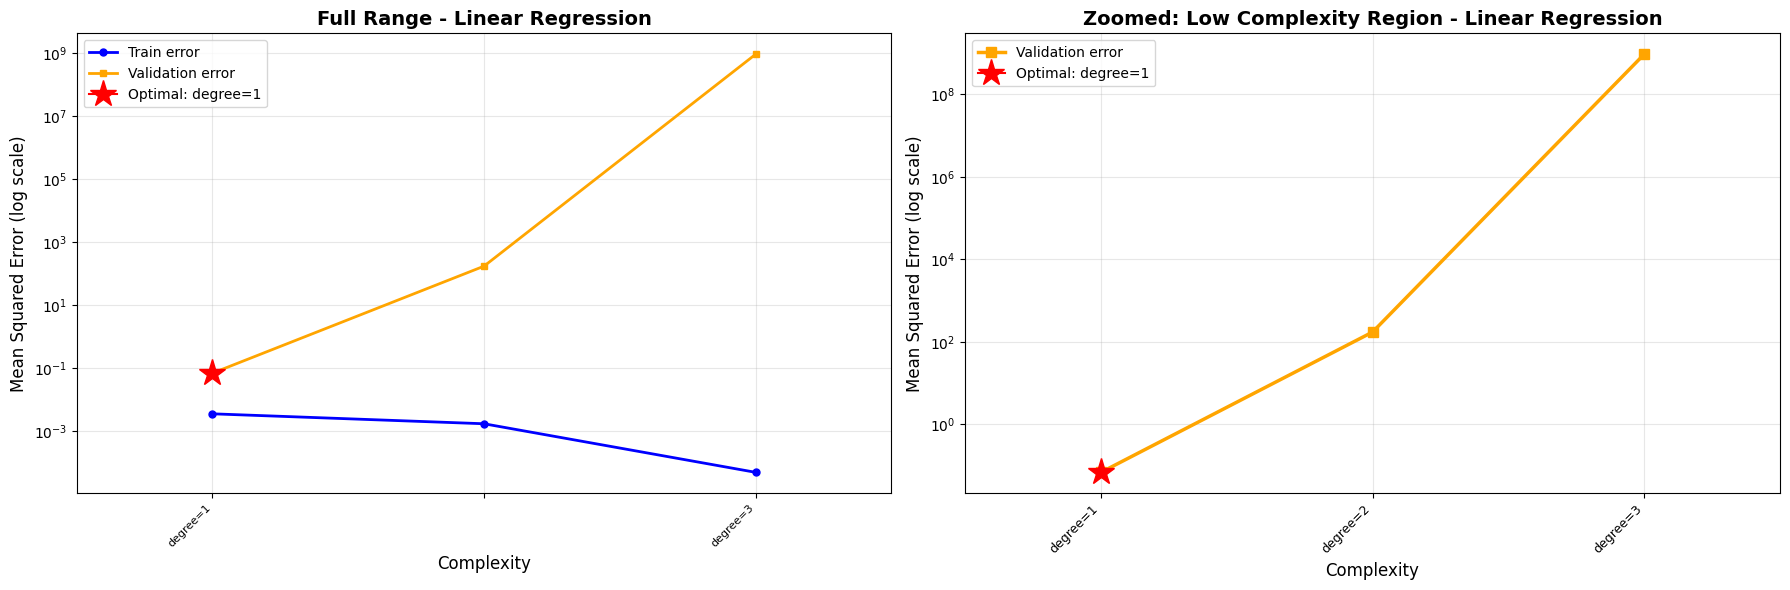

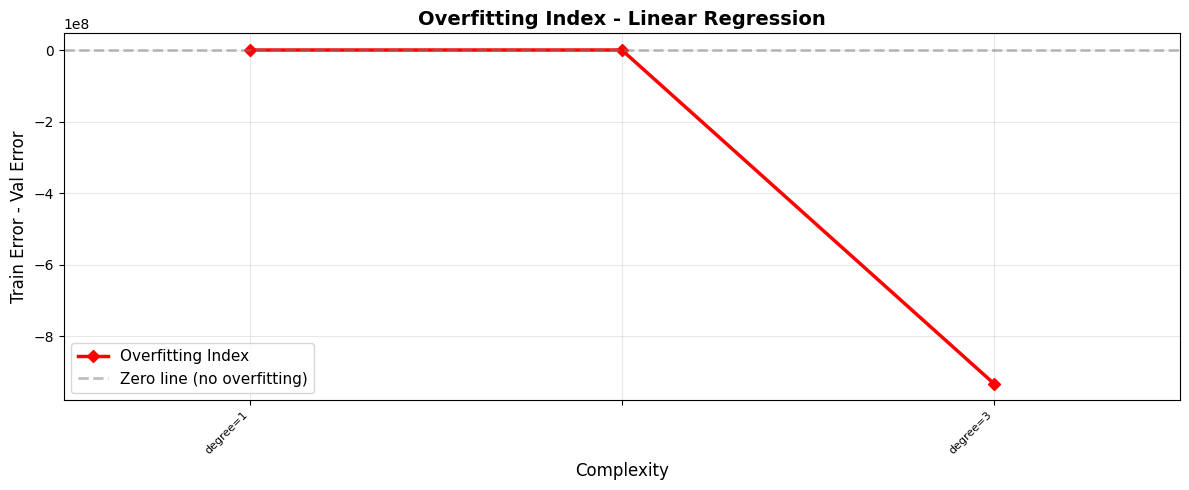


Linear Regression Analysis:
  Lowest complexity tested: degree=1
    Train Error: 0.003547
    Val Error: 0.069258
  Optimal configuration: degree=1
    Train Error: 0.003547
    Val Error: 0.069258
  Highest complexity tested: degree=3
    Train Error: 0.000049
    Val Error: 931780289.390225
    Overfitting Index: -931780289.390176
  U-shape detected: YES


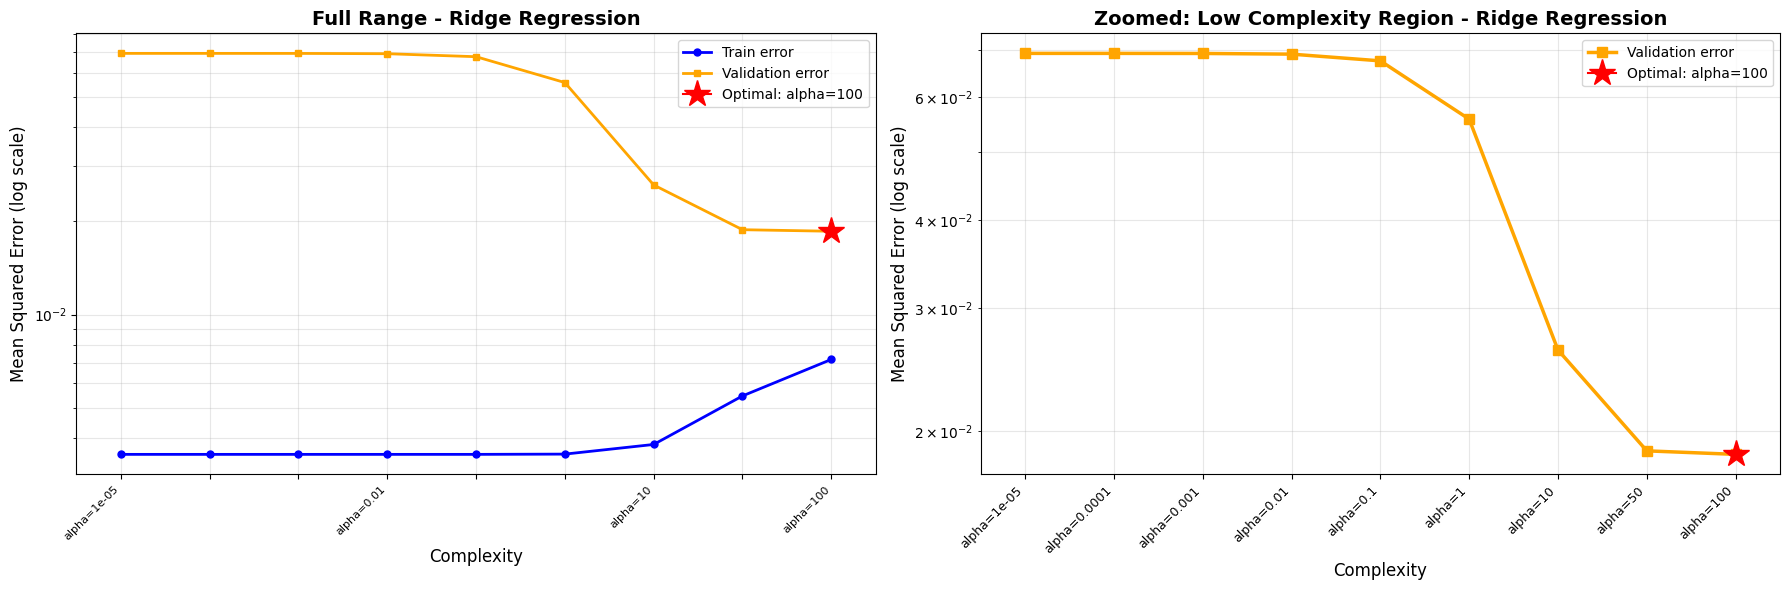

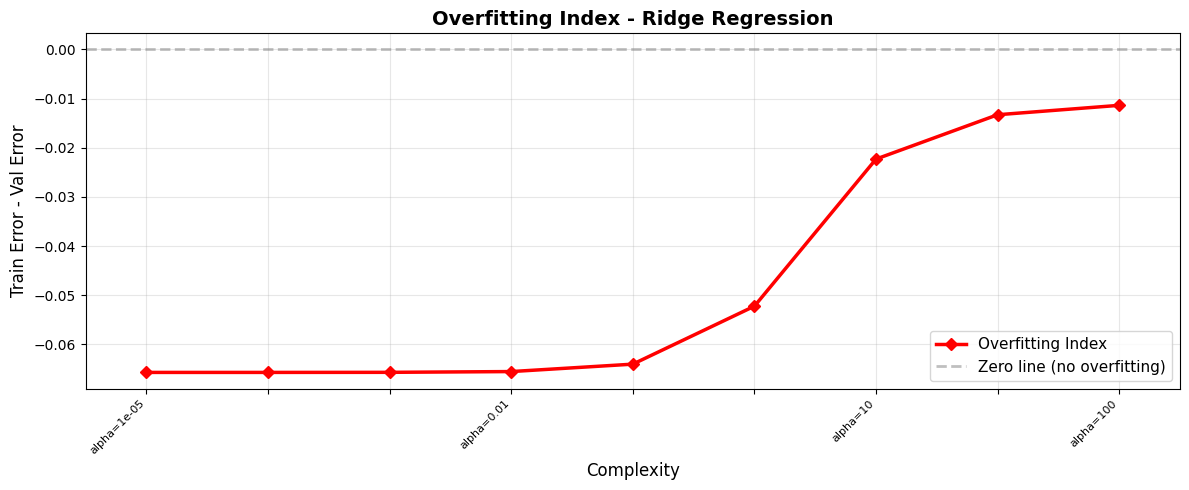


Ridge Regression Analysis:
  Lowest complexity tested: alpha=1e-05
    Train Error: 0.003547
    Val Error: 0.069258
  Optimal configuration: alpha=100
    Train Error: 0.007168
    Val Error: 0.018533
  Highest complexity tested: alpha=100
    Train Error: 0.007168
    Val Error: 0.018533
    Overfitting Index: -0.011365
  U-shape detected: PARTIAL


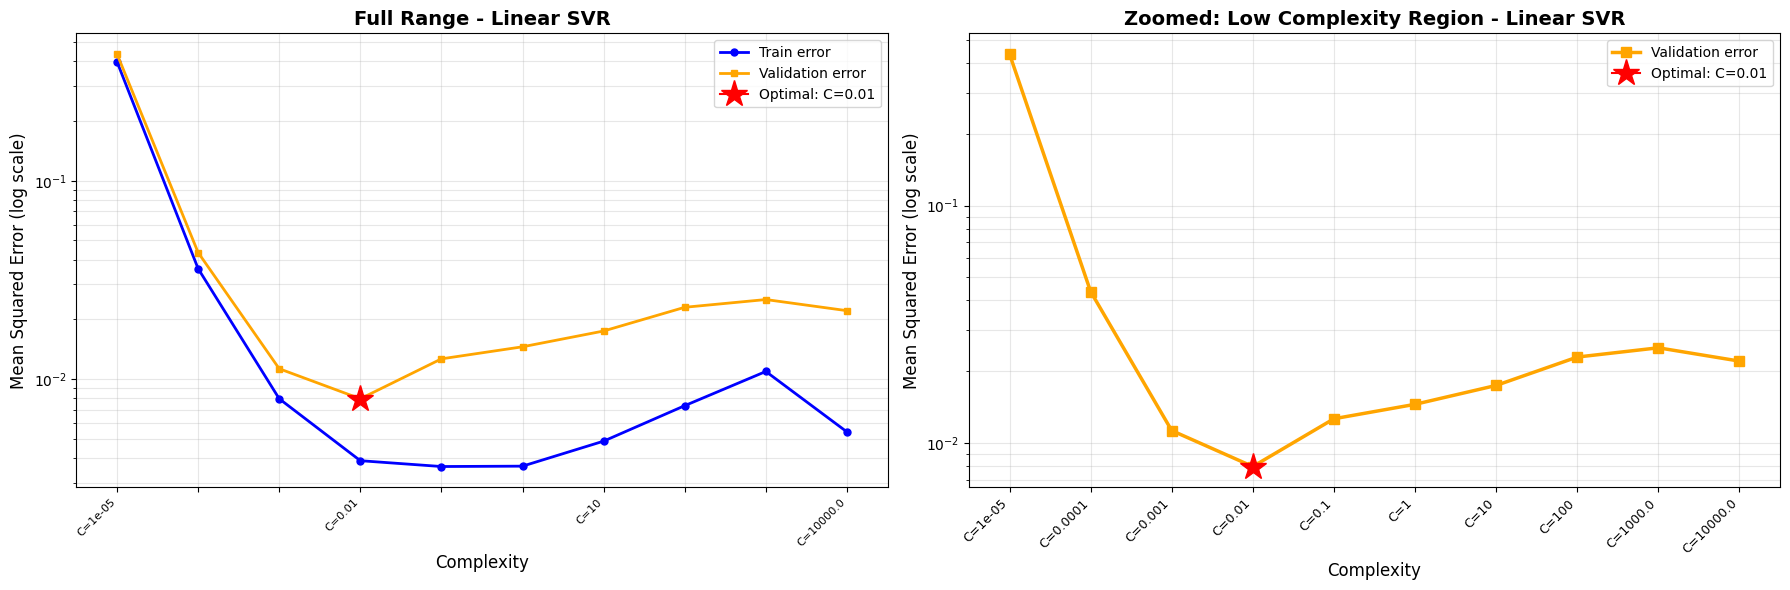

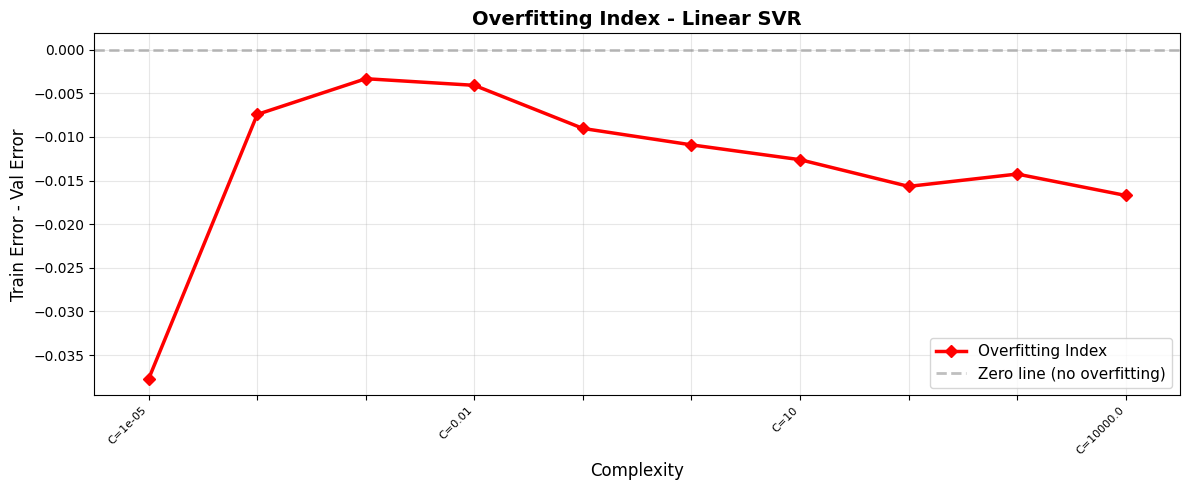


Linear SVR Analysis:
  Lowest complexity tested: C=1e-05
    Train Error: 0.398438
    Val Error: 0.436167
  Optimal configuration: C=0.01
    Train Error: 0.003871
    Val Error: 0.007947
  Highest complexity tested: C=10000.0
    Train Error: 0.005409
    Val Error: 0.022113
    Overfitting Index: -0.016704
  U-shape detected: YES


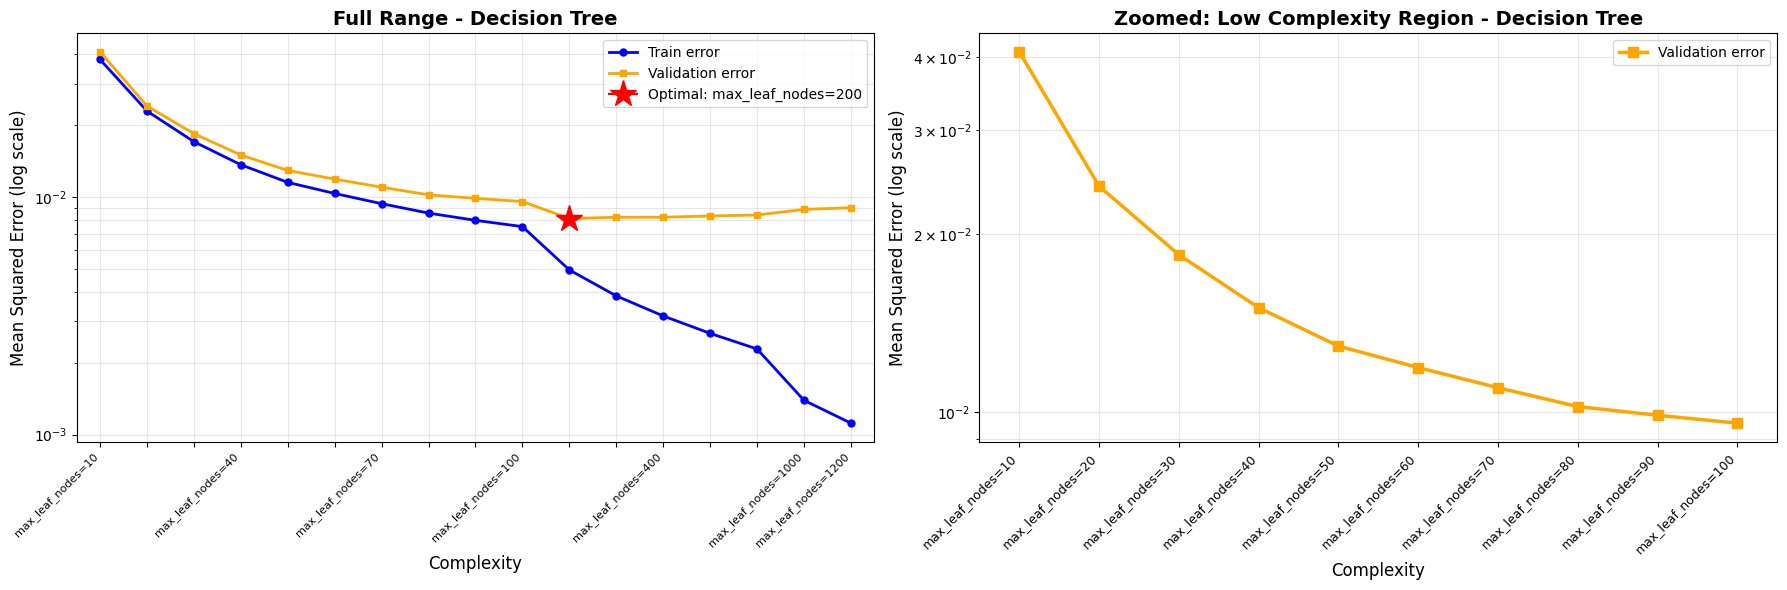

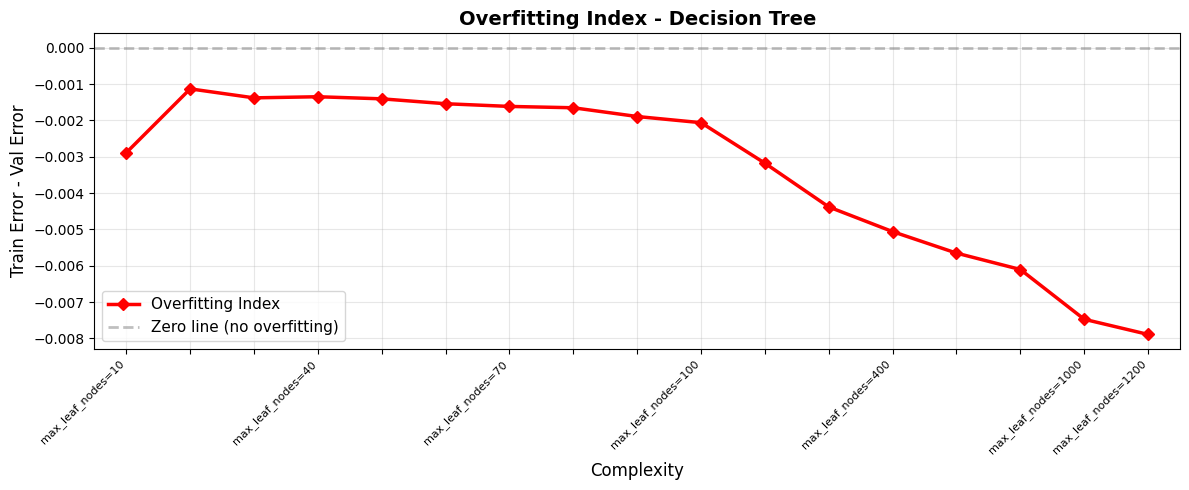


Decision Tree Analysis:
  Lowest complexity tested: max_leaf_nodes=10
    Train Error: 0.037887
    Val Error: 0.040776
  Optimal configuration: max_leaf_nodes=200
    Train Error: 0.004933
    Val Error: 0.008112
  Highest complexity tested: max_leaf_nodes=1200
    Train Error: 0.001118
    Val Error: 0.009008
    Overfitting Index: -0.007890
  U-shape detected: YES


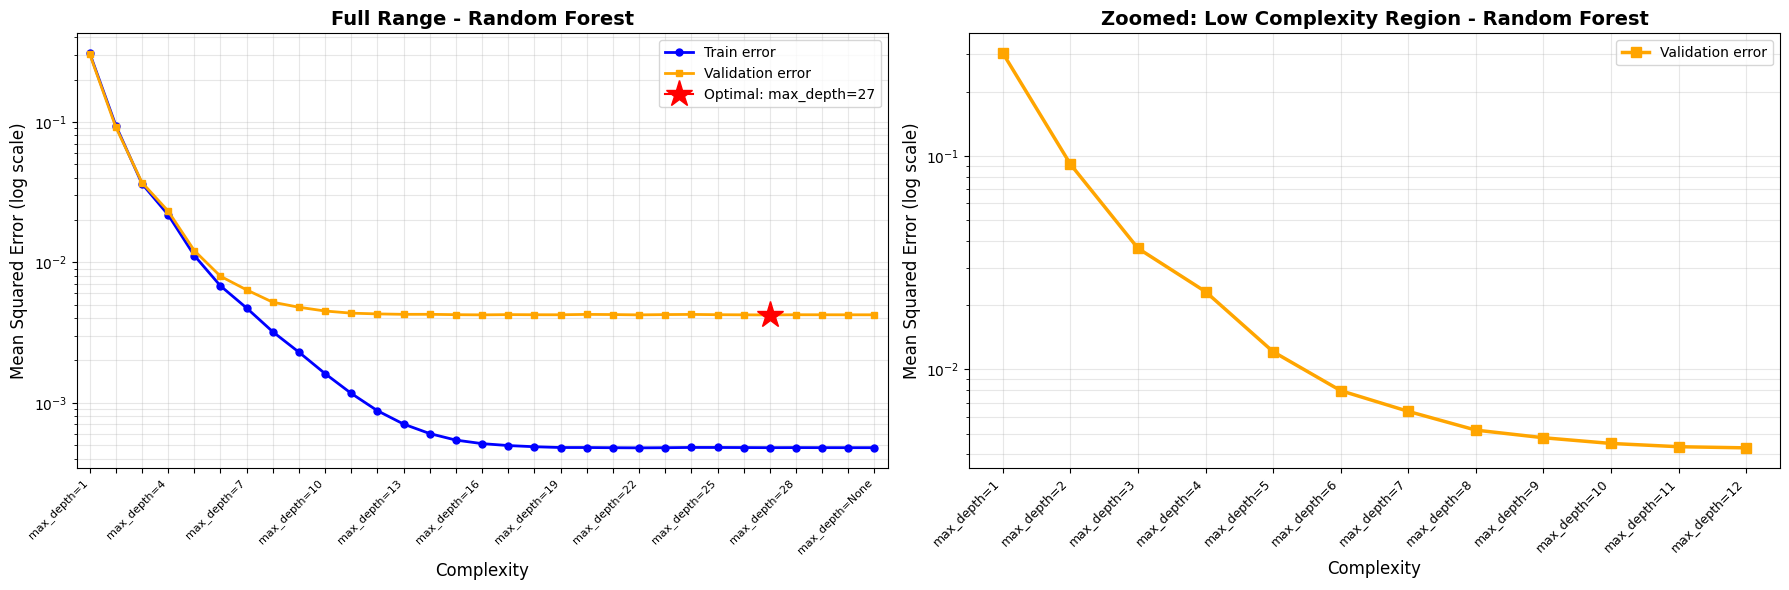

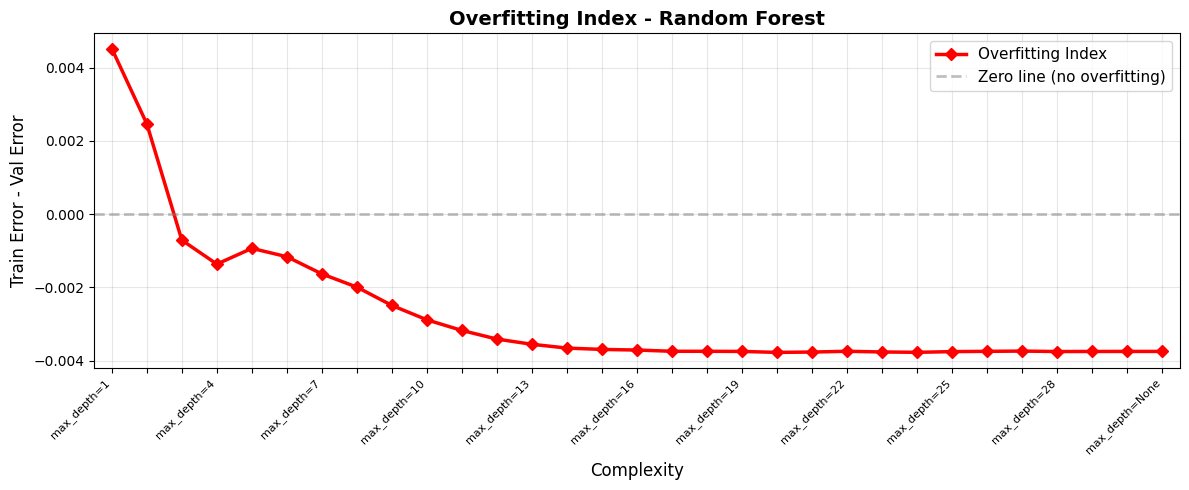


Random Forest Analysis:
  Lowest complexity tested: max_depth=1
    Train Error: 0.308884
    Val Error: 0.304365
  Optimal configuration: max_depth=27
    Train Error: 0.000479
    Val Error: 0.004219
  Highest complexity tested: max_depth=None
    Train Error: 0.000479
    Val Error: 0.004229
    Overfitting Index: -0.003750
  U-shape detected: PARTIAL


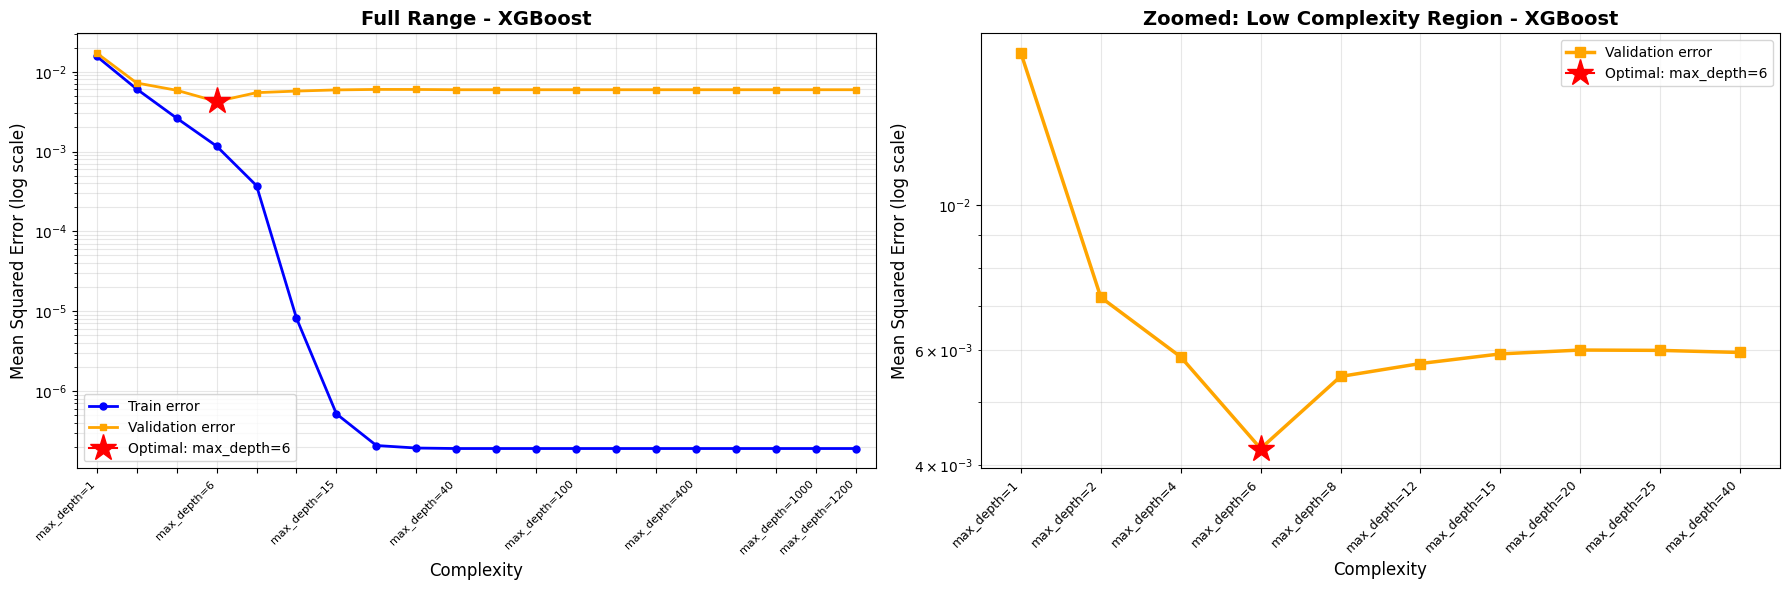

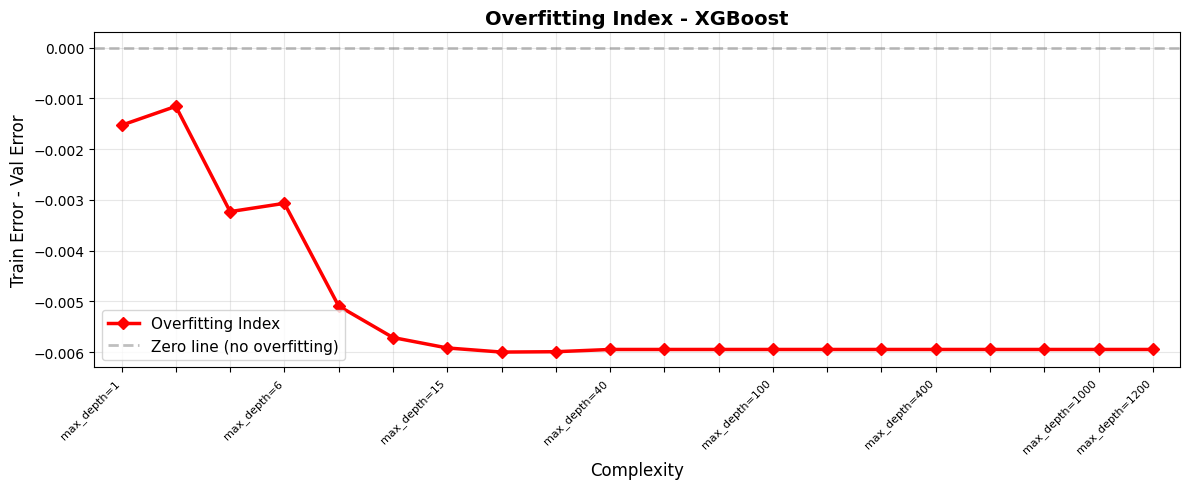


XGBoost Analysis:
  Lowest complexity tested: max_depth=1
    Train Error: 0.015577
    Val Error: 0.017107
  Optimal configuration: max_depth=6
    Train Error: 0.001169
    Val Error: 0.004236
  Highest complexity tested: max_depth=1200
    Train Error: 0.000000
    Val Error: 0.005946
    Overfitting Index: -0.005946
  U-shape detected: YES

✓ Ultra-low complexity analysis complete!

Key insights:
- If val error is HIGH at complexity=1-4: Clear underfitting (high bias)
- If val error DECREASES then INCREASES: Classic U-shaped curve
- If val error only DECREASES: Need even simpler models or less data


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

ml_model_configs = {
    "Linear Regression": {"degree": list(range(1, 4))},
    "Ridge Regression": {"alpha": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 50, 100]},
    "Linear SVR": {"C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1e3, 1e4]},
    "Decision Tree": {"max_leaf_nodes": [10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,1000,1200]},
    "Random Forest": {"max_depth": list(range(1, 31)) + [None]},
    "XGBoost": {"max_depth":[1,2,4,6,8,12,15,20,25,40,60,80,100,150,200,400,600,800,1000,1200]}
}

ml_complexity_rows = []

for model_name, param_dict in ml_model_configs.items():
    print(f"\nTraining {model_name}...")
    for param_name, values in param_dict.items():
        for val in values:
            # ALL models use SCALED data
            X_sub = X_tr_sub_scaled
            y_sub = y_tr_sub_scaled
            X_val_sub_local = X_val_sub_scaled
            y_val_sub_local = y_val_sub_scaled

            if model_name == "Decision Tree":
                model = DecisionTreeRegressor(max_leaf_nodes=val, random_state=42)

            elif model_name == "Random Forest":
                model = RandomForestRegressor(max_depth=val, n_estimators=50, random_state=42, n_jobs=-1)

            elif model_name == "XGBoost":
                model = XGBRegressor(
                    max_depth=val,
                    n_estimators=50,
                    tree_method="hist",
                    random_state=42,
                    n_jobs=-1
                )

            elif model_name == "Linear Regression":
                # For polynomial features on SCALED data
                poly = PolynomialFeatures(degree=val, include_bias=False)
                X_sub_poly = poly.fit_transform(X_sub)
                X_val_sub_local_poly = poly.transform(X_val_sub_local)
                model = LinearRegression()
                model.fit(X_sub_poly, y_sub)
                train_err = mean_squared_error(y_sub, model.predict(X_sub_poly))
                val_err = mean_squared_error(y_val_sub_local, model.predict(X_val_sub_local_poly))
                ml_complexity_rows.append({
                    "Model": model_name,
                    "Complexity": f"{param_name}={val}",
                    "Train error": train_err,
                    "Val error": val_err,
                    "Overfitting Index": train_err - val_err
                })
                continue

            elif model_name == "Ridge Regression":
                model = Ridge(alpha=val)

            elif model_name == "Linear SVR":
                model = LinearSVR(C=val, max_iter=5000)

            # Fit model on SCALED data
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model.fit(X_sub, y_sub)

            # Calculate errors on SCALED data
            train_err = mean_squared_error(y_sub, model.predict(X_sub))
            val_err = mean_squared_error(y_val_sub_local, model.predict(X_val_sub_local))

            ml_complexity_rows.append({
                "Model": model_name,
                "Complexity": f"{param_name}={val}",
                "Train error": train_err,
                "Val error": val_err,
                "Overfitting Index": train_err - val_err
            })

ml_cm_df = pd.DataFrame(ml_complexity_rows)
ml_cm_df["Complexity Level"] = ml_cm_df.groupby("Model").cumcount() + 1

print("\n" + "="*80)
print("ML MODELS - Complexity vs Error (ALL MODELS ON SCALED DATA):")
print("="*80)
display(ml_cm_df)

# Results
print("\n" + "="*80)
print("ULTRA-LOW COMPLEXITY RESULTS:")
print("="*80)
display(ml_cm_df)

# Save
ml_cm_df.to_csv('ml_complexity_ultra_low_results.csv', index=False)
print("\n✓ Results saved to 'ml_complexity_ultra_low_results.csv'")
# Enhanced plotting with focus on left side
print("\nGenerating plots...")
for model in ml_cm_df["Model"].unique():
    temp = ml_cm_df[ml_cm_df["Model"] == model]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Left plot: Full range
    ax1.plot(temp["Complexity Level"], temp["Train error"],
            marker='o', linestyle='-', linewidth=2, markersize=5, label='Train error', color='blue')
    ax1.plot(temp["Complexity Level"], temp["Val error"],
            marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation error', color='orange')

    # Mark optimal point
    optimal_idx = temp["Val error"].idxmin()
    optimal_level = temp.loc[optimal_idx, "Complexity Level"]
    optimal_val = temp.loc[optimal_idx, "Val error"]
    ax1.plot(optimal_level, optimal_val, marker='*', markersize=20,
            color='red', label=f'Optimal: {temp.loc[optimal_idx, "Complexity"]}', zorder=5)

    # Adjust x-axis labels - show every 3rd label to avoid crowding
    tick_positions = temp["Complexity Level"].values
    tick_labels = temp["Complexity"].values
    show_labels = [label if i % 3 == 0 or i == len(tick_labels)-1 else ''
                   for i, label in enumerate(tick_labels)]

    ax1.set_xticks(tick_positions)
    ax1.set_xticklabels(show_labels, rotation=45, ha='right', fontsize=8)
    ax1.set_xlim(0.5, temp["Complexity Level"].max() + 0.5)
    ax1.set_yscale('log')
    ax1.set_title(f"Full Range - {model}", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Complexity", fontsize=12)
    ax1.set_ylabel("Mean Squared Error (log scale)", fontsize=12)
    ax1.legend(fontsize=10, loc='best')
    ax1.grid(True, alpha=0.3, which='both')

    # Right plot: Zoomed into low complexity (first 40% of data points)
    zoom_point = max(10, int(len(temp) * 0.4))
    temp_zoom = temp.iloc[:zoom_point]

    # ax2.plot(temp_zoom["Complexity Level"], temp_zoom["Train error"],
    #         marker='o', linestyle='-', linewidth=2.5, markersize=7, label='Train error', color='blue')
    ax2.plot(temp_zoom["Complexity Level"], temp_zoom["Val error"],
            marker='s', linestyle='-', linewidth=2.5, markersize=7, label='Validation error', color='orange')

    # Mark optimal if in zoom range
    if optimal_level <= zoom_point:
        ax2.plot(optimal_level, optimal_val, marker='*', markersize=20,
                color='red', label=f'Optimal: {temp.loc[optimal_idx, "Complexity"]}', zorder=5)

    ax2.set_xticks(temp_zoom["Complexity Level"])
    ax2.set_xticklabels(temp_zoom["Complexity"], rotation=45, ha='right', fontsize=9)
    ax2.set_xlim(0.5, temp_zoom["Complexity Level"].max() + 0.5)
    ax2.set_yscale('log')
    ax2.set_title(f"Zoomed: Low Complexity Region - {model}", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Complexity", fontsize=12)
    ax2.set_ylabel("Mean Squared Error (log scale)", fontsize=12)
    ax2.legend(fontsize=10, loc='best')
    ax2.grid(True, alpha=0.3, which='both')

    plt.tight_layout()
    plt.show()

    # Overfitting Index plot
    plt.figure(figsize=(12, 5))
    plt.plot(temp["Complexity Level"], temp["Overfitting Index"],
             marker='D', linestyle='-', linewidth=2.5, markersize=6, color='red', label='Overfitting Index')
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=2, label='Zero line (no overfitting)')
    plt.xticks(tick_positions, show_labels, rotation=45, ha='right', fontsize=8)
    plt.xlim(0.5, temp["Complexity Level"].max() + 0.5)
    plt.title(f"Overfitting Index - {model}", fontsize=14, fontweight='bold')
    plt.xlabel("Complexity", fontsize=12)
    plt.ylabel("Train Error - Val Error", fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print analysis
    print(f"\n{'='*60}")
    print(f"{model} Analysis:")
    print(f"{'='*60}")
    print(f"  Lowest complexity tested: {temp.iloc[0]['Complexity']}")
    print(f"    Train Error: {temp.iloc[0]['Train error']:.6f}")
    print(f"    Val Error: {temp.iloc[0]['Val error']:.6f}")
    print(f"  Optimal configuration: {temp.loc[optimal_idx, 'Complexity']}")
    print(f"    Train Error: {temp.loc[optimal_idx, 'Train error']:.6f}")
    print(f"    Val Error: {optimal_val:.6f}")
    print(f"  Highest complexity tested: {temp.iloc[-1]['Complexity']}")
    print(f"    Train Error: {temp.iloc[-1]['Train error']:.6f}")
    print(f"    Val Error: {temp.iloc[-1]['Val error']:.6f}")
    print(f"    Overfitting Index: {temp.iloc[-1]['Overfitting Index']:.6f}")
    print(f"  U-shape detected: {'YES' if temp.iloc[-1]['Val error'] > optimal_val * 1.1 else 'PARTIAL'}")

print("\n" + "="*80)
print("✓ Ultra-low complexity analysis complete!")
print("="*80)
print("\nKey insights:")
print("- If val error is HIGH at complexity=1-4: Clear underfitting (high bias)")
print("- If val error DECREASES then INCREASES: Classic U-shaped curve")
print("- If val error only DECREASES: Need even simpler models or less data")




In [ ]:
def get_epochs_for_complexity(complexity_level, total_levels):
    """
    Much more aggressive epoch scheduling to force overfitting
    """
    progress = complexity_level / total_levels

    if progress < 0.2:
        return 10   # Simple models - minimal training
    elif progress < 0.5:
        return 30   # Medium models
    else:
        return 100  # ← High complexity models MUST overfit with this many epochs


Training MLP...
  Progress: 1/29 - hidden_units=1
  Progress: 2/29 - hidden_units=2
  Progress: 3/29 - hidden_units=3
  Progress: 4/29 - hidden_units=4
  Progress: 5/29 - hidden_units=6
  Progress: 6/29 - hidden_units=8
  Progress: 7/29 - hidden_units=12
  Progress: 8/29 - hidden_units=16
  Progress: 9/29 - hidden_units=20
  Progress: 10/29 - hidden_units=24
  Progress: 11/29 - hidden_units=32
  Progress: 12/29 - hidden_units=40
  Progress: 13/29 - hidden_units=48
  Progress: 14/29 - hidden_units=64
  Progress: 15/29 - hidden_units=80
  Progress: 16/29 - hidden_units=96
  Progress: 17/29 - hidden_units=128
  Progress: 18/29 - hidden_units=160
  Progress: 19/29 - hidden_units=192
  Progress: 20/29 - hidden_units=256
  Progress: 21/29 - hidden_units=320
  Progress: 22/29 - hidden_units=384
  Progress: 23/29 - hidden_units=512
  Progress: 24/29 - hidden_units=768
  Progress: 25/29 - hidden_units=1024
  Progress: 26/29 - hidden_units=1536
  Progress: 27/29 - hidden_units=2048
  Progress: 

,Model,Complexity,Train error,Val error,Overfitting Index,Complexity Level
0,MLP,hidden_units=1,0.020450,1.389963,-1.369513,1
1,MLP,hidden_units=2,0.014349,0.637153,-0.622804,2
2,MLP,hidden_units=3,0.019631,0.465514,-0.445883,3
3,MLP,hidden_units=4,0.009966,0.135125,-0.125159,4
4,MLP,hidden_units=6,0.010844,0.661149,-0.650305,5
...,...,...,...,...,...,...
71,Temporal CNN,filters=256,0.003442,0.024891,-0.021449,20
72,Temporal CNN,filters=384,0.003999,0.027842,-0.023843,21
73,Temporal CNN,filters=512,0.003963,0.025400,-0.021436,22
74,Temporal CNN,filters=768,0.005088,0.025065,-0.019977,23



✓ Results saved to 'nn_complexity_ultra_low_results.csv'

Generating plots...


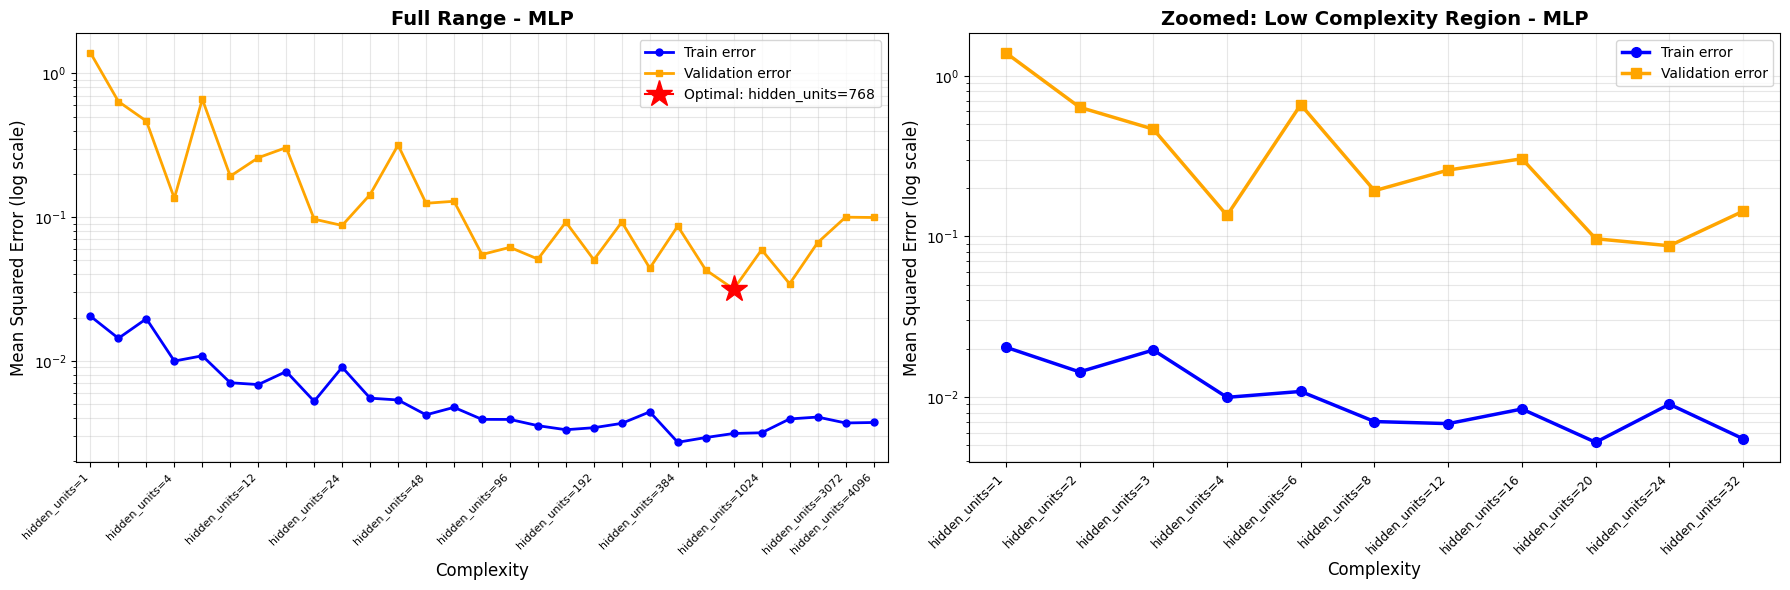

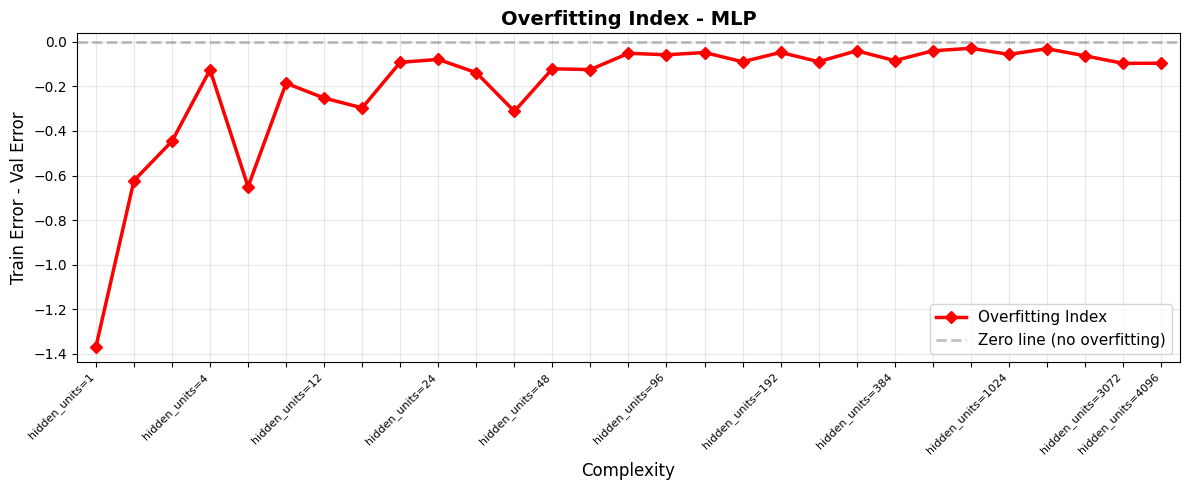


MLP Analysis:
  Lowest complexity tested: hidden_units=1
    Train Error: 0.020450
    Val Error: 1.389963
  Optimal configuration: hidden_units=768
    Train Error: 0.003124
    Val Error: 0.031555
  Highest complexity tested: hidden_units=4096
    Train Error: 0.003725
    Val Error: 0.099402
    Overfitting Index: -0.095677
  U-shape detected: YES


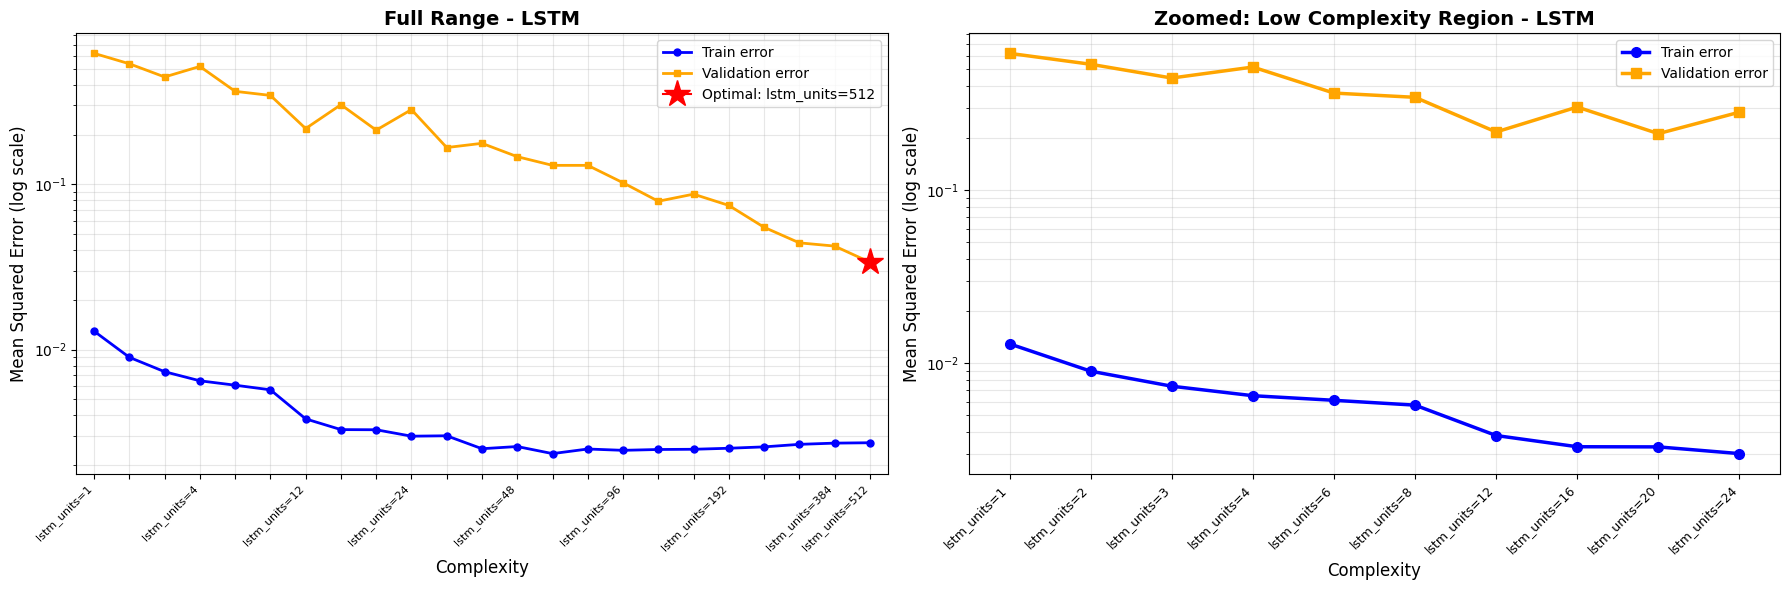

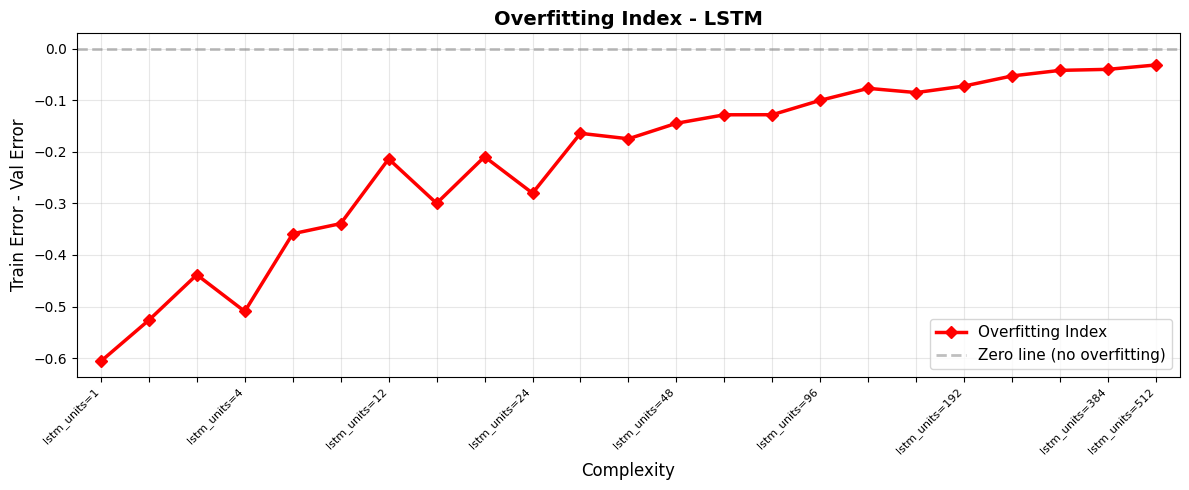


LSTM Analysis:
  Lowest complexity tested: lstm_units=1
    Train Error: 0.012937
    Val Error: 0.619221
  Optimal configuration: lstm_units=512
    Train Error: 0.002737
    Val Error: 0.033815
  Highest complexity tested: lstm_units=512
    Train Error: 0.002737
    Val Error: 0.033815
    Overfitting Index: -0.031078
  U-shape detected: PARTIAL


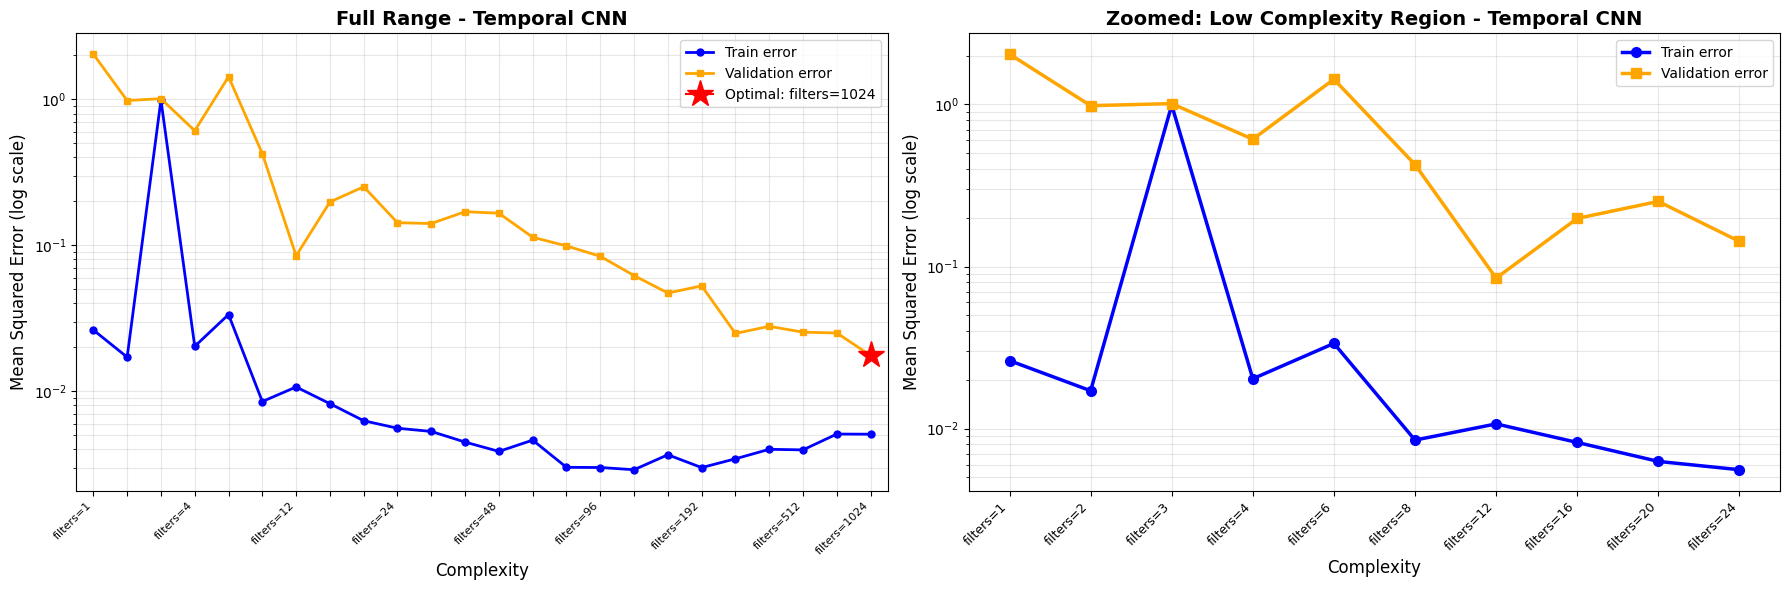

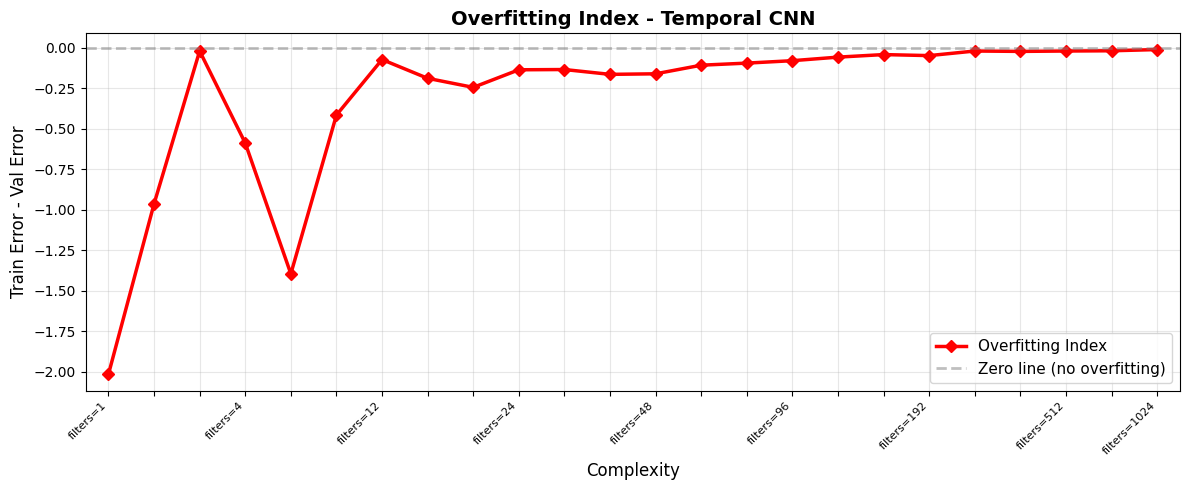


Temporal CNN Analysis:
  Lowest complexity tested: filters=1
    Train Error: 0.026277
    Val Error: 2.042503
  Optimal configuration: filters=1024
    Train Error: 0.005076
    Val Error: 0.017575
  Highest complexity tested: filters=1024
    Train Error: 0.005076
    Val Error: 0.017575
    Overfitting Index: -0.012499
  U-shape detected: PARTIAL

✓ Ultra-low complexity analysis complete!

Key insights:
- If val error is HIGH at complexity=1-4: Clear underfitting (high bias)
- If val error DECREASES then INCREASES: Classic U-shaped curve
- If val error only DECREASES: Need even simpler models or less data


In [ ]:
nn_model_configs = {
    # MLP: Start from 1 hidden unit
    "MLP": {"hidden_units": [1, 2, 3, 4, 6, 8, 12, 16, 20, 24, 32, 40, 48, 64, 80, 96,
                        128, 160, 192, 256, 320, 384, 512, 768, 1024,
                        1536, 2048, 3072, 4096] },

    # LSTM: Start from 1 unit
    "LSTM": {"lstm_units": [1, 2, 3, 4, 6, 8, 12, 16, 20, 24, 32, 40, 48, 64, 80, 96,
                      128, 160, 192, 256, 320, 384, 512]},

    # Temporal CNN: Start from 1 filter
    "Temporal CNN": {"filters": [1, 2, 3, 4, 6, 8, 12, 16, 20, 24, 32, 40, 48, 64, 80, 96,
                   128, 160, 192, 256, 384, 512, 768, 1024]}
}

nn_complexity_rows = []

for model_name, param_dict in nn_model_configs.items():
    print(f"\nTraining {model_name}...")
    for param_name, values in param_dict.items():
        for i, val in enumerate(values, 1):
            print(f"  Progress: {i}/{len(values)} - {param_name}={val}")

            X_sub, y_sub = X_tr_sub_scaled, y_tr_sub_scaled
            X_val_sub_local, y_val_sub_local = X_val_sub_scaled, y_val_sub_scaled

            epochs = 10

            if model_name == "MLP":
                model = MLP_Wrapper(hidden_units=val, epochs=epochs)
            elif model_name == "LSTM":
                model = LSTM_Wrapper(units=val, epochs=epochs)
            elif model_name == "Temporal CNN":
                model = TemporalCNN_Wrapper(filters=val, epochs=epochs)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model.fit(X_sub, y_sub)

            train_err = mean_squared_error(y_sub, model.predict(X_sub))
            val_err = mean_squared_error(y_val_sub_local, model.predict(X_val_sub_local))

            nn_complexity_rows.append({
                "Model": model_name,
                "Complexity": f"{param_name}={val}",
                "Train error": train_err,
                "Val error": val_err,
                "Overfitting Index": train_err - val_err
            })

# Results
nn_cm_df = pd.DataFrame(nn_complexity_rows)
nn_cm_df["Complexity Level"] = nn_cm_df.groupby("Model").cumcount() + 1

print("\n" + "="*80)
print("ULTRA-LOW COMPLEXITY RESULTS:")
print("="*80)
display(nn_cm_df)

# Save
nn_cm_df.to_csv('nn_complexity_ultra_low_results.csv', index=False)
print("\n✓ Results saved to 'nn_complexity_ultra_low_results.csv'")

# Enhanced plotting with focus on left side
print("\nGenerating plots...")
for model in nn_cm_df["Model"].unique():
    temp = nn_cm_df[nn_cm_df["Model"] == model]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Left plot: Full range
    ax1.plot(temp["Complexity Level"], temp["Train error"],
            marker='o', linestyle='-', linewidth=2, markersize=5, label='Train error', color='blue')
    ax1.plot(temp["Complexity Level"], temp["Val error"],
            marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation error', color='orange')

    # Mark optimal point
    optimal_idx = temp["Val error"].idxmin()
    optimal_level = temp.loc[optimal_idx, "Complexity Level"]
    optimal_val = temp.loc[optimal_idx, "Val error"]
    ax1.plot(optimal_level, optimal_val, marker='*', markersize=20,
            color='red', label=f'Optimal: {temp.loc[optimal_idx, "Complexity"]}', zorder=5)

    # Adjust x-axis labels - show every 3rd label to avoid crowding
    tick_positions = temp["Complexity Level"].values
    tick_labels = temp["Complexity"].values
    show_labels = [label if i % 3 == 0 or i == len(tick_labels)-1 else ''
                   for i, label in enumerate(tick_labels)]

    ax1.set_xticks(tick_positions)
    ax1.set_xticklabels(show_labels, rotation=45, ha='right', fontsize=8)
    ax1.set_xlim(0.5, temp["Complexity Level"].max() + 0.5)
    ax1.set_yscale('log')
    ax1.set_title(f"Full Range - {model}", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Complexity", fontsize=12)
    ax1.set_ylabel("Mean Squared Error (log scale)", fontsize=12)
    ax1.legend(fontsize=10, loc='best')
    ax1.grid(True, alpha=0.3, which='both')

    # Right plot: Zoomed into low complexity (first 40% of data points)
    zoom_point = max(10, int(len(temp) * 0.4))
    temp_zoom = temp.iloc[:zoom_point]

    ax2.plot(temp_zoom["Complexity Level"], temp_zoom["Train error"],
            marker='o', linestyle='-', linewidth=2.5, markersize=7, label='Train error', color='blue')
    ax2.plot(temp_zoom["Complexity Level"], temp_zoom["Val error"],
            marker='s', linestyle='-', linewidth=2.5, markersize=7, label='Validation error', color='orange')

    # Mark optimal if in zoom range
    if optimal_level <= zoom_point:
        ax2.plot(optimal_level, optimal_val, marker='*', markersize=20,
                color='red', label=f'Optimal: {temp.loc[optimal_idx, "Complexity"]}', zorder=5)

    ax2.set_xticks(temp_zoom["Complexity Level"])
    ax2.set_xticklabels(temp_zoom["Complexity"], rotation=45, ha='right', fontsize=9)
    ax2.set_xlim(0.5, temp_zoom["Complexity Level"].max() + 0.5)
    ax2.set_yscale('log')
    ax2.set_title(f"Zoomed: Low Complexity Region - {model}", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Complexity", fontsize=12)
    ax2.set_ylabel("Mean Squared Error (log scale)", fontsize=12)
    ax2.legend(fontsize=10, loc='best')
    ax2.grid(True, alpha=0.3, which='both')

    plt.tight_layout()
    plt.show()

    # Overfitting Index plot
    plt.figure(figsize=(12, 5))
    plt.plot(temp["Complexity Level"], temp["Overfitting Index"],
             marker='D', linestyle='-', linewidth=2.5, markersize=6, color='red', label='Overfitting Index')
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=2, label='Zero line (no overfitting)')
    plt.xticks(tick_positions, show_labels, rotation=45, ha='right', fontsize=8)
    plt.xlim(0.5, temp["Complexity Level"].max() + 0.5)
    plt.title(f"Overfitting Index - {model}", fontsize=14, fontweight='bold')
    plt.xlabel("Complexity", fontsize=12)
    plt.ylabel("Train Error - Val Error", fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print analysis
    print(f"\n{'='*60}")
    print(f"{model} Analysis:")
    print(f"{'='*60}")
    print(f"  Lowest complexity tested: {temp.iloc[0]['Complexity']}")
    print(f"    Train Error: {temp.iloc[0]['Train error']:.6f}")
    print(f"    Val Error: {temp.iloc[0]['Val error']:.6f}")
    print(f"  Optimal configuration: {temp.loc[optimal_idx, 'Complexity']}")
    print(f"    Train Error: {temp.loc[optimal_idx, 'Train error']:.6f}")
    print(f"    Val Error: {optimal_val:.6f}")
    print(f"  Highest complexity tested: {temp.iloc[-1]['Complexity']}")
    print(f"    Train Error: {temp.iloc[-1]['Train error']:.6f}")
    print(f"    Val Error: {temp.iloc[-1]['Val error']:.6f}")
    print(f"    Overfitting Index: {temp.iloc[-1]['Overfitting Index']:.6f}")
    print(f"  U-shape detected: {'YES' if temp.iloc[-1]['Val error'] > optimal_val * 1.1 else 'PARTIAL'}")

print("\n" + "="*80)
print("✓ Ultra-low complexity analysis complete!")
print("="*80)
print("\nKey insights:")
print("- If val error is HIGH at complexity=1-4: Clear underfitting (high bias)")
print("- If val error DECREASES then INCREASES: Classic U-shaped curve")
print("- If val error only DECREASES: Need even simpler models or less data")




In [ ]:
# error analysis

In [ ]:
# feature importance

## Select winner models

# Part B

## Comprehensive preprocessing

In [ ]:
# ============================================================================
# CONFIGURATION
# ============================================================================

OPTIMAL_FILTERS = 384 # From ultra-low complexity analysis
EPOCHS = 50
BATCH_SIZE = 32

# Part A already includes:
# - Lag features: [1, 2, 3, 6, 12, 24] hours
# - Cyclical encoding: hour, day, month (sin/cos)

# Part B adds:
ROLLING_WINDOWS = [3, 6, 12, 24]  # Short-term trend capture
WEATHER_PAIRS = [  # Domain knowledge interactions
    ('temperature_2m', 'relativehumidity_2m'),
    ('temperature_2m', 'wind_speed_10m'),
    ('wind_speed_10m', 'wind_direction_10m')
]

print(f"\nModel Configuration:")
print(f"  Filters: {OPTIMAL_FILTERS}")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def clip_scaled_features(X_scaled, clip_value=5.0):
    """Clip scaled features to prevent extreme predictions"""
    X_clipped = np.clip(X_scaled, -clip_value, clip_value)
    n_clipped = np.sum(np.abs(X_scaled) > clip_value)
    if n_clipped > 0:
        pct_clipped = 100 * n_clipped / X_scaled.size
        print(f"  Clipped {n_clipped} values ({pct_clipped:.2f}%) to ±{clip_value}")
    return X_clipped

def create_rolling_features(df, target_col, windows):
    """Create rolling statistics features"""
    df_out = df.copy()
    for window in windows:
        df_out[f'{target_col}_rolling_mean_{window}'] = df_out[target_col].rolling(window=window).mean()
        df_out[f'{target_col}_rolling_std_{window}'] = df_out[target_col].rolling(window=window).std()
    return df_out

def create_interaction_features(df, feature_pairs):
    """Create interaction terms between feature pairs"""
    df_out = df.copy()
    for feat1, feat2 in feature_pairs:
        if feat1 in df_out.columns and feat2 in df_out.columns:
            df_out[f'{feat1}_x_{feat2}'] = df_out[feat1] * df_out[feat2]
    return df_out

# ============================================================================
# SETUP GLOBAL TARGET SCALER
# ============================================================================

print("\n" + "="*80)
print("SETTING UP GLOBAL TARGET SCALER")
print("="*80)

# Use the same scaler as Part A
scaler_y_global = StandardScaler()
scaler_y_global.fit(y_train_min.values.reshape(-1, 1))

print(f"✓ Target scaler fitted on {len(y_train_min)} samples")
print(f"  Mean: {scaler_y_global.mean_[0]:.2f} MW")
print(f"  Std: {scaler_y_global.scale_[0]:.2f} MW")

# Prepare dataframes with full context for feature engineering
# Note: train_df_clipped and test_df already exist from Part A
train_df_fe = train_df_clipped.copy()
test_df_fe = test_df_clipped.copy()

results = []

# ============================================================================
# STEP 0: BASELINE (Part A preprocessing)
# ============================================================================

print("\n" + "="*80)
print("STEP 0: BASELINE (Part A Preprocessing)")
print("="*80)
print("Includes: IQR clip + Lag features + Cyclical encoding + Scaling + Post-clip")

# Use the data from Part A (already has lags + cyclical encoding)
X_train_step0 = X_train_min.copy()
X_test_step0 = X_test_min.copy()
y_train_step0_original = y_train_min.values
y_test_step0_original = y_test_min.values

# Scale features
scaler_X_step0 = StandardScaler()
X_train_step0_scaled = scaler_X_step0.fit_transform(X_train_step0)
X_test_step0_scaled = scaler_X_step0.transform(X_test_step0)

# Post-scaling clip
print("\nClipping extreme scaled features...")
X_train_step0_scaled = clip_scaled_features(X_train_step0_scaled, clip_value=5.0)
X_test_step0_scaled = clip_scaled_features(X_test_step0_scaled, clip_value=5.0)

# Scale target
y_train_step0_scaled = scaler_y_global.transform(y_train_step0_original.reshape(-1, 1)).flatten()
y_test_step0_scaled = scaler_y_global.transform(y_test_step0_original.reshape(-1, 1)).flatten()

# Train
print(f"\nTraining TCNN (filters={OPTIMAL_FILTERS}, epochs={EPOCHS})...")
model_step0 = TemporalCNN_Wrapper(filters=OPTIMAL_FILTERS, epochs=EPOCHS, batch_size=BATCH_SIZE)
model_step0.fit(X_train_step0_scaled, y_train_step0_scaled)

# Predict
y_train_pred_scaled = model_step0.predict(X_train_step0_scaled)
y_test_pred_scaled = model_step0.predict(X_test_step0_scaled)

# Inverse transform
y_train_pred = scaler_y_global.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred = scaler_y_global.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# Metrics
metrics_step0 = {
    'Step': "Step 0: Baseline",
    'Train MSE': mean_squared_error(y_train_step0_original, y_train_pred),
    'Test MSE': mean_squared_error(y_test_step0_original, y_test_pred),
    'Train RMSE': np.sqrt(mean_squared_error(y_train_step0_original, y_train_pred)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test_step0_original, y_test_pred)),
    'Train MAE': mean_absolute_error(y_train_step0_original, y_train_pred),
    'Test MAE': mean_absolute_error(y_test_step0_original, y_test_pred),
    'Train R²': r2_score(y_train_step0_original, y_train_pred),
    'Test R²': r2_score(y_test_step0_original, y_test_pred),
    'Num Features': X_train_step0.shape[1]
}
results.append(metrics_step0)

print(f"\nStep 0 Results:")
print(f"  Features: {metrics_step0['Num Features']}")
print(f"  Train RMSE: {metrics_step0['Train RMSE']:.2f} MW, R²: {metrics_step0['Train R²']:.6f}")
print(f"  Test RMSE: {metrics_step0['Test RMSE']:.2f} MW, R²: {metrics_step0['Test R²']:.6f}")

if metrics_step0['Test R²'] < 0:
    print(f"  ⚠️  Negative R²! Check if Part A preprocessing was done correctly.")
else:
    print(f"  ✓ Positive R² - Baseline established!")

# ============================================================================
# STEP 1: BASELINE + ROLLING STATISTICS (FIXED)
# ============================================================================

print("\n" + "="*80)
print("STEP 1: BASELINE + ROLLING STATISTICS (FIXED)")
print("="*80)
print(f"Adding rolling windows: {ROLLING_WINDOWS}")

# Reconstruct lag/cyclical lists from X_train_min
lag_features = [col for col in X_train_min.columns if 'lag' in col]
cyclical_features = [col for col in X_train_min.columns if '_sin' in col or '_cos' in col]
base_features = [col for col in X_train_min.columns if col not in lag_features + cyclical_features]

print(f"Found {len(lag_features)} lag features, {len(cyclical_features)} cyclical features.")

# Indices for selection (assume X_train_min/X_test_min index aligns to train_df_clipped/test_df_clipped)
train_indices = X_train_min.index
test_indices  = X_test_min.index

# Work on copies from clipped data
train_df_step1 = train_df_clipped.loc[train_indices].copy()
test_df_step1  = test_df_clipped.loc[test_indices].copy()

# ----- CRITICAL FIX: re-insert lag + cyclical columns into the dataframes -----
# These features were present in X_train_min but not in train_df_clipped; copy them in (alignment by index).
cols_to_inject = lag_features + cyclical_features
missing_in_Xtrain = [c for c in cols_to_inject if c not in X_train_min.columns]
if missing_in_Xtrain:
    raise RuntimeError(f"Expected lag/cyclical cols missing from X_train_min: {missing_in_Xtrain}")

# Inject for train
train_df_step1[cols_to_inject] = X_train_min.loc[train_indices, cols_to_inject].values
# Inject for test
test_df_step1[cols_to_inject] = X_test_min.loc[test_indices, cols_to_inject].values

# Sanity check: ensure all expected columns now exist
expected_after_inject = list(X_train_min.columns)  # base + lag + cyclical as used below
still_missing_train = [c for c in expected_after_inject if c not in train_df_step1.columns]
still_missing_test  = [c for c in expected_after_inject if c not in test_df_step1.columns]
if still_missing_train or still_missing_test:
    print("WARNING: still missing columns after injection.")
    print(" missing in train_df_step1:", still_missing_train)
    print(" missing in test_df_step1: ", still_missing_test)
    # continue but will likely error later; user can inspect the prints

# Create rolling features on the full df
train_df_step1 = create_rolling_features(train_df_step1, target, ROLLING_WINDOWS)
test_df_step1  = create_rolling_features(test_df_step1,  target, ROLLING_WINDOWS)

# Get rolling feature columns
rolling_feature_cols = [col for col in train_df_step1.columns if 'rolling_mean' in col or 'rolling_std' in col]
print(f"✓ Created {len(rolling_feature_cols)} rolling features: {rolling_feature_cols}")

# Combine features: (all columns from X_train_min) + rolling
step1_feature_cols = list(X_train_min.columns) + rolling_feature_cols

# Final check: which of step1_feature_cols are actually in train_df_step1
not_present = [c for c in step1_feature_cols if c not in train_df_step1.columns]
if not_present:
    print("ERROR: The following expected columns are NOT present in train_df_step1 (will dropna -> fail):")
    print(not_present)
    # Try to continue by removing non-present columns from the feature list so dropna won't KeyError
    step1_feature_cols = [c for c in step1_feature_cols if c in train_df_step1.columns]
    print("Adjusted step1_feature_cols to existing columns. Proceeding...")

# Drop NaNs created by rolling (and any other missing)
drop_subset = step1_feature_cols + [target]
train_df_step1 = train_df_step1.dropna(subset=drop_subset)
test_df_step1  = test_df_step1.dropna(subset=drop_subset)

# Build X/y
X_train_step1 = train_df_step1[step1_feature_cols]
X_test_step1  = test_df_step1[step1_feature_cols]
y_train_step1_original = train_df_step1[target].values
y_test_step1_original  = test_df_step1[target].values

print(f"✓ After dropna: Train rows = {len(train_df_step1)}, Test rows = {len(test_df_step1)}")
print(f"  Num features used: {len(step1_feature_cols)} (+{len(rolling_feature_cols)} rolling)")

# Scale and clip as before
scaler_X_step1 = StandardScaler()
X_train_step1_scaled = scaler_X_step1.fit_transform(X_train_step1)
X_test_step1_scaled  = scaler_X_step1.transform(X_test_step1)

print("\nClipping extreme scaled features...")
X_train_step1_scaled = clip_scaled_features(X_train_step1_scaled, clip_value=5.0)
X_test_step1_scaled  = clip_scaled_features(X_test_step1_scaled, clip_value=5.0)

y_train_step1_scaled = scaler_y_global.transform(y_train_step1_original.reshape(-1, 1)).flatten()
y_test_step1_scaled  = scaler_y_global.transform(y_test_step1_original.reshape(-1, 1)).flatten()

# Train
print(f"\nTraining TCNN (filters={OPTIMAL_FILTERS}, epochs={EPOCHS})...")
model_step1 = TemporalCNN_Wrapper(filters=OPTIMAL_FILTERS, epochs=EPOCHS, batch_size=BATCH_SIZE)
model_step1.fit(X_train_step1_scaled, y_train_step1_scaled)

# Predict + metrics (same as before)
y_train_pred_scaled = model_step1.predict(X_train_step1_scaled)
y_test_pred_scaled  = model_step1.predict(X_test_step1_scaled)

y_train_pred = scaler_y_global.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred  = scaler_y_global.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

metrics_step1 = {
    'Step': "Step 1: + Rolling Stats",
    'Train MSE': mean_squared_error(y_train_step1_original, y_train_pred),
    'Test MSE': mean_squared_error(y_test_step1_original, y_test_pred),
    'Train RMSE': np.sqrt(mean_squared_error(y_train_step1_original, y_train_pred)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test_step1_original, y_test_pred)),
    'Train MAE': mean_absolute_error(y_train_step1_original, y_train_pred),
    'Test MAE': mean_absolute_error(y_test_step1_original, y_test_pred),
    'Train R²': r2_score(y_train_step1_original, y_train_pred),
    'Test R²': r2_score(y_test_step1_original, y_test_pred),
    'Num Features': X_train_step1.shape[1]
}
results.append(metrics_step1)

print(f"\nStep 1 Results:")
print(f"  Features: {metrics_step1['Num Features']} (+{metrics_step1['Num Features'] - metrics_step0['Num Features']})")
print(f"  Test RMSE: {metrics_step1['Test RMSE']:.2f} MW (Δ: {metrics_step1['Test RMSE'] - metrics_step0['Test RMSE']:.2f})")
print(f"  Test R²: {metrics_step1['Test R²']:.6f}")
# ============================================================================
# STEP 2: ADD WEATHER INTERACTIONS
# ============================================================================

print("\n" + "="*80)
print("STEP 2: STEP 1 + WEATHER INTERACTIONS")
print("="*80)
print(f"Adding interactions: {WEATHER_PAIRS}")

# Create interactions on the step1 dataframes
train_df_step2 = create_interaction_features(train_df_step1, WEATHER_PAIRS)
test_df_step2 = create_interaction_features(test_df_step1, WEATHER_PAIRS)

# Get interaction feature columns
interaction_feature_cols = [col for col in train_df_step2.columns if '_x_' in col]
step2_feature_cols = step1_feature_cols + interaction_feature_cols

X_train_step2 = train_df_step2[step2_feature_cols]
X_test_step2 = test_df_step2[step2_feature_cols]
y_train_step2_original = train_df_step2[target].values
y_test_step2_original = test_df_step2[target].values

print(f"✓ Added {len(interaction_feature_cols)} interaction features")

# Scale and clip
scaler_X_step2 = StandardScaler()
X_train_step2_scaled = scaler_X_step2.fit_transform(X_train_step2)
X_test_step2_scaled = scaler_X_step2.transform(X_test_step2)

print("\nClipping extreme scaled features...")
X_train_step2_scaled = clip_scaled_features(X_train_step2_scaled, clip_value=5.0)
X_test_step2_scaled = clip_scaled_features(X_test_step2_scaled, clip_value=5.0)

y_train_step2_scaled = scaler_y_global.transform(y_train_step2_original.reshape(-1, 1)).flatten()
y_test_step2_scaled = scaler_y_global.transform(y_test_step2_original.reshape(-1, 1)).flatten()

# Train
print(f"\nTraining TCNN (filters={OPTIMAL_FILTERS}, epochs={EPOCHS})...")
model_step2 = TemporalCNN_Wrapper(filters=OPTIMAL_FILTERS, epochs=EPOCHS, batch_size=BATCH_SIZE)
model_step2.fit(X_train_step2_scaled, y_train_step2_scaled)

# Predict
y_train_pred_scaled = model_step2.predict(X_train_step2_scaled)
y_test_pred_scaled = model_step2.predict(X_test_step2_scaled)
y_train_pred = scaler_y_global.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred = scaler_y_global.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# Metrics
metrics_step2 = {
    'Step': "Step 2: + Weather Interactions",
    'Train MSE': mean_squared_error(y_train_step2_original, y_train_pred),
    'Test MSE': mean_squared_error(y_test_step2_original, y_test_pred),
    'Train RMSE': np.sqrt(mean_squared_error(y_train_step2_original, y_train_pred)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test_step2_original, y_test_pred)),
    'Train MAE': mean_absolute_error(y_train_step2_original, y_train_pred),
    'Test MAE': mean_absolute_error(y_test_step2_original, y_test_pred),
    'Train R²': r2_score(y_train_step2_original, y_train_pred),
    'Test R²': r2_score(y_test_step2_original, y_test_pred),
    'Num Features': X_train_step2.shape[1]
}
results.append(metrics_step2)

print(f"\nStep 2 Results:")
print(f"  Features: {metrics_step2['Num Features']} (+{metrics_step2['Num Features'] - metrics_step1['Num Features']})")
print(f"  Test RMSE: {metrics_step2['Test RMSE']:.2f} MW (Δ: {metrics_step2['Test RMSE'] - metrics_step1['Test RMSE']:.2f})")
print(f"  Test R²: {metrics_step2['Test R²']:.6f}")

# ============================================================================
# RESULTS SUMMARY
# ============================================================================

print("\n" + "="*80)
print("COMPLETE RESULTS")
print("="*80)

results_df = pd.DataFrame(results)
display(results_df)

results_df.to_csv('part_b_step1_results.csv', index=False)
print("\n✓ Results saved to 'part_b_step1_results.csv'")

best_idx = results_df['Test RMSE'].idxmin()
best_step = results_df.loc[best_idx, 'Step']
best_rmse = results_df.loc[best_idx, 'Test RMSE']

print(f"\n🏆 BEST PREPROCESSING STEP: {best_step}")
print(f"   Test RMSE: {best_rmse:.2f} MW")
print(f"   Test R²: {results_df.loc[best_idx, 'Test R²']:.6f}")
print(f"   Features: {int(results_df.loc[best_idx, 'Num Features'])}")

# ============================================================================
# VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Test RMSE
ax1 = axes[0, 0]
steps = results_df['Step']
rmse_values = results_df['Test RMSE']
colors = ['red' if i == best_idx else 'steelblue' for i in range(len(steps))]
ax1.bar(range(len(steps)), rmse_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_xticks(range(len(steps)))
ax1.set_xticklabels(steps, rotation=15, ha='right', fontsize=11)
ax1.set_ylabel('Test RMSE (MW)', fontsize=13, fontweight='bold')
ax1.set_title('Test RMSE by Preprocessing Step', fontsize=15, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(rmse_values):
    ax1.text(i, v + 50, f'{v:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Test R²
ax2 = axes[0, 1]
r2_values = results_df['Test R²']
colors = ['green' if i == best_idx else 'steelblue' for i in range(len(steps))]
ax2.bar(range(len(steps)), r2_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_xticks(range(len(steps)))
ax2.set_xticklabels(steps, rotation=15, ha='right', fontsize=11)
ax2.set_ylabel('Test R²', fontsize=13, fontweight='bold')
ax2.set_title('Test R² by Preprocessing Step', fontsize=15, fontweight='bold')
ax2.axhline(y=0.9, color='green', linestyle='--', alpha=0.5, linewidth=2, label='R²=0.9')
ax2.grid(axis='y', alpha=0.3)
ax2.legend(fontsize=11)
for i, v in enumerate(r2_values):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 3: Feature Count vs Performance
ax3 = axes[1, 0]
feature_counts = results_df['Num Features']
ax3.plot(feature_counts, rmse_values, marker='o', markersize=12, linewidth=3, color='steelblue')
for i, (fc, rmse) in enumerate(zip(feature_counts, rmse_values)):
    color = 'red' if i == best_idx else 'steelblue'
    ax3.scatter(fc, rmse, s=250, c=color, zorder=5, edgecolors='black', linewidth=2)
ax3.set_xlabel('Number of Features', fontsize=13, fontweight='bold')
ax3.set_ylabel('Test RMSE (MW)', fontsize=13, fontweight='bold')
ax3.set_title('Model Complexity vs Performance', fontsize=15, fontweight='bold')
ax3.grid(alpha=0.3)

# Plot 4: Improvement over Baseline
ax4 = axes[1, 1]
baseline_rmse = results_df.loc[0, 'Test RMSE']
improvements = [(baseline_rmse - rmse) / baseline_rmse * 100 for rmse in rmse_values]
colors = ['green' if imp > 0 else 'red' for imp in improvements]
ax4.bar(range(len(steps)), improvements, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_xticks(range(len(steps)))
ax4.set_xticklabels(steps, rotation=15, ha='right', fontsize=11)
ax4.set_ylabel('Improvement over Baseline (%)', fontsize=13, fontweight='bold')
ax4.set_title('RMSE Improvement Relative to Baseline', fontsize=15, fontweight='bold')
ax4.axhline(y=0, color='black', linestyle='-', linewidth=2)
ax4.grid(axis='y', alpha=0.3)
for i, v in enumerate(improvements):
    y_pos = v + 1 if v > 0 else v - 1
    ax4.text(i, y_pos, f'{v:.1f}%', ha='center',
             va='bottom' if v > 0 else 'top', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('part_b_step1_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved visualization: part_b_step1_comparison.png")

print("\n" + "="*80)
print("✅ PART B STEP 1 COMPLETE!")
print("="*80)
print(f"\nRecommendation: Use {best_step} for Part B Step 2")
print(f"  - Best Test RMSE: {best_rmse:.2f} MW")
print(f"  - Best Test R²: {results_df.loc[best_idx, 'Test R²']:.6f}")
print(f"  - Features: {int(results_df.loc[best_idx, 'Num Features'])}")




In [ ]:
print("=== train_df_step1 columns ===")
print(train_df_step1.columns.tolist())


In [ ]:
print(X_train_min.columns.tolist())

## Hyperparameter tuning

### Linear SVR

### RF

### T-CNN

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
FIXED_FILTERS=768
class TCNN_TUNE:
    def __init__(self, input_shape, filters=FIXED_FILTERS,n_layers=1, epochs=50, batch_size=32,learning_rate=0.001, dropout_rate=0.0):
        self.input_shape = input_shape
        self.filters = filters
        self.n_layers=n_layers #add
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.model = self.build_model()


    def build_model(self):
        model = Sequential()
        model.add(Conv1D(self.filters, kernel_size=1, activation='relu', input_shape=self.input_shape))
           # Conv1D(max(1, self.filters//2), kernel_size=1, activation='relu'),
        for i in range(1, self.n_layers):
            current_filters = max(1, self.filters // (2**i))
            model.add(Conv1D(current_filters, kernel_size=1, activation='relu'))

        model.add(Dropout(self.dropout_rate))

        model.add(Flatten())
        model.add(Dense(1))




        optimizer = Adam(learning_rate=self.learning_rate)
        #optimizer = Adam(learning_rate=self.learning_rate, clipvalue=1.0)
        model.compile(optimizer=optimizer, loss='mse')
        return model

    def fit_predict(self, X_train, y_train, X_test):

        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )


        start_train = time.time()
        self.model.fit(X_train, y_train, epochs=self.epochs, batch_size=self.batch_size,
                       validation_split=0.2, # Added validation split for monitoring
                       callbacks=[early_stopping], # Used Early Stopping
                       verbose=0)
        training_time = time.time() - start_train


        start_pred = time.time()
        y_pred = self.model.predict(X_test).flatten()
        inference_time = (time.time() - start_pred) / X_test.shape[0]
        return y_pred, training_time, inference_time


class TCNN_TUNE_Wrapper(BaseEstimator,RegressorMixin):
    def __init__(self, filters=FIXED_FILTERS,n_layers=1, epochs=50, batch_size=32,
                 learning_rate=0.001, dropout_rate=0.0):

        self.filters = filters
        self.n_layers=n_layers #add
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.cnn_instance = None


    def fit(self, X, y):
        X_cnn = np.expand_dims(X, axis=1)
        input_shape = X_cnn.shape[1:]



        self.cnn_instance = TCNN_TUNE(
            input_shape=input_shape,
            filters=self.filters,
            n_layers=self.n_layers,  #add
            epochs=self.epochs,
            batch_size=self.batch_size,
            learning_rate=self.learning_rate,
            dropout_rate=self.dropout_rate
        )

        # Train the model
        self.cnn_instance.fit_predict(X_train=X_cnn, y_train=y, X_test=X_cnn)
        return self

    def predict(self, X):
        if self.cnn_instance is None:
            raise RuntimeError("Model has not been fitted yet.")

        # Data conversion for prediction
        X_cnn = np.expand_dims(X, axis=1)



        # y_pred, _, _ = self.cnn_instance.fit_predict(X_train=X_cnn, y_train=np.zeros_like(X_cnn), X_test=X_cnn)
        # return y_pred.flatten()
        y_pred = self.cnn_instance.model.predict(X_cnn).flatten()
        return y_pred




    def get_params(self, deep=True):
        return {
            'filters': self.filters, 'epochs': self.epochs, 'batch_size': self.batch_size,
            'learning_rate': self.learning_rate, 'dropout_rate': self.dropout_rate
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


In [ ]:
#X_train_step1_scaled
#y_train_step1_scaled
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform


warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')
tf.random.set_seed(42)
np.random.seed(42)




FIXED_FILTERS = 768


param_distributions = {
    # Optimization & Training
    'batch_size': [32, 64, 128,256,512],
    'learning_rate': loguniform(1e-5, 5e-3),
    #add
    'n_layers':[1,2,3,4],

    # Regularization
    'dropout_rate': uniform(loc=0.0, scale=0.5),

    # Fixed parameters
    'filters': [FIXED_FILTERS],
    'epochs': [50]
}


N_ITER_TRIALS = 25
CV_FOLDS = 3
TOTAL_MODELS = N_ITER_TRIALS * CV_FOLDS


print(f"Starting Focused Random Search")
print(f"Starting Focused Random Search (Filters={FIXED_FILTERS})")
print(f"Total models to train: {TOTAL_MODELS} ({N_ITER_TRIALS} trials x {CV_FOLDS} folds)")
print("-" * 50)


tcnn_base = TCNN_TUNE_Wrapper(filters=FIXED_FILTERS, epochs=50)
random_search = RandomizedSearchCV(
    estimator=tcnn_base,
    param_distributions=param_distributions,
    n_iter=N_ITER_TRIALS,
    scoring='neg_mean_squared_error',
    cv=CV_FOLDS,
    verbose=2,
    n_jobs=-1,
    random_state=42
)


random_search.fit(X_tr_sub_scaled, y_tr_sub_scaled)






# --- 4. RESULTS ---
best_params = random_search.best_params_
BEST_LR = best_params['learning_rate']
BEST_BATCH_SIZE = best_params['batch_size']
BEST_DROPOUT = best_params['dropout_rate']
FIXED_FILTERS = best_params['filters']
BEST_LAYERS=best_params['n_layers']


best_params_df = pd.Series(random_search.best_params_).to_frame(name='Best Value')
print("\nBest Hyperparameters Found:")
print(best_params_df.to_markdown())


Starting Focused Random Search
Starting Focused Random Search (Filters=768)
Total models to train: 75 (25 trials x 3 folds)
--------------------------------------------------
Fitting 3 folds for each of 25 candidates, totalling 75 fits
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step

Best Hyperparameters Found:
|               |    Best Value |
|:--------------|--------------:|
| batch_size    | 128           |
| dropout_rate  |   0.42997     |
| epochs        |  50           |
| filters       | 768           |
| learning_rate |   0.000685693 |
| n_layers      |   1           |


In [ ]:
from math import sqrt


# to use best fit parameter (tcnn)
print("TRAINING FINAL MODEL ON FULL DATA")
Best_TCNN_Wrapper = TCNN_TUNE_Wrapper(
    filters=FIXED_FILTERS,
    n_layers=BEST_LAYERS, #add
    epochs=best_params['epochs'],
    batch_size=BEST_BATCH_SIZE,
    learning_rate=BEST_LR,
    dropout_rate=BEST_DROPOUT
)


Best_TCNN=Best_TCNN_Wrapper.fit(
    data_full['X_train_scaled'], #add
    data_full['y_train_scaled']


)






y_pred_train_hyp_scaled=Best_TCNN_Wrapper.predict(data_full['X_train_scaled'])
y_pred_test_hyp_scaled = Best_TCNN_Wrapper.predict(data_full['X_test_scaled'])


# R2_TRAIN = r2_score(y_train_step1_scaled, y_pred_train_hyp_scaled)
# R2_TEST = r2_score(y_test_step1_scaled, y_pred_test_hyp_scaled)


y_test_hyp = scalers_full['scaler_y'].inverse_transform(data_full['y_test_scaled'].reshape(-1, 1)).flatten()
y_pred_test_hyp= scalers_full['scaler_y'].inverse_transform(y_pred_test_hyp_scaled.reshape(-1, 1)).flatten()
y_pred_train_hyp=  scalers_full['scaler_y'].inverse_transform(y_pred_train_hyp_scaled.reshape(-1, 1)).flatten()
y_train_hyp= scalers_full['scaler_y'].inverse_transform(data_full['y_train_scaled'].reshape(-1, 1)).flatten()


R2_TRAIN = r2_score(y_train_hyp, y_pred_train_hyp)
R2_TEST = r2_score(y_test_hyp, y_pred_test_hyp)


mae_hyp = mean_absolute_error(y_test_hyp, y_pred_test_hyp)
rmse_hyp = sqrt(mean_squared_error(y_test_hyp, y_pred_test_hyp))




TUNE_TCNN_performance=[]
TUNE_TCNN_performance.append({
    # Architecture and Hyperparameters
    #'Layers': N_LAYERS,
    #'Conv1D Filters': f"{FILTERS_L1} / {FILTERS_L2}",
    'Filters':best_params['filters'],
    'Layers':best_params['n_layers'], #add
    'Batch size': best_params['batch_size'],
    'Learning rate': f"{best_params['learning_rate']:.2e}",
    'Dropout': f"{best_params['dropout_rate']:.4f}",
    'Epoch': best_params['epochs'],
    'Train R2': f"{R2_TRAIN:.4f}",
    #'Val R2': 'Internal (0.2 Split)',
    'Test R2': f"{R2_TEST:.4f}",
    'MAE (MW)': f"{mae_hyp:.3f}",
    'RMSE (MW)': f"{rmse_hyp:.3f}",
})


tcnn_result_df=pd.DataFrame(TUNE_TCNN_performance)
display(tcnn_result_df)


TRAINING FINAL MODEL ON FULL DATA
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step
454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


,Filters,Layers,Batch size,Learning rate,Dropout,Epoch,Train R2,Test R2,MAE (MW),RMSE (MW)
0,768,1,128,6.86e-04,0.4300,50,0.9970,0.9956,283.377,361.273


## Ensemble Model